In [1]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 1000

In [2]:
csv_save_dir = 'output_csvs_NEW_AUG_2018_Corrected_for_Curated_Relations'
if not os.path.exists(csv_save_dir):
    os.makedirs(csv_save_dir)

In [ ]:
%%time

# Read information for the new records
records = pd.read_csv('new-citations-NEWAUG2018-corrected_for_curated-references.tsv', sep='\t')
records.columns = ['index_to_drop', 'recID', 'oldRef', 'newRef', 'metaData']
records = records.drop('index_to_drop', axis=1)

print('Total Records: {}'.format(len(records)))

In [90]:
# Read the new citation counts
labs = pd.read_csv('new-citation-counts-NEWAUG2018-corrected_for_curated_references.tsv', sep='\t', header=None)
labs.columns = ['recID', 'Citation_Difference']
# Citation_Difference is actually citation count but is used here for ease later when subtracting

# Index by recIDs
labs_indexed = labs.set_index('recID')

In [91]:
# Read the legacy citation counts
legacy = pd.read_csv('old-citation-counts-AUG2018.csv', sep=',')
legacy.columns = ['recID', 'Citation_Difference', 'Timestamp']
# Citation_Difference is actually citation count but is used here for ease later when subtracting
legacy = legacy.drop(['Timestamp'], axis='columns')

# Index by recrod IDs
legacy_indexed = legacy.set_index('recID')

In [92]:
# Compute the difference in citation counts between Labs and Legacy
diff = labs_indexed - legacy_indexed

In [93]:
# Filter out the NaNs
is_nan = diff.Citation_Difference.isna()
NaN_entries = diff[is_nan]

print('{} articles are differently indexed between the legacy and labs records and have no correspondence'.format(len(NaN_entries)))

6799 articles are differently indexed between the legacy and labs records and have no correspondence


In [94]:
# Filter the valid entries
is_valid = ~diff.Citation_Difference.isna()
valid_diff = diff[is_valid]

In [95]:
# Get the articles which have lost citations
lost = valid_diff.Citation_Difference < 0
lost_citations = valid_diff[lost]

# Sort the list
lost_citations = lost_citations.sort_values('Citation_Difference')

In [96]:
# Get the articles which have gained citations
gained = valid_diff.Citation_Difference > 0
gained_citations = valid_diff[gained]

# Sort the list
gained_citations = gained_citations.sort_values('Citation_Difference', ascending=False)

In [97]:
# Get the counts for absolute differences in citation numbers
abs_diff = np.abs(valid_diff)
abs_diff = abs_diff.sort_values('Citation_Difference', ascending=False)

# Get just the zero difference entries
zero_diff = abs_diff.Citation_Difference == 0
zero_diff = abs_diff[zero_diff]

# Filter out the zero difference entries
non_zero_diff = abs_diff.Citation_Difference != 0
abs_diff = abs_diff[non_zero_diff]

In [98]:
# Initialize extended DataFrames for the differences
lost_citations_ext = lost_citations
gained_citations_ext = gained_citations
abs_diff_ext = abs_diff

# For lost citations
lost_citations_ext['Legacy_Count'] = legacy_indexed.loc[lost_citations.index]
lost_citations_ext['Labs_Count'] = labs_indexed.loc[lost_citations.index]

# For gained citations
gained_citations_ext['Legacy_Count'] = legacy_indexed.loc[gained_citations.index]
gained_citations_ext['Labs_Count'] = labs_indexed.loc[gained_citations.index]

# For absolute difference in citation counts
abs_diff_ext['Legacy_Count'] = legacy_indexed.loc[abs_diff.index]
abs_diff_ext['Labs_Count'] = labs_indexed.loc[abs_diff.index]

### Incorporate "invalid/NaN" entries

In [99]:
invalid_records = NaN_entries.index

In [100]:
legacy_NaNs = np.intersect1d(legacy_indexed.index, invalid_records)
legacy_only = legacy_indexed.loc[list(legacy_NaNs)]
len(legacy_only)

4445

In [101]:
labs_NaNs = np.intersect1d(labs_indexed.index, invalid_records)
labs_only = labs_indexed.loc[list(labs_NaNs)]
len(labs_only)

2354

In [102]:
# PLEASE RUN ONLY ONCE TO AVOID MULTIPLE APPENDS

# Initialize extended DataFrames for the "invalid" differences
legacy_only_ext = legacy_only
labs_only_ext = labs_only

# For legacy_only (Lost citations)
legacy_only_ext['Legacy_Count'] = legacy_only.Citation_Difference
legacy_only_ext['Labs_Count'] = 0


# For labs_only (Gained citations)
labs_only_ext['Legacy_Count'] = 0
labs_only_ext['Labs_Count'] = labs_only.Citation_Difference

# Append to the appropriate categories
abs_diff_ext = abs_diff_ext.append(legacy_only_ext)
abs_diff_ext = abs_diff_ext.append(labs_only_ext)
abs_diff_ext = abs_diff_ext.sort_values('Citation_Difference', ascending=False)

gained_citations_ext = gained_citations_ext.append(labs_only_ext)
gained_citations_ext = gained_citations_ext.sort_values('Citation_Difference', ascending=False)

legacy_only_ext.Citation_Difference = legacy_only_ext.Citation_Difference * -1
lost_citations_ext = lost_citations_ext.append(legacy_only_ext)
lost_citations_ext = lost_citations_ext.sort_values('Citation_Difference')

In [103]:
# Save the citation difference DataFrames to CSV Files
lost_citations_ext.to_csv(os.path.join(csv_save_dir, 'lost_citations_prev.csv'))
gained_citations_ext.to_csv(os.path.join(csv_save_dir, 'gained_citations_prev.csv'))
abs_diff_ext.to_csv(os.path.join(csv_save_dir, 'overall_difference_prev.csv'))

### Investigate records which were not imported

In [104]:
diff_recids = list(abs_diff_ext.index)
def check_if_record_exists(recid):
    url = 'http://localhost:5000/api/literature/'+str(recid)
    json_data = requests.get(url).json()
    if json_data.get('status') == 404:
        return False
    else:
        return True

In [105]:
all_len = len(diff_recids)
exist_list = []
not_exist_list = []
for i, recid in enumerate(diff_recids):
    if check_if_record_exists(recid):
        exist_list.append(recid)
    else:
        not_exist_list.append(recid)
    print('{} / {}'.format(i+1, all_len))

1 / 71313
2 / 71313
3 / 71313
4 / 71313
5 / 71313
6 / 71313
7 / 71313
8 / 71313
9 / 71313
10 / 71313
11 / 71313
12 / 71313
13 / 71313
14 / 71313
15 / 71313
16 / 71313
17 / 71313
18 / 71313
19 / 71313
20 / 71313
21 / 71313
22 / 71313
23 / 71313
24 / 71313
25 / 71313
26 / 71313
27 / 71313
28 / 71313
29 / 71313
30 / 71313
31 / 71313
32 / 71313
33 / 71313
34 / 71313
35 / 71313
36 / 71313
37 / 71313
38 / 71313
39 / 71313
40 / 71313
41 / 71313
42 / 71313
43 / 71313
44 / 71313
45 / 71313
46 / 71313
47 / 71313
48 / 71313
49 / 71313
50 / 71313
51 / 71313
52 / 71313
53 / 71313
54 / 71313
55 / 71313
56 / 71313
57 / 71313
58 / 71313
59 / 71313
60 / 71313
61 / 71313
62 / 71313
63 / 71313
64 / 71313
65 / 71313
66 / 71313
67 / 71313
68 / 71313
69 / 71313
70 / 71313
71 / 71313
72 / 71313
73 / 71313
74 / 71313
75 / 71313
76 / 71313
77 / 71313
78 / 71313
79 / 71313
80 / 71313
81 / 71313
82 / 71313
83 / 71313
84 / 71313
85 / 71313
86 / 71313
87 / 71313
88 / 71313
89 / 71313
90 / 71313
91 / 71313
92 / 713

701 / 71313
702 / 71313
703 / 71313
704 / 71313
705 / 71313
706 / 71313
707 / 71313
708 / 71313
709 / 71313
710 / 71313
711 / 71313
712 / 71313
713 / 71313
714 / 71313
715 / 71313
716 / 71313
717 / 71313
718 / 71313
719 / 71313
720 / 71313
721 / 71313
722 / 71313
723 / 71313
724 / 71313
725 / 71313
726 / 71313
727 / 71313
728 / 71313
729 / 71313
730 / 71313
731 / 71313
732 / 71313
733 / 71313
734 / 71313
735 / 71313
736 / 71313
737 / 71313
738 / 71313
739 / 71313
740 / 71313
741 / 71313
742 / 71313
743 / 71313
744 / 71313
745 / 71313
746 / 71313
747 / 71313
748 / 71313
749 / 71313
750 / 71313
751 / 71313
752 / 71313
753 / 71313
754 / 71313
755 / 71313
756 / 71313
757 / 71313
758 / 71313
759 / 71313
760 / 71313
761 / 71313
762 / 71313
763 / 71313
764 / 71313
765 / 71313
766 / 71313
767 / 71313
768 / 71313
769 / 71313
770 / 71313
771 / 71313
772 / 71313
773 / 71313
774 / 71313
775 / 71313
776 / 71313
777 / 71313
778 / 71313
779 / 71313
780 / 71313
781 / 71313
782 / 71313
783 / 71313
784 

1361 / 71313
1362 / 71313
1363 / 71313
1364 / 71313
1365 / 71313
1366 / 71313
1367 / 71313
1368 / 71313
1369 / 71313
1370 / 71313
1371 / 71313
1372 / 71313
1373 / 71313
1374 / 71313
1375 / 71313
1376 / 71313
1377 / 71313
1378 / 71313
1379 / 71313
1380 / 71313
1381 / 71313
1382 / 71313
1383 / 71313
1384 / 71313
1385 / 71313
1386 / 71313
1387 / 71313
1388 / 71313
1389 / 71313
1390 / 71313
1391 / 71313
1392 / 71313
1393 / 71313
1394 / 71313
1395 / 71313
1396 / 71313
1397 / 71313
1398 / 71313
1399 / 71313
1400 / 71313
1401 / 71313
1402 / 71313
1403 / 71313
1404 / 71313
1405 / 71313
1406 / 71313
1407 / 71313
1408 / 71313
1409 / 71313
1410 / 71313
1411 / 71313
1412 / 71313
1413 / 71313
1414 / 71313
1415 / 71313
1416 / 71313
1417 / 71313
1418 / 71313
1419 / 71313
1420 / 71313
1421 / 71313
1422 / 71313
1423 / 71313
1424 / 71313
1425 / 71313
1426 / 71313
1427 / 71313
1428 / 71313
1429 / 71313
1430 / 71313
1431 / 71313
1432 / 71313
1433 / 71313
1434 / 71313
1435 / 71313
1436 / 71313
1437 / 71313

1996 / 71313
1997 / 71313
1998 / 71313
1999 / 71313
2000 / 71313
2001 / 71313
2002 / 71313
2003 / 71313
2004 / 71313
2005 / 71313
2006 / 71313
2007 / 71313
2008 / 71313
2009 / 71313
2010 / 71313
2011 / 71313
2012 / 71313
2013 / 71313
2014 / 71313
2015 / 71313
2016 / 71313
2017 / 71313
2018 / 71313
2019 / 71313
2020 / 71313
2021 / 71313
2022 / 71313
2023 / 71313
2024 / 71313
2025 / 71313
2026 / 71313
2027 / 71313
2028 / 71313
2029 / 71313
2030 / 71313
2031 / 71313
2032 / 71313
2033 / 71313
2034 / 71313
2035 / 71313
2036 / 71313
2037 / 71313
2038 / 71313
2039 / 71313
2040 / 71313
2041 / 71313
2042 / 71313
2043 / 71313
2044 / 71313
2045 / 71313
2046 / 71313
2047 / 71313
2048 / 71313
2049 / 71313
2050 / 71313
2051 / 71313
2052 / 71313
2053 / 71313
2054 / 71313
2055 / 71313
2056 / 71313
2057 / 71313
2058 / 71313
2059 / 71313
2060 / 71313
2061 / 71313
2062 / 71313
2063 / 71313
2064 / 71313
2065 / 71313
2066 / 71313
2067 / 71313
2068 / 71313
2069 / 71313
2070 / 71313
2071 / 71313
2072 / 71313

2629 / 71313
2630 / 71313
2631 / 71313
2632 / 71313
2633 / 71313
2634 / 71313
2635 / 71313
2636 / 71313
2637 / 71313
2638 / 71313
2639 / 71313
2640 / 71313
2641 / 71313
2642 / 71313
2643 / 71313
2644 / 71313
2645 / 71313
2646 / 71313
2647 / 71313
2648 / 71313
2649 / 71313
2650 / 71313
2651 / 71313
2652 / 71313
2653 / 71313
2654 / 71313
2655 / 71313
2656 / 71313
2657 / 71313
2658 / 71313
2659 / 71313
2660 / 71313
2661 / 71313
2662 / 71313
2663 / 71313
2664 / 71313
2665 / 71313
2666 / 71313
2667 / 71313
2668 / 71313
2669 / 71313
2670 / 71313
2671 / 71313
2672 / 71313
2673 / 71313
2674 / 71313
2675 / 71313
2676 / 71313
2677 / 71313
2678 / 71313
2679 / 71313
2680 / 71313
2681 / 71313
2682 / 71313
2683 / 71313
2684 / 71313
2685 / 71313
2686 / 71313
2687 / 71313
2688 / 71313
2689 / 71313
2690 / 71313
2691 / 71313
2692 / 71313
2693 / 71313
2694 / 71313
2695 / 71313
2696 / 71313
2697 / 71313
2698 / 71313
2699 / 71313
2700 / 71313
2701 / 71313
2702 / 71313
2703 / 71313
2704 / 71313
2705 / 71313

3268 / 71313
3269 / 71313
3270 / 71313
3271 / 71313
3272 / 71313
3273 / 71313
3274 / 71313
3275 / 71313
3276 / 71313
3277 / 71313
3278 / 71313
3279 / 71313
3280 / 71313
3281 / 71313
3282 / 71313
3283 / 71313
3284 / 71313
3285 / 71313
3286 / 71313
3287 / 71313
3288 / 71313
3289 / 71313
3290 / 71313
3291 / 71313
3292 / 71313
3293 / 71313
3294 / 71313
3295 / 71313
3296 / 71313
3297 / 71313
3298 / 71313
3299 / 71313
3300 / 71313
3301 / 71313
3302 / 71313
3303 / 71313
3304 / 71313
3305 / 71313
3306 / 71313
3307 / 71313
3308 / 71313
3309 / 71313
3310 / 71313
3311 / 71313
3312 / 71313
3313 / 71313
3314 / 71313
3315 / 71313
3316 / 71313
3317 / 71313
3318 / 71313
3319 / 71313
3320 / 71313
3321 / 71313
3322 / 71313
3323 / 71313
3324 / 71313
3325 / 71313
3326 / 71313
3327 / 71313
3328 / 71313
3329 / 71313
3330 / 71313
3331 / 71313
3332 / 71313
3333 / 71313
3334 / 71313
3335 / 71313
3336 / 71313
3337 / 71313
3338 / 71313
3339 / 71313
3340 / 71313
3341 / 71313
3342 / 71313
3343 / 71313
3344 / 71313

3902 / 71313
3903 / 71313
3904 / 71313
3905 / 71313
3906 / 71313
3907 / 71313
3908 / 71313
3909 / 71313
3910 / 71313
3911 / 71313
3912 / 71313
3913 / 71313
3914 / 71313
3915 / 71313
3916 / 71313
3917 / 71313
3918 / 71313
3919 / 71313
3920 / 71313
3921 / 71313
3922 / 71313
3923 / 71313
3924 / 71313
3925 / 71313
3926 / 71313
3927 / 71313
3928 / 71313
3929 / 71313
3930 / 71313
3931 / 71313
3932 / 71313
3933 / 71313
3934 / 71313
3935 / 71313
3936 / 71313
3937 / 71313
3938 / 71313
3939 / 71313
3940 / 71313
3941 / 71313
3942 / 71313
3943 / 71313
3944 / 71313
3945 / 71313
3946 / 71313
3947 / 71313
3948 / 71313
3949 / 71313
3950 / 71313
3951 / 71313
3952 / 71313
3953 / 71313
3954 / 71313
3955 / 71313
3956 / 71313
3957 / 71313
3958 / 71313
3959 / 71313
3960 / 71313
3961 / 71313
3962 / 71313
3963 / 71313
3964 / 71313
3965 / 71313
3966 / 71313
3967 / 71313
3968 / 71313
3969 / 71313
3970 / 71313
3971 / 71313
3972 / 71313
3973 / 71313
3974 / 71313
3975 / 71313
3976 / 71313
3977 / 71313
3978 / 71313

4537 / 71313
4538 / 71313
4539 / 71313
4540 / 71313
4541 / 71313
4542 / 71313
4543 / 71313
4544 / 71313
4545 / 71313
4546 / 71313
4547 / 71313
4548 / 71313
4549 / 71313
4550 / 71313
4551 / 71313
4552 / 71313
4553 / 71313
4554 / 71313
4555 / 71313
4556 / 71313
4557 / 71313
4558 / 71313
4559 / 71313
4560 / 71313
4561 / 71313
4562 / 71313
4563 / 71313
4564 / 71313
4565 / 71313
4566 / 71313
4567 / 71313
4568 / 71313
4569 / 71313
4570 / 71313
4571 / 71313
4572 / 71313
4573 / 71313
4574 / 71313
4575 / 71313
4576 / 71313
4577 / 71313
4578 / 71313
4579 / 71313
4580 / 71313
4581 / 71313
4582 / 71313
4583 / 71313
4584 / 71313
4585 / 71313
4586 / 71313
4587 / 71313
4588 / 71313
4589 / 71313
4590 / 71313
4591 / 71313
4592 / 71313
4593 / 71313
4594 / 71313
4595 / 71313
4596 / 71313
4597 / 71313
4598 / 71313
4599 / 71313
4600 / 71313
4601 / 71313
4602 / 71313
4603 / 71313
4604 / 71313
4605 / 71313
4606 / 71313
4607 / 71313
4608 / 71313
4609 / 71313
4610 / 71313
4611 / 71313
4612 / 71313
4613 / 71313

5170 / 71313
5171 / 71313
5172 / 71313
5173 / 71313
5174 / 71313
5175 / 71313
5176 / 71313
5177 / 71313
5178 / 71313
5179 / 71313
5180 / 71313
5181 / 71313
5182 / 71313
5183 / 71313
5184 / 71313
5185 / 71313
5186 / 71313
5187 / 71313
5188 / 71313
5189 / 71313
5190 / 71313
5191 / 71313
5192 / 71313
5193 / 71313
5194 / 71313
5195 / 71313
5196 / 71313
5197 / 71313
5198 / 71313
5199 / 71313
5200 / 71313
5201 / 71313
5202 / 71313
5203 / 71313
5204 / 71313
5205 / 71313
5206 / 71313
5207 / 71313
5208 / 71313
5209 / 71313
5210 / 71313
5211 / 71313
5212 / 71313
5213 / 71313
5214 / 71313
5215 / 71313
5216 / 71313
5217 / 71313
5218 / 71313
5219 / 71313
5220 / 71313
5221 / 71313
5222 / 71313
5223 / 71313
5224 / 71313
5225 / 71313
5226 / 71313
5227 / 71313
5228 / 71313
5229 / 71313
5230 / 71313
5231 / 71313
5232 / 71313
5233 / 71313
5234 / 71313
5235 / 71313
5236 / 71313
5237 / 71313
5238 / 71313
5239 / 71313
5240 / 71313
5241 / 71313
5242 / 71313
5243 / 71313
5244 / 71313
5245 / 71313
5246 / 71313

5802 / 71313
5803 / 71313
5804 / 71313
5805 / 71313
5806 / 71313
5807 / 71313
5808 / 71313
5809 / 71313
5810 / 71313
5811 / 71313
5812 / 71313
5813 / 71313
5814 / 71313
5815 / 71313
5816 / 71313
5817 / 71313
5818 / 71313
5819 / 71313
5820 / 71313
5821 / 71313
5822 / 71313
5823 / 71313
5824 / 71313
5825 / 71313
5826 / 71313
5827 / 71313
5828 / 71313
5829 / 71313
5830 / 71313
5831 / 71313
5832 / 71313
5833 / 71313
5834 / 71313
5835 / 71313
5836 / 71313
5837 / 71313
5838 / 71313
5839 / 71313
5840 / 71313
5841 / 71313
5842 / 71313
5843 / 71313
5844 / 71313
5845 / 71313
5846 / 71313
5847 / 71313
5848 / 71313
5849 / 71313
5850 / 71313
5851 / 71313
5852 / 71313
5853 / 71313
5854 / 71313
5855 / 71313
5856 / 71313
5857 / 71313
5858 / 71313
5859 / 71313
5860 / 71313
5861 / 71313
5862 / 71313
5863 / 71313
5864 / 71313
5865 / 71313
5866 / 71313
5867 / 71313
5868 / 71313
5869 / 71313
5870 / 71313
5871 / 71313
5872 / 71313
5873 / 71313
5874 / 71313
5875 / 71313
5876 / 71313
5877 / 71313
5878 / 71313

6435 / 71313
6436 / 71313
6437 / 71313
6438 / 71313
6439 / 71313
6440 / 71313
6441 / 71313
6442 / 71313
6443 / 71313
6444 / 71313
6445 / 71313
6446 / 71313
6447 / 71313
6448 / 71313
6449 / 71313
6450 / 71313
6451 / 71313
6452 / 71313
6453 / 71313
6454 / 71313
6455 / 71313
6456 / 71313
6457 / 71313
6458 / 71313
6459 / 71313
6460 / 71313
6461 / 71313
6462 / 71313
6463 / 71313
6464 / 71313
6465 / 71313
6466 / 71313
6467 / 71313
6468 / 71313
6469 / 71313
6470 / 71313
6471 / 71313
6472 / 71313
6473 / 71313
6474 / 71313
6475 / 71313
6476 / 71313
6477 / 71313
6478 / 71313
6479 / 71313
6480 / 71313
6481 / 71313
6482 / 71313
6483 / 71313
6484 / 71313
6485 / 71313
6486 / 71313
6487 / 71313
6488 / 71313
6489 / 71313
6490 / 71313
6491 / 71313
6492 / 71313
6493 / 71313
6494 / 71313
6495 / 71313
6496 / 71313
6497 / 71313
6498 / 71313
6499 / 71313
6500 / 71313
6501 / 71313
6502 / 71313
6503 / 71313
6504 / 71313
6505 / 71313
6506 / 71313
6507 / 71313
6508 / 71313
6509 / 71313
6510 / 71313
6511 / 71313

7067 / 71313
7068 / 71313
7069 / 71313
7070 / 71313
7071 / 71313
7072 / 71313
7073 / 71313
7074 / 71313
7075 / 71313
7076 / 71313
7077 / 71313
7078 / 71313
7079 / 71313
7080 / 71313
7081 / 71313
7082 / 71313
7083 / 71313
7084 / 71313
7085 / 71313
7086 / 71313
7087 / 71313
7088 / 71313
7089 / 71313
7090 / 71313
7091 / 71313
7092 / 71313
7093 / 71313
7094 / 71313
7095 / 71313
7096 / 71313
7097 / 71313
7098 / 71313
7099 / 71313
7100 / 71313
7101 / 71313
7102 / 71313
7103 / 71313
7104 / 71313
7105 / 71313
7106 / 71313
7107 / 71313
7108 / 71313
7109 / 71313
7110 / 71313
7111 / 71313
7112 / 71313
7113 / 71313
7114 / 71313
7115 / 71313
7116 / 71313
7117 / 71313
7118 / 71313
7119 / 71313
7120 / 71313
7121 / 71313
7122 / 71313
7123 / 71313
7124 / 71313
7125 / 71313
7126 / 71313
7127 / 71313
7128 / 71313
7129 / 71313
7130 / 71313
7131 / 71313
7132 / 71313
7133 / 71313
7134 / 71313
7135 / 71313
7136 / 71313
7137 / 71313
7138 / 71313
7139 / 71313
7140 / 71313
7141 / 71313
7142 / 71313
7143 / 71313

7706 / 71313
7707 / 71313
7708 / 71313
7709 / 71313
7710 / 71313
7711 / 71313
7712 / 71313
7713 / 71313
7714 / 71313
7715 / 71313
7716 / 71313
7717 / 71313
7718 / 71313
7719 / 71313
7720 / 71313
7721 / 71313
7722 / 71313
7723 / 71313
7724 / 71313
7725 / 71313
7726 / 71313
7727 / 71313
7728 / 71313
7729 / 71313
7730 / 71313
7731 / 71313
7732 / 71313
7733 / 71313
7734 / 71313
7735 / 71313
7736 / 71313
7737 / 71313
7738 / 71313
7739 / 71313
7740 / 71313
7741 / 71313
7742 / 71313
7743 / 71313
7744 / 71313
7745 / 71313
7746 / 71313
7747 / 71313
7748 / 71313
7749 / 71313
7750 / 71313
7751 / 71313
7752 / 71313
7753 / 71313
7754 / 71313
7755 / 71313
7756 / 71313
7757 / 71313
7758 / 71313
7759 / 71313
7760 / 71313
7761 / 71313
7762 / 71313
7763 / 71313
7764 / 71313
7765 / 71313
7766 / 71313
7767 / 71313
7768 / 71313
7769 / 71313
7770 / 71313
7771 / 71313
7772 / 71313
7773 / 71313
7774 / 71313
7775 / 71313
7776 / 71313
7777 / 71313
7778 / 71313
7779 / 71313
7780 / 71313
7781 / 71313
7782 / 71313

8343 / 71313
8344 / 71313
8345 / 71313
8346 / 71313
8347 / 71313
8348 / 71313
8349 / 71313
8350 / 71313
8351 / 71313
8352 / 71313
8353 / 71313
8354 / 71313
8355 / 71313
8356 / 71313
8357 / 71313
8358 / 71313
8359 / 71313
8360 / 71313
8361 / 71313
8362 / 71313
8363 / 71313
8364 / 71313
8365 / 71313
8366 / 71313
8367 / 71313
8368 / 71313
8369 / 71313
8370 / 71313
8371 / 71313
8372 / 71313
8373 / 71313
8374 / 71313
8375 / 71313
8376 / 71313
8377 / 71313
8378 / 71313
8379 / 71313
8380 / 71313
8381 / 71313
8382 / 71313
8383 / 71313
8384 / 71313
8385 / 71313
8386 / 71313
8387 / 71313
8388 / 71313
8389 / 71313
8390 / 71313
8391 / 71313
8392 / 71313
8393 / 71313
8394 / 71313
8395 / 71313
8396 / 71313
8397 / 71313
8398 / 71313
8399 / 71313
8400 / 71313
8401 / 71313
8402 / 71313
8403 / 71313
8404 / 71313
8405 / 71313
8406 / 71313
8407 / 71313
8408 / 71313
8409 / 71313
8410 / 71313
8411 / 71313
8412 / 71313
8413 / 71313
8414 / 71313
8415 / 71313
8416 / 71313
8417 / 71313
8418 / 71313
8419 / 71313

8978 / 71313
8979 / 71313
8980 / 71313
8981 / 71313
8982 / 71313
8983 / 71313
8984 / 71313
8985 / 71313
8986 / 71313
8987 / 71313
8988 / 71313
8989 / 71313
8990 / 71313
8991 / 71313
8992 / 71313
8993 / 71313
8994 / 71313
8995 / 71313
8996 / 71313
8997 / 71313
8998 / 71313
8999 / 71313
9000 / 71313
9001 / 71313
9002 / 71313
9003 / 71313
9004 / 71313
9005 / 71313
9006 / 71313
9007 / 71313
9008 / 71313
9009 / 71313
9010 / 71313
9011 / 71313
9012 / 71313
9013 / 71313
9014 / 71313
9015 / 71313
9016 / 71313
9017 / 71313
9018 / 71313
9019 / 71313
9020 / 71313
9021 / 71313
9022 / 71313
9023 / 71313
9024 / 71313
9025 / 71313
9026 / 71313
9027 / 71313
9028 / 71313
9029 / 71313
9030 / 71313
9031 / 71313
9032 / 71313
9033 / 71313
9034 / 71313
9035 / 71313
9036 / 71313
9037 / 71313
9038 / 71313
9039 / 71313
9040 / 71313
9041 / 71313
9042 / 71313
9043 / 71313
9044 / 71313
9045 / 71313
9046 / 71313
9047 / 71313
9048 / 71313
9049 / 71313
9050 / 71313
9051 / 71313
9052 / 71313
9053 / 71313
9054 / 71313

9618 / 71313
9619 / 71313
9620 / 71313
9621 / 71313
9622 / 71313
9623 / 71313
9624 / 71313
9625 / 71313
9626 / 71313
9627 / 71313
9628 / 71313
9629 / 71313
9630 / 71313
9631 / 71313
9632 / 71313
9633 / 71313
9634 / 71313
9635 / 71313
9636 / 71313
9637 / 71313
9638 / 71313
9639 / 71313
9640 / 71313
9641 / 71313
9642 / 71313
9643 / 71313
9644 / 71313
9645 / 71313
9646 / 71313
9647 / 71313
9648 / 71313
9649 / 71313
9650 / 71313
9651 / 71313
9652 / 71313
9653 / 71313
9654 / 71313
9655 / 71313
9656 / 71313
9657 / 71313
9658 / 71313
9659 / 71313
9660 / 71313
9661 / 71313
9662 / 71313
9663 / 71313
9664 / 71313
9665 / 71313
9666 / 71313
9667 / 71313
9668 / 71313
9669 / 71313
9670 / 71313
9671 / 71313
9672 / 71313
9673 / 71313
9674 / 71313
9675 / 71313
9676 / 71313
9677 / 71313
9678 / 71313
9679 / 71313
9680 / 71313
9681 / 71313
9682 / 71313
9683 / 71313
9684 / 71313
9685 / 71313
9686 / 71313
9687 / 71313
9688 / 71313
9689 / 71313
9690 / 71313
9691 / 71313
9692 / 71313
9693 / 71313
9694 / 71313

10235 / 71313
10236 / 71313
10237 / 71313
10238 / 71313
10239 / 71313
10240 / 71313
10241 / 71313
10242 / 71313
10243 / 71313
10244 / 71313
10245 / 71313
10246 / 71313
10247 / 71313
10248 / 71313
10249 / 71313
10250 / 71313
10251 / 71313
10252 / 71313
10253 / 71313
10254 / 71313
10255 / 71313
10256 / 71313
10257 / 71313
10258 / 71313
10259 / 71313
10260 / 71313
10261 / 71313
10262 / 71313
10263 / 71313
10264 / 71313
10265 / 71313
10266 / 71313
10267 / 71313
10268 / 71313
10269 / 71313
10270 / 71313
10271 / 71313
10272 / 71313
10273 / 71313
10274 / 71313
10275 / 71313
10276 / 71313
10277 / 71313
10278 / 71313
10279 / 71313
10280 / 71313
10281 / 71313
10282 / 71313
10283 / 71313
10284 / 71313
10285 / 71313
10286 / 71313
10287 / 71313
10288 / 71313
10289 / 71313
10290 / 71313
10291 / 71313
10292 / 71313
10293 / 71313
10294 / 71313
10295 / 71313
10296 / 71313
10297 / 71313
10298 / 71313
10299 / 71313
10300 / 71313
10301 / 71313
10302 / 71313
10303 / 71313
10304 / 71313
10305 / 71313
10306 

10821 / 71313
10822 / 71313
10823 / 71313
10824 / 71313
10825 / 71313
10826 / 71313
10827 / 71313
10828 / 71313
10829 / 71313
10830 / 71313
10831 / 71313
10832 / 71313
10833 / 71313
10834 / 71313
10835 / 71313
10836 / 71313
10837 / 71313
10838 / 71313
10839 / 71313
10840 / 71313
10841 / 71313
10842 / 71313
10843 / 71313
10844 / 71313
10845 / 71313
10846 / 71313
10847 / 71313
10848 / 71313
10849 / 71313
10850 / 71313
10851 / 71313
10852 / 71313
10853 / 71313
10854 / 71313
10855 / 71313
10856 / 71313
10857 / 71313
10858 / 71313
10859 / 71313
10860 / 71313
10861 / 71313
10862 / 71313
10863 / 71313
10864 / 71313
10865 / 71313
10866 / 71313
10867 / 71313
10868 / 71313
10869 / 71313
10870 / 71313
10871 / 71313
10872 / 71313
10873 / 71313
10874 / 71313
10875 / 71313
10876 / 71313
10877 / 71313
10878 / 71313
10879 / 71313
10880 / 71313
10881 / 71313
10882 / 71313
10883 / 71313
10884 / 71313
10885 / 71313
10886 / 71313
10887 / 71313
10888 / 71313
10889 / 71313
10890 / 71313
10891 / 71313
10892 

11410 / 71313
11411 / 71313
11412 / 71313
11413 / 71313
11414 / 71313
11415 / 71313
11416 / 71313
11417 / 71313
11418 / 71313
11419 / 71313
11420 / 71313
11421 / 71313
11422 / 71313
11423 / 71313
11424 / 71313
11425 / 71313
11426 / 71313
11427 / 71313
11428 / 71313
11429 / 71313
11430 / 71313
11431 / 71313
11432 / 71313
11433 / 71313
11434 / 71313
11435 / 71313
11436 / 71313
11437 / 71313
11438 / 71313
11439 / 71313
11440 / 71313
11441 / 71313
11442 / 71313
11443 / 71313
11444 / 71313
11445 / 71313
11446 / 71313
11447 / 71313
11448 / 71313
11449 / 71313
11450 / 71313
11451 / 71313
11452 / 71313
11453 / 71313
11454 / 71313
11455 / 71313
11456 / 71313
11457 / 71313
11458 / 71313
11459 / 71313
11460 / 71313
11461 / 71313
11462 / 71313
11463 / 71313
11464 / 71313
11465 / 71313
11466 / 71313
11467 / 71313
11468 / 71313
11469 / 71313
11470 / 71313
11471 / 71313
11472 / 71313
11473 / 71313
11474 / 71313
11475 / 71313
11476 / 71313
11477 / 71313
11478 / 71313
11479 / 71313
11480 / 71313
11481 

12001 / 71313
12002 / 71313
12003 / 71313
12004 / 71313
12005 / 71313
12006 / 71313
12007 / 71313
12008 / 71313
12009 / 71313
12010 / 71313
12011 / 71313
12012 / 71313
12013 / 71313
12014 / 71313
12015 / 71313
12016 / 71313
12017 / 71313
12018 / 71313
12019 / 71313
12020 / 71313
12021 / 71313
12022 / 71313
12023 / 71313
12024 / 71313
12025 / 71313
12026 / 71313
12027 / 71313
12028 / 71313
12029 / 71313
12030 / 71313
12031 / 71313
12032 / 71313
12033 / 71313
12034 / 71313
12035 / 71313
12036 / 71313
12037 / 71313
12038 / 71313
12039 / 71313
12040 / 71313
12041 / 71313
12042 / 71313
12043 / 71313
12044 / 71313
12045 / 71313
12046 / 71313
12047 / 71313
12048 / 71313
12049 / 71313
12050 / 71313
12051 / 71313
12052 / 71313
12053 / 71313
12054 / 71313
12055 / 71313
12056 / 71313
12057 / 71313
12058 / 71313
12059 / 71313
12060 / 71313
12061 / 71313
12062 / 71313
12063 / 71313
12064 / 71313
12065 / 71313
12066 / 71313
12067 / 71313
12068 / 71313
12069 / 71313
12070 / 71313
12071 / 71313
12072 

12589 / 71313
12590 / 71313
12591 / 71313
12592 / 71313
12593 / 71313
12594 / 71313
12595 / 71313
12596 / 71313
12597 / 71313
12598 / 71313
12599 / 71313
12600 / 71313
12601 / 71313
12602 / 71313
12603 / 71313
12604 / 71313
12605 / 71313
12606 / 71313
12607 / 71313
12608 / 71313
12609 / 71313
12610 / 71313
12611 / 71313
12612 / 71313
12613 / 71313
12614 / 71313
12615 / 71313
12616 / 71313
12617 / 71313
12618 / 71313
12619 / 71313
12620 / 71313
12621 / 71313
12622 / 71313
12623 / 71313
12624 / 71313
12625 / 71313
12626 / 71313
12627 / 71313
12628 / 71313
12629 / 71313
12630 / 71313
12631 / 71313
12632 / 71313
12633 / 71313
12634 / 71313
12635 / 71313
12636 / 71313
12637 / 71313
12638 / 71313
12639 / 71313
12640 / 71313
12641 / 71313
12642 / 71313
12643 / 71313
12644 / 71313
12645 / 71313
12646 / 71313
12647 / 71313
12648 / 71313
12649 / 71313
12650 / 71313
12651 / 71313
12652 / 71313
12653 / 71313
12654 / 71313
12655 / 71313
12656 / 71313
12657 / 71313
12658 / 71313
12659 / 71313
12660 

13175 / 71313
13176 / 71313
13177 / 71313
13178 / 71313
13179 / 71313
13180 / 71313
13181 / 71313
13182 / 71313
13183 / 71313
13184 / 71313
13185 / 71313
13186 / 71313
13187 / 71313
13188 / 71313
13189 / 71313
13190 / 71313
13191 / 71313
13192 / 71313
13193 / 71313
13194 / 71313
13195 / 71313
13196 / 71313
13197 / 71313
13198 / 71313
13199 / 71313
13200 / 71313
13201 / 71313
13202 / 71313
13203 / 71313
13204 / 71313
13205 / 71313
13206 / 71313
13207 / 71313
13208 / 71313
13209 / 71313
13210 / 71313
13211 / 71313
13212 / 71313
13213 / 71313
13214 / 71313
13215 / 71313
13216 / 71313
13217 / 71313
13218 / 71313
13219 / 71313
13220 / 71313
13221 / 71313
13222 / 71313
13223 / 71313
13224 / 71313
13225 / 71313
13226 / 71313
13227 / 71313
13228 / 71313
13229 / 71313
13230 / 71313
13231 / 71313
13232 / 71313
13233 / 71313
13234 / 71313
13235 / 71313
13236 / 71313
13237 / 71313
13238 / 71313
13239 / 71313
13240 / 71313
13241 / 71313
13242 / 71313
13243 / 71313
13244 / 71313
13245 / 71313
13246 

13770 / 71313
13771 / 71313
13772 / 71313
13773 / 71313
13774 / 71313
13775 / 71313
13776 / 71313
13777 / 71313
13778 / 71313
13779 / 71313
13780 / 71313
13781 / 71313
13782 / 71313
13783 / 71313
13784 / 71313
13785 / 71313
13786 / 71313
13787 / 71313
13788 / 71313
13789 / 71313
13790 / 71313
13791 / 71313
13792 / 71313
13793 / 71313
13794 / 71313
13795 / 71313
13796 / 71313
13797 / 71313
13798 / 71313
13799 / 71313
13800 / 71313
13801 / 71313
13802 / 71313
13803 / 71313
13804 / 71313
13805 / 71313
13806 / 71313
13807 / 71313
13808 / 71313
13809 / 71313
13810 / 71313
13811 / 71313
13812 / 71313
13813 / 71313
13814 / 71313
13815 / 71313
13816 / 71313
13817 / 71313
13818 / 71313
13819 / 71313
13820 / 71313
13821 / 71313
13822 / 71313
13823 / 71313
13824 / 71313
13825 / 71313
13826 / 71313
13827 / 71313
13828 / 71313
13829 / 71313
13830 / 71313
13831 / 71313
13832 / 71313
13833 / 71313
13834 / 71313
13835 / 71313
13836 / 71313
13837 / 71313
13838 / 71313
13839 / 71313
13840 / 71313
13841 

14366 / 71313
14367 / 71313
14368 / 71313
14369 / 71313
14370 / 71313
14371 / 71313
14372 / 71313
14373 / 71313
14374 / 71313
14375 / 71313
14376 / 71313
14377 / 71313
14378 / 71313
14379 / 71313
14380 / 71313
14381 / 71313
14382 / 71313
14383 / 71313
14384 / 71313
14385 / 71313
14386 / 71313
14387 / 71313
14388 / 71313
14389 / 71313
14390 / 71313
14391 / 71313
14392 / 71313
14393 / 71313
14394 / 71313
14395 / 71313
14396 / 71313
14397 / 71313
14398 / 71313
14399 / 71313
14400 / 71313
14401 / 71313
14402 / 71313
14403 / 71313
14404 / 71313
14405 / 71313
14406 / 71313
14407 / 71313
14408 / 71313
14409 / 71313
14410 / 71313
14411 / 71313
14412 / 71313
14413 / 71313
14414 / 71313
14415 / 71313
14416 / 71313
14417 / 71313
14418 / 71313
14419 / 71313
14420 / 71313
14421 / 71313
14422 / 71313
14423 / 71313
14424 / 71313
14425 / 71313
14426 / 71313
14427 / 71313
14428 / 71313
14429 / 71313
14430 / 71313
14431 / 71313
14432 / 71313
14433 / 71313
14434 / 71313
14435 / 71313
14436 / 71313
14437 

14959 / 71313
14960 / 71313
14961 / 71313
14962 / 71313
14963 / 71313
14964 / 71313
14965 / 71313
14966 / 71313
14967 / 71313
14968 / 71313
14969 / 71313
14970 / 71313
14971 / 71313
14972 / 71313
14973 / 71313
14974 / 71313
14975 / 71313
14976 / 71313
14977 / 71313
14978 / 71313
14979 / 71313
14980 / 71313
14981 / 71313
14982 / 71313
14983 / 71313
14984 / 71313
14985 / 71313
14986 / 71313
14987 / 71313
14988 / 71313
14989 / 71313
14990 / 71313
14991 / 71313
14992 / 71313
14993 / 71313
14994 / 71313
14995 / 71313
14996 / 71313
14997 / 71313
14998 / 71313
14999 / 71313
15000 / 71313
15001 / 71313
15002 / 71313
15003 / 71313
15004 / 71313
15005 / 71313
15006 / 71313
15007 / 71313
15008 / 71313
15009 / 71313
15010 / 71313
15011 / 71313
15012 / 71313
15013 / 71313
15014 / 71313
15015 / 71313
15016 / 71313
15017 / 71313
15018 / 71313
15019 / 71313
15020 / 71313
15021 / 71313
15022 / 71313
15023 / 71313
15024 / 71313
15025 / 71313
15026 / 71313
15027 / 71313
15028 / 71313
15029 / 71313
15030 

15545 / 71313
15546 / 71313
15547 / 71313
15548 / 71313
15549 / 71313
15550 / 71313
15551 / 71313
15552 / 71313
15553 / 71313
15554 / 71313
15555 / 71313
15556 / 71313
15557 / 71313
15558 / 71313
15559 / 71313
15560 / 71313
15561 / 71313
15562 / 71313
15563 / 71313
15564 / 71313
15565 / 71313
15566 / 71313
15567 / 71313
15568 / 71313
15569 / 71313
15570 / 71313
15571 / 71313
15572 / 71313
15573 / 71313
15574 / 71313
15575 / 71313
15576 / 71313
15577 / 71313
15578 / 71313
15579 / 71313
15580 / 71313
15581 / 71313
15582 / 71313
15583 / 71313
15584 / 71313
15585 / 71313
15586 / 71313
15587 / 71313
15588 / 71313
15589 / 71313
15590 / 71313
15591 / 71313
15592 / 71313
15593 / 71313
15594 / 71313
15595 / 71313
15596 / 71313
15597 / 71313
15598 / 71313
15599 / 71313
15600 / 71313
15601 / 71313
15602 / 71313
15603 / 71313
15604 / 71313
15605 / 71313
15606 / 71313
15607 / 71313
15608 / 71313
15609 / 71313
15610 / 71313
15611 / 71313
15612 / 71313
15613 / 71313
15614 / 71313
15615 / 71313
15616 

16136 / 71313
16137 / 71313
16138 / 71313
16139 / 71313
16140 / 71313
16141 / 71313
16142 / 71313
16143 / 71313
16144 / 71313
16145 / 71313
16146 / 71313
16147 / 71313
16148 / 71313
16149 / 71313
16150 / 71313
16151 / 71313
16152 / 71313
16153 / 71313
16154 / 71313
16155 / 71313
16156 / 71313
16157 / 71313
16158 / 71313
16159 / 71313
16160 / 71313
16161 / 71313
16162 / 71313
16163 / 71313
16164 / 71313
16165 / 71313
16166 / 71313
16167 / 71313
16168 / 71313
16169 / 71313
16170 / 71313
16171 / 71313
16172 / 71313
16173 / 71313
16174 / 71313
16175 / 71313
16176 / 71313
16177 / 71313
16178 / 71313
16179 / 71313
16180 / 71313
16181 / 71313
16182 / 71313
16183 / 71313
16184 / 71313
16185 / 71313
16186 / 71313
16187 / 71313
16188 / 71313
16189 / 71313
16190 / 71313
16191 / 71313
16192 / 71313
16193 / 71313
16194 / 71313
16195 / 71313
16196 / 71313
16197 / 71313
16198 / 71313
16199 / 71313
16200 / 71313
16201 / 71313
16202 / 71313
16203 / 71313
16204 / 71313
16205 / 71313
16206 / 71313
16207 

16724 / 71313
16725 / 71313
16726 / 71313
16727 / 71313
16728 / 71313
16729 / 71313
16730 / 71313
16731 / 71313
16732 / 71313
16733 / 71313
16734 / 71313
16735 / 71313
16736 / 71313
16737 / 71313
16738 / 71313
16739 / 71313
16740 / 71313
16741 / 71313
16742 / 71313
16743 / 71313
16744 / 71313
16745 / 71313
16746 / 71313
16747 / 71313
16748 / 71313
16749 / 71313
16750 / 71313
16751 / 71313
16752 / 71313
16753 / 71313
16754 / 71313
16755 / 71313
16756 / 71313
16757 / 71313
16758 / 71313
16759 / 71313
16760 / 71313
16761 / 71313
16762 / 71313
16763 / 71313
16764 / 71313
16765 / 71313
16766 / 71313
16767 / 71313
16768 / 71313
16769 / 71313
16770 / 71313
16771 / 71313
16772 / 71313
16773 / 71313
16774 / 71313
16775 / 71313
16776 / 71313
16777 / 71313
16778 / 71313
16779 / 71313
16780 / 71313
16781 / 71313
16782 / 71313
16783 / 71313
16784 / 71313
16785 / 71313
16786 / 71313
16787 / 71313
16788 / 71313
16789 / 71313
16790 / 71313
16791 / 71313
16792 / 71313
16793 / 71313
16794 / 71313
16795 

17312 / 71313
17313 / 71313
17314 / 71313
17315 / 71313
17316 / 71313
17317 / 71313
17318 / 71313
17319 / 71313
17320 / 71313
17321 / 71313
17322 / 71313
17323 / 71313
17324 / 71313
17325 / 71313
17326 / 71313
17327 / 71313
17328 / 71313
17329 / 71313
17330 / 71313
17331 / 71313
17332 / 71313
17333 / 71313
17334 / 71313
17335 / 71313
17336 / 71313
17337 / 71313
17338 / 71313
17339 / 71313
17340 / 71313
17341 / 71313
17342 / 71313
17343 / 71313
17344 / 71313
17345 / 71313
17346 / 71313
17347 / 71313
17348 / 71313
17349 / 71313
17350 / 71313
17351 / 71313
17352 / 71313
17353 / 71313
17354 / 71313
17355 / 71313
17356 / 71313
17357 / 71313
17358 / 71313
17359 / 71313
17360 / 71313
17361 / 71313
17362 / 71313
17363 / 71313
17364 / 71313
17365 / 71313
17366 / 71313
17367 / 71313
17368 / 71313
17369 / 71313
17370 / 71313
17371 / 71313
17372 / 71313
17373 / 71313
17374 / 71313
17375 / 71313
17376 / 71313
17377 / 71313
17378 / 71313
17379 / 71313
17380 / 71313
17381 / 71313
17382 / 71313
17383 

17907 / 71313
17908 / 71313
17909 / 71313
17910 / 71313
17911 / 71313
17912 / 71313
17913 / 71313
17914 / 71313
17915 / 71313
17916 / 71313
17917 / 71313
17918 / 71313
17919 / 71313
17920 / 71313
17921 / 71313
17922 / 71313
17923 / 71313
17924 / 71313
17925 / 71313
17926 / 71313
17927 / 71313
17928 / 71313
17929 / 71313
17930 / 71313
17931 / 71313
17932 / 71313
17933 / 71313
17934 / 71313
17935 / 71313
17936 / 71313
17937 / 71313
17938 / 71313
17939 / 71313
17940 / 71313
17941 / 71313
17942 / 71313
17943 / 71313
17944 / 71313
17945 / 71313
17946 / 71313
17947 / 71313
17948 / 71313
17949 / 71313
17950 / 71313
17951 / 71313
17952 / 71313
17953 / 71313
17954 / 71313
17955 / 71313
17956 / 71313
17957 / 71313
17958 / 71313
17959 / 71313
17960 / 71313
17961 / 71313
17962 / 71313
17963 / 71313
17964 / 71313
17965 / 71313
17966 / 71313
17967 / 71313
17968 / 71313
17969 / 71313
17970 / 71313
17971 / 71313
17972 / 71313
17973 / 71313
17974 / 71313
17975 / 71313
17976 / 71313
17977 / 71313
17978 

18493 / 71313
18494 / 71313
18495 / 71313
18496 / 71313
18497 / 71313
18498 / 71313
18499 / 71313
18500 / 71313
18501 / 71313
18502 / 71313
18503 / 71313
18504 / 71313
18505 / 71313
18506 / 71313
18507 / 71313
18508 / 71313
18509 / 71313
18510 / 71313
18511 / 71313
18512 / 71313
18513 / 71313
18514 / 71313
18515 / 71313
18516 / 71313
18517 / 71313
18518 / 71313
18519 / 71313
18520 / 71313
18521 / 71313
18522 / 71313
18523 / 71313
18524 / 71313
18525 / 71313
18526 / 71313
18527 / 71313
18528 / 71313
18529 / 71313
18530 / 71313
18531 / 71313
18532 / 71313
18533 / 71313
18534 / 71313
18535 / 71313
18536 / 71313
18537 / 71313
18538 / 71313
18539 / 71313
18540 / 71313
18541 / 71313
18542 / 71313
18543 / 71313
18544 / 71313
18545 / 71313
18546 / 71313
18547 / 71313
18548 / 71313
18549 / 71313
18550 / 71313
18551 / 71313
18552 / 71313
18553 / 71313
18554 / 71313
18555 / 71313
18556 / 71313
18557 / 71313
18558 / 71313
18559 / 71313
18560 / 71313
18561 / 71313
18562 / 71313
18563 / 71313
18564 

19084 / 71313
19085 / 71313
19086 / 71313
19087 / 71313
19088 / 71313
19089 / 71313
19090 / 71313
19091 / 71313
19092 / 71313
19093 / 71313
19094 / 71313
19095 / 71313
19096 / 71313
19097 / 71313
19098 / 71313
19099 / 71313
19100 / 71313
19101 / 71313
19102 / 71313
19103 / 71313
19104 / 71313
19105 / 71313
19106 / 71313
19107 / 71313
19108 / 71313
19109 / 71313
19110 / 71313
19111 / 71313
19112 / 71313
19113 / 71313
19114 / 71313
19115 / 71313
19116 / 71313
19117 / 71313
19118 / 71313
19119 / 71313
19120 / 71313
19121 / 71313
19122 / 71313
19123 / 71313
19124 / 71313
19125 / 71313
19126 / 71313
19127 / 71313
19128 / 71313
19129 / 71313
19130 / 71313
19131 / 71313
19132 / 71313
19133 / 71313
19134 / 71313
19135 / 71313
19136 / 71313
19137 / 71313
19138 / 71313
19139 / 71313
19140 / 71313
19141 / 71313
19142 / 71313
19143 / 71313
19144 / 71313
19145 / 71313
19146 / 71313
19147 / 71313
19148 / 71313
19149 / 71313
19150 / 71313
19151 / 71313
19152 / 71313
19153 / 71313
19154 / 71313
19155 

19672 / 71313
19673 / 71313
19674 / 71313
19675 / 71313
19676 / 71313
19677 / 71313
19678 / 71313
19679 / 71313
19680 / 71313
19681 / 71313
19682 / 71313
19683 / 71313
19684 / 71313
19685 / 71313
19686 / 71313
19687 / 71313
19688 / 71313
19689 / 71313
19690 / 71313
19691 / 71313
19692 / 71313
19693 / 71313
19694 / 71313
19695 / 71313
19696 / 71313
19697 / 71313
19698 / 71313
19699 / 71313
19700 / 71313
19701 / 71313
19702 / 71313
19703 / 71313
19704 / 71313
19705 / 71313
19706 / 71313
19707 / 71313
19708 / 71313
19709 / 71313
19710 / 71313
19711 / 71313
19712 / 71313
19713 / 71313
19714 / 71313
19715 / 71313
19716 / 71313
19717 / 71313
19718 / 71313
19719 / 71313
19720 / 71313
19721 / 71313
19722 / 71313
19723 / 71313
19724 / 71313
19725 / 71313
19726 / 71313
19727 / 71313
19728 / 71313
19729 / 71313
19730 / 71313
19731 / 71313
19732 / 71313
19733 / 71313
19734 / 71313
19735 / 71313
19736 / 71313
19737 / 71313
19738 / 71313
19739 / 71313
19740 / 71313
19741 / 71313
19742 / 71313
19743 

20263 / 71313
20264 / 71313
20265 / 71313
20266 / 71313
20267 / 71313
20268 / 71313
20269 / 71313
20270 / 71313
20271 / 71313
20272 / 71313
20273 / 71313
20274 / 71313
20275 / 71313
20276 / 71313
20277 / 71313
20278 / 71313
20279 / 71313
20280 / 71313
20281 / 71313
20282 / 71313
20283 / 71313
20284 / 71313
20285 / 71313
20286 / 71313
20287 / 71313
20288 / 71313
20289 / 71313
20290 / 71313
20291 / 71313
20292 / 71313
20293 / 71313
20294 / 71313
20295 / 71313
20296 / 71313
20297 / 71313
20298 / 71313
20299 / 71313
20300 / 71313
20301 / 71313
20302 / 71313
20303 / 71313
20304 / 71313
20305 / 71313
20306 / 71313
20307 / 71313
20308 / 71313
20309 / 71313
20310 / 71313
20311 / 71313
20312 / 71313
20313 / 71313
20314 / 71313
20315 / 71313
20316 / 71313
20317 / 71313
20318 / 71313
20319 / 71313
20320 / 71313
20321 / 71313
20322 / 71313
20323 / 71313
20324 / 71313
20325 / 71313
20326 / 71313
20327 / 71313
20328 / 71313
20329 / 71313
20330 / 71313
20331 / 71313
20332 / 71313
20333 / 71313
20334 

20856 / 71313
20857 / 71313
20858 / 71313
20859 / 71313
20860 / 71313
20861 / 71313
20862 / 71313
20863 / 71313
20864 / 71313
20865 / 71313
20866 / 71313
20867 / 71313
20868 / 71313
20869 / 71313
20870 / 71313
20871 / 71313
20872 / 71313
20873 / 71313
20874 / 71313
20875 / 71313
20876 / 71313
20877 / 71313
20878 / 71313
20879 / 71313
20880 / 71313
20881 / 71313
20882 / 71313
20883 / 71313
20884 / 71313
20885 / 71313
20886 / 71313
20887 / 71313
20888 / 71313
20889 / 71313
20890 / 71313
20891 / 71313
20892 / 71313
20893 / 71313
20894 / 71313
20895 / 71313
20896 / 71313
20897 / 71313
20898 / 71313
20899 / 71313
20900 / 71313
20901 / 71313
20902 / 71313
20903 / 71313
20904 / 71313
20905 / 71313
20906 / 71313
20907 / 71313
20908 / 71313
20909 / 71313
20910 / 71313
20911 / 71313
20912 / 71313
20913 / 71313
20914 / 71313
20915 / 71313
20916 / 71313
20917 / 71313
20918 / 71313
20919 / 71313
20920 / 71313
20921 / 71313
20922 / 71313
20923 / 71313
20924 / 71313
20925 / 71313
20926 / 71313
20927 

21443 / 71313
21444 / 71313
21445 / 71313
21446 / 71313
21447 / 71313
21448 / 71313
21449 / 71313
21450 / 71313
21451 / 71313
21452 / 71313
21453 / 71313
21454 / 71313
21455 / 71313
21456 / 71313
21457 / 71313
21458 / 71313
21459 / 71313
21460 / 71313
21461 / 71313
21462 / 71313
21463 / 71313
21464 / 71313
21465 / 71313
21466 / 71313
21467 / 71313
21468 / 71313
21469 / 71313
21470 / 71313
21471 / 71313
21472 / 71313
21473 / 71313
21474 / 71313
21475 / 71313
21476 / 71313
21477 / 71313
21478 / 71313
21479 / 71313
21480 / 71313
21481 / 71313
21482 / 71313
21483 / 71313
21484 / 71313
21485 / 71313
21486 / 71313
21487 / 71313
21488 / 71313
21489 / 71313
21490 / 71313
21491 / 71313
21492 / 71313
21493 / 71313
21494 / 71313
21495 / 71313
21496 / 71313
21497 / 71313
21498 / 71313
21499 / 71313
21500 / 71313
21501 / 71313
21502 / 71313
21503 / 71313
21504 / 71313
21505 / 71313
21506 / 71313
21507 / 71313
21508 / 71313
21509 / 71313
21510 / 71313
21511 / 71313
21512 / 71313
21513 / 71313
21514 

22032 / 71313
22033 / 71313
22034 / 71313
22035 / 71313
22036 / 71313
22037 / 71313
22038 / 71313
22039 / 71313
22040 / 71313
22041 / 71313
22042 / 71313
22043 / 71313
22044 / 71313
22045 / 71313
22046 / 71313
22047 / 71313
22048 / 71313
22049 / 71313
22050 / 71313
22051 / 71313
22052 / 71313
22053 / 71313
22054 / 71313
22055 / 71313
22056 / 71313
22057 / 71313
22058 / 71313
22059 / 71313
22060 / 71313
22061 / 71313
22062 / 71313
22063 / 71313
22064 / 71313
22065 / 71313
22066 / 71313
22067 / 71313
22068 / 71313
22069 / 71313
22070 / 71313
22071 / 71313
22072 / 71313
22073 / 71313
22074 / 71313
22075 / 71313
22076 / 71313
22077 / 71313
22078 / 71313
22079 / 71313
22080 / 71313
22081 / 71313
22082 / 71313
22083 / 71313
22084 / 71313
22085 / 71313
22086 / 71313
22087 / 71313
22088 / 71313
22089 / 71313
22090 / 71313
22091 / 71313
22092 / 71313
22093 / 71313
22094 / 71313
22095 / 71313
22096 / 71313
22097 / 71313
22098 / 71313
22099 / 71313
22100 / 71313
22101 / 71313
22102 / 71313
22103 

22618 / 71313
22619 / 71313
22620 / 71313
22621 / 71313
22622 / 71313
22623 / 71313
22624 / 71313
22625 / 71313
22626 / 71313
22627 / 71313
22628 / 71313
22629 / 71313
22630 / 71313
22631 / 71313
22632 / 71313
22633 / 71313
22634 / 71313
22635 / 71313
22636 / 71313
22637 / 71313
22638 / 71313
22639 / 71313
22640 / 71313
22641 / 71313
22642 / 71313
22643 / 71313
22644 / 71313
22645 / 71313
22646 / 71313
22647 / 71313
22648 / 71313
22649 / 71313
22650 / 71313
22651 / 71313
22652 / 71313
22653 / 71313
22654 / 71313
22655 / 71313
22656 / 71313
22657 / 71313
22658 / 71313
22659 / 71313
22660 / 71313
22661 / 71313
22662 / 71313
22663 / 71313
22664 / 71313
22665 / 71313
22666 / 71313
22667 / 71313
22668 / 71313
22669 / 71313
22670 / 71313
22671 / 71313
22672 / 71313
22673 / 71313
22674 / 71313
22675 / 71313
22676 / 71313
22677 / 71313
22678 / 71313
22679 / 71313
22680 / 71313
22681 / 71313
22682 / 71313
22683 / 71313
22684 / 71313
22685 / 71313
22686 / 71313
22687 / 71313
22688 / 71313
22689 

23209 / 71313
23210 / 71313
23211 / 71313
23212 / 71313
23213 / 71313
23214 / 71313
23215 / 71313
23216 / 71313
23217 / 71313
23218 / 71313
23219 / 71313
23220 / 71313
23221 / 71313
23222 / 71313
23223 / 71313
23224 / 71313
23225 / 71313
23226 / 71313
23227 / 71313
23228 / 71313
23229 / 71313
23230 / 71313
23231 / 71313
23232 / 71313
23233 / 71313
23234 / 71313
23235 / 71313
23236 / 71313
23237 / 71313
23238 / 71313
23239 / 71313
23240 / 71313
23241 / 71313
23242 / 71313
23243 / 71313
23244 / 71313
23245 / 71313
23246 / 71313
23247 / 71313
23248 / 71313
23249 / 71313
23250 / 71313
23251 / 71313
23252 / 71313
23253 / 71313
23254 / 71313
23255 / 71313
23256 / 71313
23257 / 71313
23258 / 71313
23259 / 71313
23260 / 71313
23261 / 71313
23262 / 71313
23263 / 71313
23264 / 71313
23265 / 71313
23266 / 71313
23267 / 71313
23268 / 71313
23269 / 71313
23270 / 71313
23271 / 71313
23272 / 71313
23273 / 71313
23274 / 71313
23275 / 71313
23276 / 71313
23277 / 71313
23278 / 71313
23279 / 71313
23280 

23798 / 71313
23799 / 71313
23800 / 71313
23801 / 71313
23802 / 71313
23803 / 71313
23804 / 71313
23805 / 71313
23806 / 71313
23807 / 71313
23808 / 71313
23809 / 71313
23810 / 71313
23811 / 71313
23812 / 71313
23813 / 71313
23814 / 71313
23815 / 71313
23816 / 71313
23817 / 71313
23818 / 71313
23819 / 71313
23820 / 71313
23821 / 71313
23822 / 71313
23823 / 71313
23824 / 71313
23825 / 71313
23826 / 71313
23827 / 71313
23828 / 71313
23829 / 71313
23830 / 71313
23831 / 71313
23832 / 71313
23833 / 71313
23834 / 71313
23835 / 71313
23836 / 71313
23837 / 71313
23838 / 71313
23839 / 71313
23840 / 71313
23841 / 71313
23842 / 71313
23843 / 71313
23844 / 71313
23845 / 71313
23846 / 71313
23847 / 71313
23848 / 71313
23849 / 71313
23850 / 71313
23851 / 71313
23852 / 71313
23853 / 71313
23854 / 71313
23855 / 71313
23856 / 71313
23857 / 71313
23858 / 71313
23859 / 71313
23860 / 71313
23861 / 71313
23862 / 71313
23863 / 71313
23864 / 71313
23865 / 71313
23866 / 71313
23867 / 71313
23868 / 71313
23869 

24387 / 71313
24388 / 71313
24389 / 71313
24390 / 71313
24391 / 71313
24392 / 71313
24393 / 71313
24394 / 71313
24395 / 71313
24396 / 71313
24397 / 71313
24398 / 71313
24399 / 71313
24400 / 71313
24401 / 71313
24402 / 71313
24403 / 71313
24404 / 71313
24405 / 71313
24406 / 71313
24407 / 71313
24408 / 71313
24409 / 71313
24410 / 71313
24411 / 71313
24412 / 71313
24413 / 71313
24414 / 71313
24415 / 71313
24416 / 71313
24417 / 71313
24418 / 71313
24419 / 71313
24420 / 71313
24421 / 71313
24422 / 71313
24423 / 71313
24424 / 71313
24425 / 71313
24426 / 71313
24427 / 71313
24428 / 71313
24429 / 71313
24430 / 71313
24431 / 71313
24432 / 71313
24433 / 71313
24434 / 71313
24435 / 71313
24436 / 71313
24437 / 71313
24438 / 71313
24439 / 71313
24440 / 71313
24441 / 71313
24442 / 71313
24443 / 71313
24444 / 71313
24445 / 71313
24446 / 71313
24447 / 71313
24448 / 71313
24449 / 71313
24450 / 71313
24451 / 71313
24452 / 71313
24453 / 71313
24454 / 71313
24455 / 71313
24456 / 71313
24457 / 71313
24458 

24975 / 71313
24976 / 71313
24977 / 71313
24978 / 71313
24979 / 71313
24980 / 71313
24981 / 71313
24982 / 71313
24983 / 71313
24984 / 71313
24985 / 71313
24986 / 71313
24987 / 71313
24988 / 71313
24989 / 71313
24990 / 71313
24991 / 71313
24992 / 71313
24993 / 71313
24994 / 71313
24995 / 71313
24996 / 71313
24997 / 71313
24998 / 71313
24999 / 71313
25000 / 71313
25001 / 71313
25002 / 71313
25003 / 71313
25004 / 71313
25005 / 71313
25006 / 71313
25007 / 71313
25008 / 71313
25009 / 71313
25010 / 71313
25011 / 71313
25012 / 71313
25013 / 71313
25014 / 71313
25015 / 71313
25016 / 71313
25017 / 71313
25018 / 71313
25019 / 71313
25020 / 71313
25021 / 71313
25022 / 71313
25023 / 71313
25024 / 71313
25025 / 71313
25026 / 71313
25027 / 71313
25028 / 71313
25029 / 71313
25030 / 71313
25031 / 71313
25032 / 71313
25033 / 71313
25034 / 71313
25035 / 71313
25036 / 71313
25037 / 71313
25038 / 71313
25039 / 71313
25040 / 71313
25041 / 71313
25042 / 71313
25043 / 71313
25044 / 71313
25045 / 71313
25046 

25570 / 71313
25571 / 71313
25572 / 71313
25573 / 71313
25574 / 71313
25575 / 71313
25576 / 71313
25577 / 71313
25578 / 71313
25579 / 71313
25580 / 71313
25581 / 71313
25582 / 71313
25583 / 71313
25584 / 71313
25585 / 71313
25586 / 71313
25587 / 71313
25588 / 71313
25589 / 71313
25590 / 71313
25591 / 71313
25592 / 71313
25593 / 71313
25594 / 71313
25595 / 71313
25596 / 71313
25597 / 71313
25598 / 71313
25599 / 71313
25600 / 71313
25601 / 71313
25602 / 71313
25603 / 71313
25604 / 71313
25605 / 71313
25606 / 71313
25607 / 71313
25608 / 71313
25609 / 71313
25610 / 71313
25611 / 71313
25612 / 71313
25613 / 71313
25614 / 71313
25615 / 71313
25616 / 71313
25617 / 71313
25618 / 71313
25619 / 71313
25620 / 71313
25621 / 71313
25622 / 71313
25623 / 71313
25624 / 71313
25625 / 71313
25626 / 71313
25627 / 71313
25628 / 71313
25629 / 71313
25630 / 71313
25631 / 71313
25632 / 71313
25633 / 71313
25634 / 71313
25635 / 71313
25636 / 71313
25637 / 71313
25638 / 71313
25639 / 71313
25640 / 71313
25641 

26158 / 71313
26159 / 71313
26160 / 71313
26161 / 71313
26162 / 71313
26163 / 71313
26164 / 71313
26165 / 71313
26166 / 71313
26167 / 71313
26168 / 71313
26169 / 71313
26170 / 71313
26171 / 71313
26172 / 71313
26173 / 71313
26174 / 71313
26175 / 71313
26176 / 71313
26177 / 71313
26178 / 71313
26179 / 71313
26180 / 71313
26181 / 71313
26182 / 71313
26183 / 71313
26184 / 71313
26185 / 71313
26186 / 71313
26187 / 71313
26188 / 71313
26189 / 71313
26190 / 71313
26191 / 71313
26192 / 71313
26193 / 71313
26194 / 71313
26195 / 71313
26196 / 71313
26197 / 71313
26198 / 71313
26199 / 71313
26200 / 71313
26201 / 71313
26202 / 71313
26203 / 71313
26204 / 71313
26205 / 71313
26206 / 71313
26207 / 71313
26208 / 71313
26209 / 71313
26210 / 71313
26211 / 71313
26212 / 71313
26213 / 71313
26214 / 71313
26215 / 71313
26216 / 71313
26217 / 71313
26218 / 71313
26219 / 71313
26220 / 71313
26221 / 71313
26222 / 71313
26223 / 71313
26224 / 71313
26225 / 71313
26226 / 71313
26227 / 71313
26228 / 71313
26229 

26747 / 71313
26748 / 71313
26749 / 71313
26750 / 71313
26751 / 71313
26752 / 71313
26753 / 71313
26754 / 71313
26755 / 71313
26756 / 71313
26757 / 71313
26758 / 71313
26759 / 71313
26760 / 71313
26761 / 71313
26762 / 71313
26763 / 71313
26764 / 71313
26765 / 71313
26766 / 71313
26767 / 71313
26768 / 71313
26769 / 71313
26770 / 71313
26771 / 71313
26772 / 71313
26773 / 71313
26774 / 71313
26775 / 71313
26776 / 71313
26777 / 71313
26778 / 71313
26779 / 71313
26780 / 71313
26781 / 71313
26782 / 71313
26783 / 71313
26784 / 71313
26785 / 71313
26786 / 71313
26787 / 71313
26788 / 71313
26789 / 71313
26790 / 71313
26791 / 71313
26792 / 71313
26793 / 71313
26794 / 71313
26795 / 71313
26796 / 71313
26797 / 71313
26798 / 71313
26799 / 71313
26800 / 71313
26801 / 71313
26802 / 71313
26803 / 71313
26804 / 71313
26805 / 71313
26806 / 71313
26807 / 71313
26808 / 71313
26809 / 71313
26810 / 71313
26811 / 71313
26812 / 71313
26813 / 71313
26814 / 71313
26815 / 71313
26816 / 71313
26817 / 71313
26818 

27341 / 71313
27342 / 71313
27343 / 71313
27344 / 71313
27345 / 71313
27346 / 71313
27347 / 71313
27348 / 71313
27349 / 71313
27350 / 71313
27351 / 71313
27352 / 71313
27353 / 71313
27354 / 71313
27355 / 71313
27356 / 71313
27357 / 71313
27358 / 71313
27359 / 71313
27360 / 71313
27361 / 71313
27362 / 71313
27363 / 71313
27364 / 71313
27365 / 71313
27366 / 71313
27367 / 71313
27368 / 71313
27369 / 71313
27370 / 71313
27371 / 71313
27372 / 71313
27373 / 71313
27374 / 71313
27375 / 71313
27376 / 71313
27377 / 71313
27378 / 71313
27379 / 71313
27380 / 71313
27381 / 71313
27382 / 71313
27383 / 71313
27384 / 71313
27385 / 71313
27386 / 71313
27387 / 71313
27388 / 71313
27389 / 71313
27390 / 71313
27391 / 71313
27392 / 71313
27393 / 71313
27394 / 71313
27395 / 71313
27396 / 71313
27397 / 71313
27398 / 71313
27399 / 71313
27400 / 71313
27401 / 71313
27402 / 71313
27403 / 71313
27404 / 71313
27405 / 71313
27406 / 71313
27407 / 71313
27408 / 71313
27409 / 71313
27410 / 71313
27411 / 71313
27412 

27932 / 71313
27933 / 71313
27934 / 71313
27935 / 71313
27936 / 71313
27937 / 71313
27938 / 71313
27939 / 71313
27940 / 71313
27941 / 71313
27942 / 71313
27943 / 71313
27944 / 71313
27945 / 71313
27946 / 71313
27947 / 71313
27948 / 71313
27949 / 71313
27950 / 71313
27951 / 71313
27952 / 71313
27953 / 71313
27954 / 71313
27955 / 71313
27956 / 71313
27957 / 71313
27958 / 71313
27959 / 71313
27960 / 71313
27961 / 71313
27962 / 71313
27963 / 71313
27964 / 71313
27965 / 71313
27966 / 71313
27967 / 71313
27968 / 71313
27969 / 71313
27970 / 71313
27971 / 71313
27972 / 71313
27973 / 71313
27974 / 71313
27975 / 71313
27976 / 71313
27977 / 71313
27978 / 71313
27979 / 71313
27980 / 71313
27981 / 71313
27982 / 71313
27983 / 71313
27984 / 71313
27985 / 71313
27986 / 71313
27987 / 71313
27988 / 71313
27989 / 71313
27990 / 71313
27991 / 71313
27992 / 71313
27993 / 71313
27994 / 71313
27995 / 71313
27996 / 71313
27997 / 71313
27998 / 71313
27999 / 71313
28000 / 71313
28001 / 71313
28002 / 71313
28003 

28524 / 71313
28525 / 71313
28526 / 71313
28527 / 71313
28528 / 71313
28529 / 71313
28530 / 71313
28531 / 71313
28532 / 71313
28533 / 71313
28534 / 71313
28535 / 71313
28536 / 71313
28537 / 71313
28538 / 71313
28539 / 71313
28540 / 71313
28541 / 71313
28542 / 71313
28543 / 71313
28544 / 71313
28545 / 71313
28546 / 71313
28547 / 71313
28548 / 71313
28549 / 71313
28550 / 71313
28551 / 71313
28552 / 71313
28553 / 71313
28554 / 71313
28555 / 71313
28556 / 71313
28557 / 71313
28558 / 71313
28559 / 71313
28560 / 71313
28561 / 71313
28562 / 71313
28563 / 71313
28564 / 71313
28565 / 71313
28566 / 71313
28567 / 71313
28568 / 71313
28569 / 71313
28570 / 71313
28571 / 71313
28572 / 71313
28573 / 71313
28574 / 71313
28575 / 71313
28576 / 71313
28577 / 71313
28578 / 71313
28579 / 71313
28580 / 71313
28581 / 71313
28582 / 71313
28583 / 71313
28584 / 71313
28585 / 71313
28586 / 71313
28587 / 71313
28588 / 71313
28589 / 71313
28590 / 71313
28591 / 71313
28592 / 71313
28593 / 71313
28594 / 71313
28595 

29110 / 71313
29111 / 71313
29112 / 71313
29113 / 71313
29114 / 71313
29115 / 71313
29116 / 71313
29117 / 71313
29118 / 71313
29119 / 71313
29120 / 71313
29121 / 71313
29122 / 71313
29123 / 71313
29124 / 71313
29125 / 71313
29126 / 71313
29127 / 71313
29128 / 71313
29129 / 71313
29130 / 71313
29131 / 71313
29132 / 71313
29133 / 71313
29134 / 71313
29135 / 71313
29136 / 71313
29137 / 71313
29138 / 71313
29139 / 71313
29140 / 71313
29141 / 71313
29142 / 71313
29143 / 71313
29144 / 71313
29145 / 71313
29146 / 71313
29147 / 71313
29148 / 71313
29149 / 71313
29150 / 71313
29151 / 71313
29152 / 71313
29153 / 71313
29154 / 71313
29155 / 71313
29156 / 71313
29157 / 71313
29158 / 71313
29159 / 71313
29160 / 71313
29161 / 71313
29162 / 71313
29163 / 71313
29164 / 71313
29165 / 71313
29166 / 71313
29167 / 71313
29168 / 71313
29169 / 71313
29170 / 71313
29171 / 71313
29172 / 71313
29173 / 71313
29174 / 71313
29175 / 71313
29176 / 71313
29177 / 71313
29178 / 71313
29179 / 71313
29180 / 71313
29181 

29704 / 71313
29705 / 71313
29706 / 71313
29707 / 71313
29708 / 71313
29709 / 71313
29710 / 71313
29711 / 71313
29712 / 71313
29713 / 71313
29714 / 71313
29715 / 71313
29716 / 71313
29717 / 71313
29718 / 71313
29719 / 71313
29720 / 71313
29721 / 71313
29722 / 71313
29723 / 71313
29724 / 71313
29725 / 71313
29726 / 71313
29727 / 71313
29728 / 71313
29729 / 71313
29730 / 71313
29731 / 71313
29732 / 71313
29733 / 71313
29734 / 71313
29735 / 71313
29736 / 71313
29737 / 71313
29738 / 71313
29739 / 71313
29740 / 71313
29741 / 71313
29742 / 71313
29743 / 71313
29744 / 71313
29745 / 71313
29746 / 71313
29747 / 71313
29748 / 71313
29749 / 71313
29750 / 71313
29751 / 71313
29752 / 71313
29753 / 71313
29754 / 71313
29755 / 71313
29756 / 71313
29757 / 71313
29758 / 71313
29759 / 71313
29760 / 71313
29761 / 71313
29762 / 71313
29763 / 71313
29764 / 71313
29765 / 71313
29766 / 71313
29767 / 71313
29768 / 71313
29769 / 71313
29770 / 71313
29771 / 71313
29772 / 71313
29773 / 71313
29774 / 71313
29775 

30295 / 71313
30296 / 71313
30297 / 71313
30298 / 71313
30299 / 71313
30300 / 71313
30301 / 71313
30302 / 71313
30303 / 71313
30304 / 71313
30305 / 71313
30306 / 71313
30307 / 71313
30308 / 71313
30309 / 71313
30310 / 71313
30311 / 71313
30312 / 71313
30313 / 71313
30314 / 71313
30315 / 71313
30316 / 71313
30317 / 71313
30318 / 71313
30319 / 71313
30320 / 71313
30321 / 71313
30322 / 71313
30323 / 71313
30324 / 71313
30325 / 71313
30326 / 71313
30327 / 71313
30328 / 71313
30329 / 71313
30330 / 71313
30331 / 71313
30332 / 71313
30333 / 71313
30334 / 71313
30335 / 71313
30336 / 71313
30337 / 71313
30338 / 71313
30339 / 71313
30340 / 71313
30341 / 71313
30342 / 71313
30343 / 71313
30344 / 71313
30345 / 71313
30346 / 71313
30347 / 71313
30348 / 71313
30349 / 71313
30350 / 71313
30351 / 71313
30352 / 71313
30353 / 71313
30354 / 71313
30355 / 71313
30356 / 71313
30357 / 71313
30358 / 71313
30359 / 71313
30360 / 71313
30361 / 71313
30362 / 71313
30363 / 71313
30364 / 71313
30365 / 71313
30366 

30884 / 71313
30885 / 71313
30886 / 71313
30887 / 71313
30888 / 71313
30889 / 71313
30890 / 71313
30891 / 71313
30892 / 71313
30893 / 71313
30894 / 71313
30895 / 71313
30896 / 71313
30897 / 71313
30898 / 71313
30899 / 71313
30900 / 71313
30901 / 71313
30902 / 71313
30903 / 71313
30904 / 71313
30905 / 71313
30906 / 71313
30907 / 71313
30908 / 71313
30909 / 71313
30910 / 71313
30911 / 71313
30912 / 71313
30913 / 71313
30914 / 71313
30915 / 71313
30916 / 71313
30917 / 71313
30918 / 71313
30919 / 71313
30920 / 71313
30921 / 71313
30922 / 71313
30923 / 71313
30924 / 71313
30925 / 71313
30926 / 71313
30927 / 71313
30928 / 71313
30929 / 71313
30930 / 71313
30931 / 71313
30932 / 71313
30933 / 71313
30934 / 71313
30935 / 71313
30936 / 71313
30937 / 71313
30938 / 71313
30939 / 71313
30940 / 71313
30941 / 71313
30942 / 71313
30943 / 71313
30944 / 71313
30945 / 71313
30946 / 71313
30947 / 71313
30948 / 71313
30949 / 71313
30950 / 71313
30951 / 71313
30952 / 71313
30953 / 71313
30954 / 71313
30955 

31475 / 71313
31476 / 71313
31477 / 71313
31478 / 71313
31479 / 71313
31480 / 71313
31481 / 71313
31482 / 71313
31483 / 71313
31484 / 71313
31485 / 71313
31486 / 71313
31487 / 71313
31488 / 71313
31489 / 71313
31490 / 71313
31491 / 71313
31492 / 71313
31493 / 71313
31494 / 71313
31495 / 71313
31496 / 71313
31497 / 71313
31498 / 71313
31499 / 71313
31500 / 71313
31501 / 71313
31502 / 71313
31503 / 71313
31504 / 71313
31505 / 71313
31506 / 71313
31507 / 71313
31508 / 71313
31509 / 71313
31510 / 71313
31511 / 71313
31512 / 71313
31513 / 71313
31514 / 71313
31515 / 71313
31516 / 71313
31517 / 71313
31518 / 71313
31519 / 71313
31520 / 71313
31521 / 71313
31522 / 71313
31523 / 71313
31524 / 71313
31525 / 71313
31526 / 71313
31527 / 71313
31528 / 71313
31529 / 71313
31530 / 71313
31531 / 71313
31532 / 71313
31533 / 71313
31534 / 71313
31535 / 71313
31536 / 71313
31537 / 71313
31538 / 71313
31539 / 71313
31540 / 71313
31541 / 71313
31542 / 71313
31543 / 71313
31544 / 71313
31545 / 71313
31546 

32065 / 71313
32066 / 71313
32067 / 71313
32068 / 71313
32069 / 71313
32070 / 71313
32071 / 71313
32072 / 71313
32073 / 71313
32074 / 71313
32075 / 71313
32076 / 71313
32077 / 71313
32078 / 71313
32079 / 71313
32080 / 71313
32081 / 71313
32082 / 71313
32083 / 71313
32084 / 71313
32085 / 71313
32086 / 71313
32087 / 71313
32088 / 71313
32089 / 71313
32090 / 71313
32091 / 71313
32092 / 71313
32093 / 71313
32094 / 71313
32095 / 71313
32096 / 71313
32097 / 71313
32098 / 71313
32099 / 71313
32100 / 71313
32101 / 71313
32102 / 71313
32103 / 71313
32104 / 71313
32105 / 71313
32106 / 71313
32107 / 71313
32108 / 71313
32109 / 71313
32110 / 71313
32111 / 71313
32112 / 71313
32113 / 71313
32114 / 71313
32115 / 71313
32116 / 71313
32117 / 71313
32118 / 71313
32119 / 71313
32120 / 71313
32121 / 71313
32122 / 71313
32123 / 71313
32124 / 71313
32125 / 71313
32126 / 71313
32127 / 71313
32128 / 71313
32129 / 71313
32130 / 71313
32131 / 71313
32132 / 71313
32133 / 71313
32134 / 71313
32135 / 71313
32136 

32663 / 71313
32664 / 71313
32665 / 71313
32666 / 71313
32667 / 71313
32668 / 71313
32669 / 71313
32670 / 71313
32671 / 71313
32672 / 71313
32673 / 71313
32674 / 71313
32675 / 71313
32676 / 71313
32677 / 71313
32678 / 71313
32679 / 71313
32680 / 71313
32681 / 71313
32682 / 71313
32683 / 71313
32684 / 71313
32685 / 71313
32686 / 71313
32687 / 71313
32688 / 71313
32689 / 71313
32690 / 71313
32691 / 71313
32692 / 71313
32693 / 71313
32694 / 71313
32695 / 71313
32696 / 71313
32697 / 71313
32698 / 71313
32699 / 71313
32700 / 71313
32701 / 71313
32702 / 71313
32703 / 71313
32704 / 71313
32705 / 71313
32706 / 71313
32707 / 71313
32708 / 71313
32709 / 71313
32710 / 71313
32711 / 71313
32712 / 71313
32713 / 71313
32714 / 71313
32715 / 71313
32716 / 71313
32717 / 71313
32718 / 71313
32719 / 71313
32720 / 71313
32721 / 71313
32722 / 71313
32723 / 71313
32724 / 71313
32725 / 71313
32726 / 71313
32727 / 71313
32728 / 71313
32729 / 71313
32730 / 71313
32731 / 71313
32732 / 71313
32733 / 71313
32734 

33259 / 71313
33260 / 71313
33261 / 71313
33262 / 71313
33263 / 71313
33264 / 71313
33265 / 71313
33266 / 71313
33267 / 71313
33268 / 71313
33269 / 71313
33270 / 71313
33271 / 71313
33272 / 71313
33273 / 71313
33274 / 71313
33275 / 71313
33276 / 71313
33277 / 71313
33278 / 71313
33279 / 71313
33280 / 71313
33281 / 71313
33282 / 71313
33283 / 71313
33284 / 71313
33285 / 71313
33286 / 71313
33287 / 71313
33288 / 71313
33289 / 71313
33290 / 71313
33291 / 71313
33292 / 71313
33293 / 71313
33294 / 71313
33295 / 71313
33296 / 71313
33297 / 71313
33298 / 71313
33299 / 71313
33300 / 71313
33301 / 71313
33302 / 71313
33303 / 71313
33304 / 71313
33305 / 71313
33306 / 71313
33307 / 71313
33308 / 71313
33309 / 71313
33310 / 71313
33311 / 71313
33312 / 71313
33313 / 71313
33314 / 71313
33315 / 71313
33316 / 71313
33317 / 71313
33318 / 71313
33319 / 71313
33320 / 71313
33321 / 71313
33322 / 71313
33323 / 71313
33324 / 71313
33325 / 71313
33326 / 71313
33327 / 71313
33328 / 71313
33329 / 71313
33330 

33850 / 71313
33851 / 71313
33852 / 71313
33853 / 71313
33854 / 71313
33855 / 71313
33856 / 71313
33857 / 71313
33858 / 71313
33859 / 71313
33860 / 71313
33861 / 71313
33862 / 71313
33863 / 71313
33864 / 71313
33865 / 71313
33866 / 71313
33867 / 71313
33868 / 71313
33869 / 71313
33870 / 71313
33871 / 71313
33872 / 71313
33873 / 71313
33874 / 71313
33875 / 71313
33876 / 71313
33877 / 71313
33878 / 71313
33879 / 71313
33880 / 71313
33881 / 71313
33882 / 71313
33883 / 71313
33884 / 71313
33885 / 71313
33886 / 71313
33887 / 71313
33888 / 71313
33889 / 71313
33890 / 71313
33891 / 71313
33892 / 71313
33893 / 71313
33894 / 71313
33895 / 71313
33896 / 71313
33897 / 71313
33898 / 71313
33899 / 71313
33900 / 71313
33901 / 71313
33902 / 71313
33903 / 71313
33904 / 71313
33905 / 71313
33906 / 71313
33907 / 71313
33908 / 71313
33909 / 71313
33910 / 71313
33911 / 71313
33912 / 71313
33913 / 71313
33914 / 71313
33915 / 71313
33916 / 71313
33917 / 71313
33918 / 71313
33919 / 71313
33920 / 71313
33921 

34441 / 71313
34442 / 71313
34443 / 71313
34444 / 71313
34445 / 71313
34446 / 71313
34447 / 71313
34448 / 71313
34449 / 71313
34450 / 71313
34451 / 71313
34452 / 71313
34453 / 71313
34454 / 71313
34455 / 71313
34456 / 71313
34457 / 71313
34458 / 71313
34459 / 71313
34460 / 71313
34461 / 71313
34462 / 71313
34463 / 71313
34464 / 71313
34465 / 71313
34466 / 71313
34467 / 71313
34468 / 71313
34469 / 71313
34470 / 71313
34471 / 71313
34472 / 71313
34473 / 71313
34474 / 71313
34475 / 71313
34476 / 71313
34477 / 71313
34478 / 71313
34479 / 71313
34480 / 71313
34481 / 71313
34482 / 71313
34483 / 71313
34484 / 71313
34485 / 71313
34486 / 71313
34487 / 71313
34488 / 71313
34489 / 71313
34490 / 71313
34491 / 71313
34492 / 71313
34493 / 71313
34494 / 71313
34495 / 71313
34496 / 71313
34497 / 71313
34498 / 71313
34499 / 71313
34500 / 71313
34501 / 71313
34502 / 71313
34503 / 71313
34504 / 71313
34505 / 71313
34506 / 71313
34507 / 71313
34508 / 71313
34509 / 71313
34510 / 71313
34511 / 71313
34512 

35035 / 71313
35036 / 71313
35037 / 71313
35038 / 71313
35039 / 71313
35040 / 71313
35041 / 71313
35042 / 71313
35043 / 71313
35044 / 71313
35045 / 71313
35046 / 71313
35047 / 71313
35048 / 71313
35049 / 71313
35050 / 71313
35051 / 71313
35052 / 71313
35053 / 71313
35054 / 71313
35055 / 71313
35056 / 71313
35057 / 71313
35058 / 71313
35059 / 71313
35060 / 71313
35061 / 71313
35062 / 71313
35063 / 71313
35064 / 71313
35065 / 71313
35066 / 71313
35067 / 71313
35068 / 71313
35069 / 71313
35070 / 71313
35071 / 71313
35072 / 71313
35073 / 71313
35074 / 71313
35075 / 71313
35076 / 71313
35077 / 71313
35078 / 71313
35079 / 71313
35080 / 71313
35081 / 71313
35082 / 71313
35083 / 71313
35084 / 71313
35085 / 71313
35086 / 71313
35087 / 71313
35088 / 71313
35089 / 71313
35090 / 71313
35091 / 71313
35092 / 71313
35093 / 71313
35094 / 71313
35095 / 71313
35096 / 71313
35097 / 71313
35098 / 71313
35099 / 71313
35100 / 71313
35101 / 71313
35102 / 71313
35103 / 71313
35104 / 71313
35105 / 71313
35106 

35625 / 71313
35626 / 71313
35627 / 71313
35628 / 71313
35629 / 71313
35630 / 71313
35631 / 71313
35632 / 71313
35633 / 71313
35634 / 71313
35635 / 71313
35636 / 71313
35637 / 71313
35638 / 71313
35639 / 71313
35640 / 71313
35641 / 71313
35642 / 71313
35643 / 71313
35644 / 71313
35645 / 71313
35646 / 71313
35647 / 71313
35648 / 71313
35649 / 71313
35650 / 71313
35651 / 71313
35652 / 71313
35653 / 71313
35654 / 71313
35655 / 71313
35656 / 71313
35657 / 71313
35658 / 71313
35659 / 71313
35660 / 71313
35661 / 71313
35662 / 71313
35663 / 71313
35664 / 71313
35665 / 71313
35666 / 71313
35667 / 71313
35668 / 71313
35669 / 71313
35670 / 71313
35671 / 71313
35672 / 71313
35673 / 71313
35674 / 71313
35675 / 71313
35676 / 71313
35677 / 71313
35678 / 71313
35679 / 71313
35680 / 71313
35681 / 71313
35682 / 71313
35683 / 71313
35684 / 71313
35685 / 71313
35686 / 71313
35687 / 71313
35688 / 71313
35689 / 71313
35690 / 71313
35691 / 71313
35692 / 71313
35693 / 71313
35694 / 71313
35695 / 71313
35696 

36220 / 71313
36221 / 71313
36222 / 71313
36223 / 71313
36224 / 71313
36225 / 71313
36226 / 71313
36227 / 71313
36228 / 71313
36229 / 71313
36230 / 71313
36231 / 71313
36232 / 71313
36233 / 71313
36234 / 71313
36235 / 71313
36236 / 71313
36237 / 71313
36238 / 71313
36239 / 71313
36240 / 71313
36241 / 71313
36242 / 71313
36243 / 71313
36244 / 71313
36245 / 71313
36246 / 71313
36247 / 71313
36248 / 71313
36249 / 71313
36250 / 71313
36251 / 71313
36252 / 71313
36253 / 71313
36254 / 71313
36255 / 71313
36256 / 71313
36257 / 71313
36258 / 71313
36259 / 71313
36260 / 71313
36261 / 71313
36262 / 71313
36263 / 71313
36264 / 71313
36265 / 71313
36266 / 71313
36267 / 71313
36268 / 71313
36269 / 71313
36270 / 71313
36271 / 71313
36272 / 71313
36273 / 71313
36274 / 71313
36275 / 71313
36276 / 71313
36277 / 71313
36278 / 71313
36279 / 71313
36280 / 71313
36281 / 71313
36282 / 71313
36283 / 71313
36284 / 71313
36285 / 71313
36286 / 71313
36287 / 71313
36288 / 71313
36289 / 71313
36290 / 71313
36291 

36807 / 71313
36808 / 71313
36809 / 71313
36810 / 71313
36811 / 71313
36812 / 71313
36813 / 71313
36814 / 71313
36815 / 71313
36816 / 71313
36817 / 71313
36818 / 71313
36819 / 71313
36820 / 71313
36821 / 71313
36822 / 71313
36823 / 71313
36824 / 71313
36825 / 71313
36826 / 71313
36827 / 71313
36828 / 71313
36829 / 71313
36830 / 71313
36831 / 71313
36832 / 71313
36833 / 71313
36834 / 71313
36835 / 71313
36836 / 71313
36837 / 71313
36838 / 71313
36839 / 71313
36840 / 71313
36841 / 71313
36842 / 71313
36843 / 71313
36844 / 71313
36845 / 71313
36846 / 71313
36847 / 71313
36848 / 71313
36849 / 71313
36850 / 71313
36851 / 71313
36852 / 71313
36853 / 71313
36854 / 71313
36855 / 71313
36856 / 71313
36857 / 71313
36858 / 71313
36859 / 71313
36860 / 71313
36861 / 71313
36862 / 71313
36863 / 71313
36864 / 71313
36865 / 71313
36866 / 71313
36867 / 71313
36868 / 71313
36869 / 71313
36870 / 71313
36871 / 71313
36872 / 71313
36873 / 71313
36874 / 71313
36875 / 71313
36876 / 71313
36877 / 71313
36878 

37393 / 71313
37394 / 71313
37395 / 71313
37396 / 71313
37397 / 71313
37398 / 71313
37399 / 71313
37400 / 71313
37401 / 71313
37402 / 71313
37403 / 71313
37404 / 71313
37405 / 71313
37406 / 71313
37407 / 71313
37408 / 71313
37409 / 71313
37410 / 71313
37411 / 71313
37412 / 71313
37413 / 71313
37414 / 71313
37415 / 71313
37416 / 71313
37417 / 71313
37418 / 71313
37419 / 71313
37420 / 71313
37421 / 71313
37422 / 71313
37423 / 71313
37424 / 71313
37425 / 71313
37426 / 71313
37427 / 71313
37428 / 71313
37429 / 71313
37430 / 71313
37431 / 71313
37432 / 71313
37433 / 71313
37434 / 71313
37435 / 71313
37436 / 71313
37437 / 71313
37438 / 71313
37439 / 71313
37440 / 71313
37441 / 71313
37442 / 71313
37443 / 71313
37444 / 71313
37445 / 71313
37446 / 71313
37447 / 71313
37448 / 71313
37449 / 71313
37450 / 71313
37451 / 71313
37452 / 71313
37453 / 71313
37454 / 71313
37455 / 71313
37456 / 71313
37457 / 71313
37458 / 71313
37459 / 71313
37460 / 71313
37461 / 71313
37462 / 71313
37463 / 71313
37464 

37979 / 71313
37980 / 71313
37981 / 71313
37982 / 71313
37983 / 71313
37984 / 71313
37985 / 71313
37986 / 71313
37987 / 71313
37988 / 71313
37989 / 71313
37990 / 71313
37991 / 71313
37992 / 71313
37993 / 71313
37994 / 71313
37995 / 71313
37996 / 71313
37997 / 71313
37998 / 71313
37999 / 71313
38000 / 71313
38001 / 71313
38002 / 71313
38003 / 71313
38004 / 71313
38005 / 71313
38006 / 71313
38007 / 71313
38008 / 71313
38009 / 71313
38010 / 71313
38011 / 71313
38012 / 71313
38013 / 71313
38014 / 71313
38015 / 71313
38016 / 71313
38017 / 71313
38018 / 71313
38019 / 71313
38020 / 71313
38021 / 71313
38022 / 71313
38023 / 71313
38024 / 71313
38025 / 71313
38026 / 71313
38027 / 71313
38028 / 71313
38029 / 71313
38030 / 71313
38031 / 71313
38032 / 71313
38033 / 71313
38034 / 71313
38035 / 71313
38036 / 71313
38037 / 71313
38038 / 71313
38039 / 71313
38040 / 71313
38041 / 71313
38042 / 71313
38043 / 71313
38044 / 71313
38045 / 71313
38046 / 71313
38047 / 71313
38048 / 71313
38049 / 71313
38050 

38574 / 71313
38575 / 71313
38576 / 71313
38577 / 71313
38578 / 71313
38579 / 71313
38580 / 71313
38581 / 71313
38582 / 71313
38583 / 71313
38584 / 71313
38585 / 71313
38586 / 71313
38587 / 71313
38588 / 71313
38589 / 71313
38590 / 71313
38591 / 71313
38592 / 71313
38593 / 71313
38594 / 71313
38595 / 71313
38596 / 71313
38597 / 71313
38598 / 71313
38599 / 71313
38600 / 71313
38601 / 71313
38602 / 71313
38603 / 71313
38604 / 71313
38605 / 71313
38606 / 71313
38607 / 71313
38608 / 71313
38609 / 71313
38610 / 71313
38611 / 71313
38612 / 71313
38613 / 71313
38614 / 71313
38615 / 71313
38616 / 71313
38617 / 71313
38618 / 71313
38619 / 71313
38620 / 71313
38621 / 71313
38622 / 71313
38623 / 71313
38624 / 71313
38625 / 71313
38626 / 71313
38627 / 71313
38628 / 71313
38629 / 71313
38630 / 71313
38631 / 71313
38632 / 71313
38633 / 71313
38634 / 71313
38635 / 71313
38636 / 71313
38637 / 71313
38638 / 71313
38639 / 71313
38640 / 71313
38641 / 71313
38642 / 71313
38643 / 71313
38644 / 71313
38645 

39162 / 71313
39163 / 71313
39164 / 71313
39165 / 71313
39166 / 71313
39167 / 71313
39168 / 71313
39169 / 71313
39170 / 71313
39171 / 71313
39172 / 71313
39173 / 71313
39174 / 71313
39175 / 71313
39176 / 71313
39177 / 71313
39178 / 71313
39179 / 71313
39180 / 71313
39181 / 71313
39182 / 71313
39183 / 71313
39184 / 71313
39185 / 71313
39186 / 71313
39187 / 71313
39188 / 71313
39189 / 71313
39190 / 71313
39191 / 71313
39192 / 71313
39193 / 71313
39194 / 71313
39195 / 71313
39196 / 71313
39197 / 71313
39198 / 71313
39199 / 71313
39200 / 71313
39201 / 71313
39202 / 71313
39203 / 71313
39204 / 71313
39205 / 71313
39206 / 71313
39207 / 71313
39208 / 71313
39209 / 71313
39210 / 71313
39211 / 71313
39212 / 71313
39213 / 71313
39214 / 71313
39215 / 71313
39216 / 71313
39217 / 71313
39218 / 71313
39219 / 71313
39220 / 71313
39221 / 71313
39222 / 71313
39223 / 71313
39224 / 71313
39225 / 71313
39226 / 71313
39227 / 71313
39228 / 71313
39229 / 71313
39230 / 71313
39231 / 71313
39232 / 71313
39233 

39755 / 71313
39756 / 71313
39757 / 71313
39758 / 71313
39759 / 71313
39760 / 71313
39761 / 71313
39762 / 71313
39763 / 71313
39764 / 71313
39765 / 71313
39766 / 71313
39767 / 71313
39768 / 71313
39769 / 71313
39770 / 71313
39771 / 71313
39772 / 71313
39773 / 71313
39774 / 71313
39775 / 71313
39776 / 71313
39777 / 71313
39778 / 71313
39779 / 71313
39780 / 71313
39781 / 71313
39782 / 71313
39783 / 71313
39784 / 71313
39785 / 71313
39786 / 71313
39787 / 71313
39788 / 71313
39789 / 71313
39790 / 71313
39791 / 71313
39792 / 71313
39793 / 71313
39794 / 71313
39795 / 71313
39796 / 71313
39797 / 71313
39798 / 71313
39799 / 71313
39800 / 71313
39801 / 71313
39802 / 71313
39803 / 71313
39804 / 71313
39805 / 71313
39806 / 71313
39807 / 71313
39808 / 71313
39809 / 71313
39810 / 71313
39811 / 71313
39812 / 71313
39813 / 71313
39814 / 71313
39815 / 71313
39816 / 71313
39817 / 71313
39818 / 71313
39819 / 71313
39820 / 71313
39821 / 71313
39822 / 71313
39823 / 71313
39824 / 71313
39825 / 71313
39826 

40347 / 71313
40348 / 71313
40349 / 71313
40350 / 71313
40351 / 71313
40352 / 71313
40353 / 71313
40354 / 71313
40355 / 71313
40356 / 71313
40357 / 71313
40358 / 71313
40359 / 71313
40360 / 71313
40361 / 71313
40362 / 71313
40363 / 71313
40364 / 71313
40365 / 71313
40366 / 71313
40367 / 71313
40368 / 71313
40369 / 71313
40370 / 71313
40371 / 71313
40372 / 71313
40373 / 71313
40374 / 71313
40375 / 71313
40376 / 71313
40377 / 71313
40378 / 71313
40379 / 71313
40380 / 71313
40381 / 71313
40382 / 71313
40383 / 71313
40384 / 71313
40385 / 71313
40386 / 71313
40387 / 71313
40388 / 71313
40389 / 71313
40390 / 71313
40391 / 71313
40392 / 71313
40393 / 71313
40394 / 71313
40395 / 71313
40396 / 71313
40397 / 71313
40398 / 71313
40399 / 71313
40400 / 71313
40401 / 71313
40402 / 71313
40403 / 71313
40404 / 71313
40405 / 71313
40406 / 71313
40407 / 71313
40408 / 71313
40409 / 71313
40410 / 71313
40411 / 71313
40412 / 71313
40413 / 71313
40414 / 71313
40415 / 71313
40416 / 71313
40417 / 71313
40418 

40941 / 71313
40942 / 71313
40943 / 71313
40944 / 71313
40945 / 71313
40946 / 71313
40947 / 71313
40948 / 71313
40949 / 71313
40950 / 71313
40951 / 71313
40952 / 71313
40953 / 71313
40954 / 71313
40955 / 71313
40956 / 71313
40957 / 71313
40958 / 71313
40959 / 71313
40960 / 71313
40961 / 71313
40962 / 71313
40963 / 71313
40964 / 71313
40965 / 71313
40966 / 71313
40967 / 71313
40968 / 71313
40969 / 71313
40970 / 71313
40971 / 71313
40972 / 71313
40973 / 71313
40974 / 71313
40975 / 71313
40976 / 71313
40977 / 71313
40978 / 71313
40979 / 71313
40980 / 71313
40981 / 71313
40982 / 71313
40983 / 71313
40984 / 71313
40985 / 71313
40986 / 71313
40987 / 71313
40988 / 71313
40989 / 71313
40990 / 71313
40991 / 71313
40992 / 71313
40993 / 71313
40994 / 71313
40995 / 71313
40996 / 71313
40997 / 71313
40998 / 71313
40999 / 71313
41000 / 71313
41001 / 71313
41002 / 71313
41003 / 71313
41004 / 71313
41005 / 71313
41006 / 71313
41007 / 71313
41008 / 71313
41009 / 71313
41010 / 71313
41011 / 71313
41012 

41532 / 71313
41533 / 71313
41534 / 71313
41535 / 71313
41536 / 71313
41537 / 71313
41538 / 71313
41539 / 71313
41540 / 71313
41541 / 71313
41542 / 71313
41543 / 71313
41544 / 71313
41545 / 71313
41546 / 71313
41547 / 71313
41548 / 71313
41549 / 71313
41550 / 71313
41551 / 71313
41552 / 71313
41553 / 71313
41554 / 71313
41555 / 71313
41556 / 71313
41557 / 71313
41558 / 71313
41559 / 71313
41560 / 71313
41561 / 71313
41562 / 71313
41563 / 71313
41564 / 71313
41565 / 71313
41566 / 71313
41567 / 71313
41568 / 71313
41569 / 71313
41570 / 71313
41571 / 71313
41572 / 71313
41573 / 71313
41574 / 71313
41575 / 71313
41576 / 71313
41577 / 71313
41578 / 71313
41579 / 71313
41580 / 71313
41581 / 71313
41582 / 71313
41583 / 71313
41584 / 71313
41585 / 71313
41586 / 71313
41587 / 71313
41588 / 71313
41589 / 71313
41590 / 71313
41591 / 71313
41592 / 71313
41593 / 71313
41594 / 71313
41595 / 71313
41596 / 71313
41597 / 71313
41598 / 71313
41599 / 71313
41600 / 71313
41601 / 71313
41602 / 71313
41603 

42122 / 71313
42123 / 71313
42124 / 71313
42125 / 71313
42126 / 71313
42127 / 71313
42128 / 71313
42129 / 71313
42130 / 71313
42131 / 71313
42132 / 71313
42133 / 71313
42134 / 71313
42135 / 71313
42136 / 71313
42137 / 71313
42138 / 71313
42139 / 71313
42140 / 71313
42141 / 71313
42142 / 71313
42143 / 71313
42144 / 71313
42145 / 71313
42146 / 71313
42147 / 71313
42148 / 71313
42149 / 71313
42150 / 71313
42151 / 71313
42152 / 71313
42153 / 71313
42154 / 71313
42155 / 71313
42156 / 71313
42157 / 71313
42158 / 71313
42159 / 71313
42160 / 71313
42161 / 71313
42162 / 71313
42163 / 71313
42164 / 71313
42165 / 71313
42166 / 71313
42167 / 71313
42168 / 71313
42169 / 71313
42170 / 71313
42171 / 71313
42172 / 71313
42173 / 71313
42174 / 71313
42175 / 71313
42176 / 71313
42177 / 71313
42178 / 71313
42179 / 71313
42180 / 71313
42181 / 71313
42182 / 71313
42183 / 71313
42184 / 71313
42185 / 71313
42186 / 71313
42187 / 71313
42188 / 71313
42189 / 71313
42190 / 71313
42191 / 71313
42192 / 71313
42193 

42714 / 71313
42715 / 71313
42716 / 71313
42717 / 71313
42718 / 71313
42719 / 71313
42720 / 71313
42721 / 71313
42722 / 71313
42723 / 71313
42724 / 71313
42725 / 71313
42726 / 71313
42727 / 71313
42728 / 71313
42729 / 71313
42730 / 71313
42731 / 71313
42732 / 71313
42733 / 71313
42734 / 71313
42735 / 71313
42736 / 71313
42737 / 71313
42738 / 71313
42739 / 71313
42740 / 71313
42741 / 71313
42742 / 71313
42743 / 71313
42744 / 71313
42745 / 71313
42746 / 71313
42747 / 71313
42748 / 71313
42749 / 71313
42750 / 71313
42751 / 71313
42752 / 71313
42753 / 71313
42754 / 71313
42755 / 71313
42756 / 71313
42757 / 71313
42758 / 71313
42759 / 71313
42760 / 71313
42761 / 71313
42762 / 71313
42763 / 71313
42764 / 71313
42765 / 71313
42766 / 71313
42767 / 71313
42768 / 71313
42769 / 71313
42770 / 71313
42771 / 71313
42772 / 71313
42773 / 71313
42774 / 71313
42775 / 71313
42776 / 71313
42777 / 71313
42778 / 71313
42779 / 71313
42780 / 71313
42781 / 71313
42782 / 71313
42783 / 71313
42784 / 71313
42785 

43304 / 71313
43305 / 71313
43306 / 71313
43307 / 71313
43308 / 71313
43309 / 71313
43310 / 71313
43311 / 71313
43312 / 71313
43313 / 71313
43314 / 71313
43315 / 71313
43316 / 71313
43317 / 71313
43318 / 71313
43319 / 71313
43320 / 71313
43321 / 71313
43322 / 71313
43323 / 71313
43324 / 71313
43325 / 71313
43326 / 71313
43327 / 71313
43328 / 71313
43329 / 71313
43330 / 71313
43331 / 71313
43332 / 71313
43333 / 71313
43334 / 71313
43335 / 71313
43336 / 71313
43337 / 71313
43338 / 71313
43339 / 71313
43340 / 71313
43341 / 71313
43342 / 71313
43343 / 71313
43344 / 71313
43345 / 71313
43346 / 71313
43347 / 71313
43348 / 71313
43349 / 71313
43350 / 71313
43351 / 71313
43352 / 71313
43353 / 71313
43354 / 71313
43355 / 71313
43356 / 71313
43357 / 71313
43358 / 71313
43359 / 71313
43360 / 71313
43361 / 71313
43362 / 71313
43363 / 71313
43364 / 71313
43365 / 71313
43366 / 71313
43367 / 71313
43368 / 71313
43369 / 71313
43370 / 71313
43371 / 71313
43372 / 71313
43373 / 71313
43374 / 71313
43375 

43892 / 71313
43893 / 71313
43894 / 71313
43895 / 71313
43896 / 71313
43897 / 71313
43898 / 71313
43899 / 71313
43900 / 71313
43901 / 71313
43902 / 71313
43903 / 71313
43904 / 71313
43905 / 71313
43906 / 71313
43907 / 71313
43908 / 71313
43909 / 71313
43910 / 71313
43911 / 71313
43912 / 71313
43913 / 71313
43914 / 71313
43915 / 71313
43916 / 71313
43917 / 71313
43918 / 71313
43919 / 71313
43920 / 71313
43921 / 71313
43922 / 71313
43923 / 71313
43924 / 71313
43925 / 71313
43926 / 71313
43927 / 71313
43928 / 71313
43929 / 71313
43930 / 71313
43931 / 71313
43932 / 71313
43933 / 71313
43934 / 71313
43935 / 71313
43936 / 71313
43937 / 71313
43938 / 71313
43939 / 71313
43940 / 71313
43941 / 71313
43942 / 71313
43943 / 71313
43944 / 71313
43945 / 71313
43946 / 71313
43947 / 71313
43948 / 71313
43949 / 71313
43950 / 71313
43951 / 71313
43952 / 71313
43953 / 71313
43954 / 71313
43955 / 71313
43956 / 71313
43957 / 71313
43958 / 71313
43959 / 71313
43960 / 71313
43961 / 71313
43962 / 71313
43963 

44478 / 71313
44479 / 71313
44480 / 71313
44481 / 71313
44482 / 71313
44483 / 71313
44484 / 71313
44485 / 71313
44486 / 71313
44487 / 71313
44488 / 71313
44489 / 71313
44490 / 71313
44491 / 71313
44492 / 71313
44493 / 71313
44494 / 71313
44495 / 71313
44496 / 71313
44497 / 71313
44498 / 71313
44499 / 71313
44500 / 71313
44501 / 71313
44502 / 71313
44503 / 71313
44504 / 71313
44505 / 71313
44506 / 71313
44507 / 71313
44508 / 71313
44509 / 71313
44510 / 71313
44511 / 71313
44512 / 71313
44513 / 71313
44514 / 71313
44515 / 71313
44516 / 71313
44517 / 71313
44518 / 71313
44519 / 71313
44520 / 71313
44521 / 71313
44522 / 71313
44523 / 71313
44524 / 71313
44525 / 71313
44526 / 71313
44527 / 71313
44528 / 71313
44529 / 71313
44530 / 71313
44531 / 71313
44532 / 71313
44533 / 71313
44534 / 71313
44535 / 71313
44536 / 71313
44537 / 71313
44538 / 71313
44539 / 71313
44540 / 71313
44541 / 71313
44542 / 71313
44543 / 71313
44544 / 71313
44545 / 71313
44546 / 71313
44547 / 71313
44548 / 71313
44549 

45070 / 71313
45071 / 71313
45072 / 71313
45073 / 71313
45074 / 71313
45075 / 71313
45076 / 71313
45077 / 71313
45078 / 71313
45079 / 71313
45080 / 71313
45081 / 71313
45082 / 71313
45083 / 71313
45084 / 71313
45085 / 71313
45086 / 71313
45087 / 71313
45088 / 71313
45089 / 71313
45090 / 71313
45091 / 71313
45092 / 71313
45093 / 71313
45094 / 71313
45095 / 71313
45096 / 71313
45097 / 71313
45098 / 71313
45099 / 71313
45100 / 71313
45101 / 71313
45102 / 71313
45103 / 71313
45104 / 71313
45105 / 71313
45106 / 71313
45107 / 71313
45108 / 71313
45109 / 71313
45110 / 71313
45111 / 71313
45112 / 71313
45113 / 71313
45114 / 71313
45115 / 71313
45116 / 71313
45117 / 71313
45118 / 71313
45119 / 71313
45120 / 71313
45121 / 71313
45122 / 71313
45123 / 71313
45124 / 71313
45125 / 71313
45126 / 71313
45127 / 71313
45128 / 71313
45129 / 71313
45130 / 71313
45131 / 71313
45132 / 71313
45133 / 71313
45134 / 71313
45135 / 71313
45136 / 71313
45137 / 71313
45138 / 71313
45139 / 71313
45140 / 71313
45141 

45667 / 71313
45668 / 71313
45669 / 71313
45670 / 71313
45671 / 71313
45672 / 71313
45673 / 71313
45674 / 71313
45675 / 71313
45676 / 71313
45677 / 71313
45678 / 71313
45679 / 71313
45680 / 71313
45681 / 71313
45682 / 71313
45683 / 71313
45684 / 71313
45685 / 71313
45686 / 71313
45687 / 71313
45688 / 71313
45689 / 71313
45690 / 71313
45691 / 71313
45692 / 71313
45693 / 71313
45694 / 71313
45695 / 71313
45696 / 71313
45697 / 71313
45698 / 71313
45699 / 71313
45700 / 71313
45701 / 71313
45702 / 71313
45703 / 71313
45704 / 71313
45705 / 71313
45706 / 71313
45707 / 71313
45708 / 71313
45709 / 71313
45710 / 71313
45711 / 71313
45712 / 71313
45713 / 71313
45714 / 71313
45715 / 71313
45716 / 71313
45717 / 71313
45718 / 71313
45719 / 71313
45720 / 71313
45721 / 71313
45722 / 71313
45723 / 71313
45724 / 71313
45725 / 71313
45726 / 71313
45727 / 71313
45728 / 71313
45729 / 71313
45730 / 71313
45731 / 71313
45732 / 71313
45733 / 71313
45734 / 71313
45735 / 71313
45736 / 71313
45737 / 71313
45738 

46261 / 71313
46262 / 71313
46263 / 71313
46264 / 71313
46265 / 71313
46266 / 71313
46267 / 71313
46268 / 71313
46269 / 71313
46270 / 71313
46271 / 71313
46272 / 71313
46273 / 71313
46274 / 71313
46275 / 71313
46276 / 71313
46277 / 71313
46278 / 71313
46279 / 71313
46280 / 71313
46281 / 71313
46282 / 71313
46283 / 71313
46284 / 71313
46285 / 71313
46286 / 71313
46287 / 71313
46288 / 71313
46289 / 71313
46290 / 71313
46291 / 71313
46292 / 71313
46293 / 71313
46294 / 71313
46295 / 71313
46296 / 71313
46297 / 71313
46298 / 71313
46299 / 71313
46300 / 71313
46301 / 71313
46302 / 71313
46303 / 71313
46304 / 71313
46305 / 71313
46306 / 71313
46307 / 71313
46308 / 71313
46309 / 71313
46310 / 71313
46311 / 71313
46312 / 71313
46313 / 71313
46314 / 71313
46315 / 71313
46316 / 71313
46317 / 71313
46318 / 71313
46319 / 71313
46320 / 71313
46321 / 71313
46322 / 71313
46323 / 71313
46324 / 71313
46325 / 71313
46326 / 71313
46327 / 71313
46328 / 71313
46329 / 71313
46330 / 71313
46331 / 71313
46332 

46853 / 71313
46854 / 71313
46855 / 71313
46856 / 71313
46857 / 71313
46858 / 71313
46859 / 71313
46860 / 71313
46861 / 71313
46862 / 71313
46863 / 71313
46864 / 71313
46865 / 71313
46866 / 71313
46867 / 71313
46868 / 71313
46869 / 71313
46870 / 71313
46871 / 71313
46872 / 71313
46873 / 71313
46874 / 71313
46875 / 71313
46876 / 71313
46877 / 71313
46878 / 71313
46879 / 71313
46880 / 71313
46881 / 71313
46882 / 71313
46883 / 71313
46884 / 71313
46885 / 71313
46886 / 71313
46887 / 71313
46888 / 71313
46889 / 71313
46890 / 71313
46891 / 71313
46892 / 71313
46893 / 71313
46894 / 71313
46895 / 71313
46896 / 71313
46897 / 71313
46898 / 71313
46899 / 71313
46900 / 71313
46901 / 71313
46902 / 71313
46903 / 71313
46904 / 71313
46905 / 71313
46906 / 71313
46907 / 71313
46908 / 71313
46909 / 71313
46910 / 71313
46911 / 71313
46912 / 71313
46913 / 71313
46914 / 71313
46915 / 71313
46916 / 71313
46917 / 71313
46918 / 71313
46919 / 71313
46920 / 71313
46921 / 71313
46922 / 71313
46923 / 71313
46924 

47440 / 71313
47441 / 71313
47442 / 71313
47443 / 71313
47444 / 71313
47445 / 71313
47446 / 71313
47447 / 71313
47448 / 71313
47449 / 71313
47450 / 71313
47451 / 71313
47452 / 71313
47453 / 71313
47454 / 71313
47455 / 71313
47456 / 71313
47457 / 71313
47458 / 71313
47459 / 71313
47460 / 71313
47461 / 71313
47462 / 71313
47463 / 71313
47464 / 71313
47465 / 71313
47466 / 71313
47467 / 71313
47468 / 71313
47469 / 71313
47470 / 71313
47471 / 71313
47472 / 71313
47473 / 71313
47474 / 71313
47475 / 71313
47476 / 71313
47477 / 71313
47478 / 71313
47479 / 71313
47480 / 71313
47481 / 71313
47482 / 71313
47483 / 71313
47484 / 71313
47485 / 71313
47486 / 71313
47487 / 71313
47488 / 71313
47489 / 71313
47490 / 71313
47491 / 71313
47492 / 71313
47493 / 71313
47494 / 71313
47495 / 71313
47496 / 71313
47497 / 71313
47498 / 71313
47499 / 71313
47500 / 71313
47501 / 71313
47502 / 71313
47503 / 71313
47504 / 71313
47505 / 71313
47506 / 71313
47507 / 71313
47508 / 71313
47509 / 71313
47510 / 71313
47511 

48027 / 71313
48028 / 71313
48029 / 71313
48030 / 71313
48031 / 71313
48032 / 71313
48033 / 71313
48034 / 71313
48035 / 71313
48036 / 71313
48037 / 71313
48038 / 71313
48039 / 71313
48040 / 71313
48041 / 71313
48042 / 71313
48043 / 71313
48044 / 71313
48045 / 71313
48046 / 71313
48047 / 71313
48048 / 71313
48049 / 71313
48050 / 71313
48051 / 71313
48052 / 71313
48053 / 71313
48054 / 71313
48055 / 71313
48056 / 71313
48057 / 71313
48058 / 71313
48059 / 71313
48060 / 71313
48061 / 71313
48062 / 71313
48063 / 71313
48064 / 71313
48065 / 71313
48066 / 71313
48067 / 71313
48068 / 71313
48069 / 71313
48070 / 71313
48071 / 71313
48072 / 71313
48073 / 71313
48074 / 71313
48075 / 71313
48076 / 71313
48077 / 71313
48078 / 71313
48079 / 71313
48080 / 71313
48081 / 71313
48082 / 71313
48083 / 71313
48084 / 71313
48085 / 71313
48086 / 71313
48087 / 71313
48088 / 71313
48089 / 71313
48090 / 71313
48091 / 71313
48092 / 71313
48093 / 71313
48094 / 71313
48095 / 71313
48096 / 71313
48097 / 71313
48098 

48616 / 71313
48617 / 71313
48618 / 71313
48619 / 71313
48620 / 71313
48621 / 71313
48622 / 71313
48623 / 71313
48624 / 71313
48625 / 71313
48626 / 71313
48627 / 71313
48628 / 71313
48629 / 71313
48630 / 71313
48631 / 71313
48632 / 71313
48633 / 71313
48634 / 71313
48635 / 71313
48636 / 71313
48637 / 71313
48638 / 71313
48639 / 71313
48640 / 71313
48641 / 71313
48642 / 71313
48643 / 71313
48644 / 71313
48645 / 71313
48646 / 71313
48647 / 71313
48648 / 71313
48649 / 71313
48650 / 71313
48651 / 71313
48652 / 71313
48653 / 71313
48654 / 71313
48655 / 71313
48656 / 71313
48657 / 71313
48658 / 71313
48659 / 71313
48660 / 71313
48661 / 71313
48662 / 71313
48663 / 71313
48664 / 71313
48665 / 71313
48666 / 71313
48667 / 71313
48668 / 71313
48669 / 71313
48670 / 71313
48671 / 71313
48672 / 71313
48673 / 71313
48674 / 71313
48675 / 71313
48676 / 71313
48677 / 71313
48678 / 71313
48679 / 71313
48680 / 71313
48681 / 71313
48682 / 71313
48683 / 71313
48684 / 71313
48685 / 71313
48686 / 71313
48687 

49203 / 71313
49204 / 71313
49205 / 71313
49206 / 71313
49207 / 71313
49208 / 71313
49209 / 71313
49210 / 71313
49211 / 71313
49212 / 71313
49213 / 71313
49214 / 71313
49215 / 71313
49216 / 71313
49217 / 71313
49218 / 71313
49219 / 71313
49220 / 71313
49221 / 71313
49222 / 71313
49223 / 71313
49224 / 71313
49225 / 71313
49226 / 71313
49227 / 71313
49228 / 71313
49229 / 71313
49230 / 71313
49231 / 71313
49232 / 71313
49233 / 71313
49234 / 71313
49235 / 71313
49236 / 71313
49237 / 71313
49238 / 71313
49239 / 71313
49240 / 71313
49241 / 71313
49242 / 71313
49243 / 71313
49244 / 71313
49245 / 71313
49246 / 71313
49247 / 71313
49248 / 71313
49249 / 71313
49250 / 71313
49251 / 71313
49252 / 71313
49253 / 71313
49254 / 71313
49255 / 71313
49256 / 71313
49257 / 71313
49258 / 71313
49259 / 71313
49260 / 71313
49261 / 71313
49262 / 71313
49263 / 71313
49264 / 71313
49265 / 71313
49266 / 71313
49267 / 71313
49268 / 71313
49269 / 71313
49270 / 71313
49271 / 71313
49272 / 71313
49273 / 71313
49274 

49795 / 71313
49796 / 71313
49797 / 71313
49798 / 71313
49799 / 71313
49800 / 71313
49801 / 71313
49802 / 71313
49803 / 71313
49804 / 71313
49805 / 71313
49806 / 71313
49807 / 71313
49808 / 71313
49809 / 71313
49810 / 71313
49811 / 71313
49812 / 71313
49813 / 71313
49814 / 71313
49815 / 71313
49816 / 71313
49817 / 71313
49818 / 71313
49819 / 71313
49820 / 71313
49821 / 71313
49822 / 71313
49823 / 71313
49824 / 71313
49825 / 71313
49826 / 71313
49827 / 71313
49828 / 71313
49829 / 71313
49830 / 71313
49831 / 71313
49832 / 71313
49833 / 71313
49834 / 71313
49835 / 71313
49836 / 71313
49837 / 71313
49838 / 71313
49839 / 71313
49840 / 71313
49841 / 71313
49842 / 71313
49843 / 71313
49844 / 71313
49845 / 71313
49846 / 71313
49847 / 71313
49848 / 71313
49849 / 71313
49850 / 71313
49851 / 71313
49852 / 71313
49853 / 71313
49854 / 71313
49855 / 71313
49856 / 71313
49857 / 71313
49858 / 71313
49859 / 71313
49860 / 71313
49861 / 71313
49862 / 71313
49863 / 71313
49864 / 71313
49865 / 71313
49866 

50391 / 71313
50392 / 71313
50393 / 71313
50394 / 71313
50395 / 71313
50396 / 71313
50397 / 71313
50398 / 71313
50399 / 71313
50400 / 71313
50401 / 71313
50402 / 71313
50403 / 71313
50404 / 71313
50405 / 71313
50406 / 71313
50407 / 71313
50408 / 71313
50409 / 71313
50410 / 71313
50411 / 71313
50412 / 71313
50413 / 71313
50414 / 71313
50415 / 71313
50416 / 71313
50417 / 71313
50418 / 71313
50419 / 71313
50420 / 71313
50421 / 71313
50422 / 71313
50423 / 71313
50424 / 71313
50425 / 71313
50426 / 71313
50427 / 71313
50428 / 71313
50429 / 71313
50430 / 71313
50431 / 71313
50432 / 71313
50433 / 71313
50434 / 71313
50435 / 71313
50436 / 71313
50437 / 71313
50438 / 71313
50439 / 71313
50440 / 71313
50441 / 71313
50442 / 71313
50443 / 71313
50444 / 71313
50445 / 71313
50446 / 71313
50447 / 71313
50448 / 71313
50449 / 71313
50450 / 71313
50451 / 71313
50452 / 71313
50453 / 71313
50454 / 71313
50455 / 71313
50456 / 71313
50457 / 71313
50458 / 71313
50459 / 71313
50460 / 71313
50461 / 71313
50462 

50981 / 71313
50982 / 71313
50983 / 71313
50984 / 71313
50985 / 71313
50986 / 71313
50987 / 71313
50988 / 71313
50989 / 71313
50990 / 71313
50991 / 71313
50992 / 71313
50993 / 71313
50994 / 71313
50995 / 71313
50996 / 71313
50997 / 71313
50998 / 71313
50999 / 71313
51000 / 71313
51001 / 71313
51002 / 71313
51003 / 71313
51004 / 71313
51005 / 71313
51006 / 71313
51007 / 71313
51008 / 71313
51009 / 71313
51010 / 71313
51011 / 71313
51012 / 71313
51013 / 71313
51014 / 71313
51015 / 71313
51016 / 71313
51017 / 71313
51018 / 71313
51019 / 71313
51020 / 71313
51021 / 71313
51022 / 71313
51023 / 71313
51024 / 71313
51025 / 71313
51026 / 71313
51027 / 71313
51028 / 71313
51029 / 71313
51030 / 71313
51031 / 71313
51032 / 71313
51033 / 71313
51034 / 71313
51035 / 71313
51036 / 71313
51037 / 71313
51038 / 71313
51039 / 71313
51040 / 71313
51041 / 71313
51042 / 71313
51043 / 71313
51044 / 71313
51045 / 71313
51046 / 71313
51047 / 71313
51048 / 71313
51049 / 71313
51050 / 71313
51051 / 71313
51052 

51574 / 71313
51575 / 71313
51576 / 71313
51577 / 71313
51578 / 71313
51579 / 71313
51580 / 71313
51581 / 71313
51582 / 71313
51583 / 71313
51584 / 71313
51585 / 71313
51586 / 71313
51587 / 71313
51588 / 71313
51589 / 71313
51590 / 71313
51591 / 71313
51592 / 71313
51593 / 71313
51594 / 71313
51595 / 71313
51596 / 71313
51597 / 71313
51598 / 71313
51599 / 71313
51600 / 71313
51601 / 71313
51602 / 71313
51603 / 71313
51604 / 71313
51605 / 71313
51606 / 71313
51607 / 71313
51608 / 71313
51609 / 71313
51610 / 71313
51611 / 71313
51612 / 71313
51613 / 71313
51614 / 71313
51615 / 71313
51616 / 71313
51617 / 71313
51618 / 71313
51619 / 71313
51620 / 71313
51621 / 71313
51622 / 71313
51623 / 71313
51624 / 71313
51625 / 71313
51626 / 71313
51627 / 71313
51628 / 71313
51629 / 71313
51630 / 71313
51631 / 71313
51632 / 71313
51633 / 71313
51634 / 71313
51635 / 71313
51636 / 71313
51637 / 71313
51638 / 71313
51639 / 71313
51640 / 71313
51641 / 71313
51642 / 71313
51643 / 71313
51644 / 71313
51645 

52168 / 71313
52169 / 71313
52170 / 71313
52171 / 71313
52172 / 71313
52173 / 71313
52174 / 71313
52175 / 71313
52176 / 71313
52177 / 71313
52178 / 71313
52179 / 71313
52180 / 71313
52181 / 71313
52182 / 71313
52183 / 71313
52184 / 71313
52185 / 71313
52186 / 71313
52187 / 71313
52188 / 71313
52189 / 71313
52190 / 71313
52191 / 71313
52192 / 71313
52193 / 71313
52194 / 71313
52195 / 71313
52196 / 71313
52197 / 71313
52198 / 71313
52199 / 71313
52200 / 71313
52201 / 71313
52202 / 71313
52203 / 71313
52204 / 71313
52205 / 71313
52206 / 71313
52207 / 71313
52208 / 71313
52209 / 71313
52210 / 71313
52211 / 71313
52212 / 71313
52213 / 71313
52214 / 71313
52215 / 71313
52216 / 71313
52217 / 71313
52218 / 71313
52219 / 71313
52220 / 71313
52221 / 71313
52222 / 71313
52223 / 71313
52224 / 71313
52225 / 71313
52226 / 71313
52227 / 71313
52228 / 71313
52229 / 71313
52230 / 71313
52231 / 71313
52232 / 71313
52233 / 71313
52234 / 71313
52235 / 71313
52236 / 71313
52237 / 71313
52238 / 71313
52239 

52758 / 71313
52759 / 71313
52760 / 71313
52761 / 71313
52762 / 71313
52763 / 71313
52764 / 71313
52765 / 71313
52766 / 71313
52767 / 71313
52768 / 71313
52769 / 71313
52770 / 71313
52771 / 71313
52772 / 71313
52773 / 71313
52774 / 71313
52775 / 71313
52776 / 71313
52777 / 71313
52778 / 71313
52779 / 71313
52780 / 71313
52781 / 71313
52782 / 71313
52783 / 71313
52784 / 71313
52785 / 71313
52786 / 71313
52787 / 71313
52788 / 71313
52789 / 71313
52790 / 71313
52791 / 71313
52792 / 71313
52793 / 71313
52794 / 71313
52795 / 71313
52796 / 71313
52797 / 71313
52798 / 71313
52799 / 71313
52800 / 71313
52801 / 71313
52802 / 71313
52803 / 71313
52804 / 71313
52805 / 71313
52806 / 71313
52807 / 71313
52808 / 71313
52809 / 71313
52810 / 71313
52811 / 71313
52812 / 71313
52813 / 71313
52814 / 71313
52815 / 71313
52816 / 71313
52817 / 71313
52818 / 71313
52819 / 71313
52820 / 71313
52821 / 71313
52822 / 71313
52823 / 71313
52824 / 71313
52825 / 71313
52826 / 71313
52827 / 71313
52828 / 71313
52829 

53352 / 71313
53353 / 71313
53354 / 71313
53355 / 71313
53356 / 71313
53357 / 71313
53358 / 71313
53359 / 71313
53360 / 71313
53361 / 71313
53362 / 71313
53363 / 71313
53364 / 71313
53365 / 71313
53366 / 71313
53367 / 71313
53368 / 71313
53369 / 71313
53370 / 71313
53371 / 71313
53372 / 71313
53373 / 71313
53374 / 71313
53375 / 71313
53376 / 71313
53377 / 71313
53378 / 71313
53379 / 71313
53380 / 71313
53381 / 71313
53382 / 71313
53383 / 71313
53384 / 71313
53385 / 71313
53386 / 71313
53387 / 71313
53388 / 71313
53389 / 71313
53390 / 71313
53391 / 71313
53392 / 71313
53393 / 71313
53394 / 71313
53395 / 71313
53396 / 71313
53397 / 71313
53398 / 71313
53399 / 71313
53400 / 71313
53401 / 71313
53402 / 71313
53403 / 71313
53404 / 71313
53405 / 71313
53406 / 71313
53407 / 71313
53408 / 71313
53409 / 71313
53410 / 71313
53411 / 71313
53412 / 71313
53413 / 71313
53414 / 71313
53415 / 71313
53416 / 71313
53417 / 71313
53418 / 71313
53419 / 71313
53420 / 71313
53421 / 71313
53422 / 71313
53423 

53943 / 71313
53944 / 71313
53945 / 71313
53946 / 71313
53947 / 71313
53948 / 71313
53949 / 71313
53950 / 71313
53951 / 71313
53952 / 71313
53953 / 71313
53954 / 71313
53955 / 71313
53956 / 71313
53957 / 71313
53958 / 71313
53959 / 71313
53960 / 71313
53961 / 71313
53962 / 71313
53963 / 71313
53964 / 71313
53965 / 71313
53966 / 71313
53967 / 71313
53968 / 71313
53969 / 71313
53970 / 71313
53971 / 71313
53972 / 71313
53973 / 71313
53974 / 71313
53975 / 71313
53976 / 71313
53977 / 71313
53978 / 71313
53979 / 71313
53980 / 71313
53981 / 71313
53982 / 71313
53983 / 71313
53984 / 71313
53985 / 71313
53986 / 71313
53987 / 71313
53988 / 71313
53989 / 71313
53990 / 71313
53991 / 71313
53992 / 71313
53993 / 71313
53994 / 71313
53995 / 71313
53996 / 71313
53997 / 71313
53998 / 71313
53999 / 71313
54000 / 71313
54001 / 71313
54002 / 71313
54003 / 71313
54004 / 71313
54005 / 71313
54006 / 71313
54007 / 71313
54008 / 71313
54009 / 71313
54010 / 71313
54011 / 71313
54012 / 71313
54013 / 71313
54014 

54535 / 71313
54536 / 71313
54537 / 71313
54538 / 71313
54539 / 71313
54540 / 71313
54541 / 71313
54542 / 71313
54543 / 71313
54544 / 71313
54545 / 71313
54546 / 71313
54547 / 71313
54548 / 71313
54549 / 71313
54550 / 71313
54551 / 71313
54552 / 71313
54553 / 71313
54554 / 71313
54555 / 71313
54556 / 71313
54557 / 71313
54558 / 71313
54559 / 71313
54560 / 71313
54561 / 71313
54562 / 71313
54563 / 71313
54564 / 71313
54565 / 71313
54566 / 71313
54567 / 71313
54568 / 71313
54569 / 71313
54570 / 71313
54571 / 71313
54572 / 71313
54573 / 71313
54574 / 71313
54575 / 71313
54576 / 71313
54577 / 71313
54578 / 71313
54579 / 71313
54580 / 71313
54581 / 71313
54582 / 71313
54583 / 71313
54584 / 71313
54585 / 71313
54586 / 71313
54587 / 71313
54588 / 71313
54589 / 71313
54590 / 71313
54591 / 71313
54592 / 71313
54593 / 71313
54594 / 71313
54595 / 71313
54596 / 71313
54597 / 71313
54598 / 71313
54599 / 71313
54600 / 71313
54601 / 71313
54602 / 71313
54603 / 71313
54604 / 71313
54605 / 71313
54606 

55125 / 71313
55126 / 71313
55127 / 71313
55128 / 71313
55129 / 71313
55130 / 71313
55131 / 71313
55132 / 71313
55133 / 71313
55134 / 71313
55135 / 71313
55136 / 71313
55137 / 71313
55138 / 71313
55139 / 71313
55140 / 71313
55141 / 71313
55142 / 71313
55143 / 71313
55144 / 71313
55145 / 71313
55146 / 71313
55147 / 71313
55148 / 71313
55149 / 71313
55150 / 71313
55151 / 71313
55152 / 71313
55153 / 71313
55154 / 71313
55155 / 71313
55156 / 71313
55157 / 71313
55158 / 71313
55159 / 71313
55160 / 71313
55161 / 71313
55162 / 71313
55163 / 71313
55164 / 71313
55165 / 71313
55166 / 71313
55167 / 71313
55168 / 71313
55169 / 71313
55170 / 71313
55171 / 71313
55172 / 71313
55173 / 71313
55174 / 71313
55175 / 71313
55176 / 71313
55177 / 71313
55178 / 71313
55179 / 71313
55180 / 71313
55181 / 71313
55182 / 71313
55183 / 71313
55184 / 71313
55185 / 71313
55186 / 71313
55187 / 71313
55188 / 71313
55189 / 71313
55190 / 71313
55191 / 71313
55192 / 71313
55193 / 71313
55194 / 71313
55195 / 71313
55196 

55715 / 71313
55716 / 71313
55717 / 71313
55718 / 71313
55719 / 71313
55720 / 71313
55721 / 71313
55722 / 71313
55723 / 71313
55724 / 71313
55725 / 71313
55726 / 71313
55727 / 71313
55728 / 71313
55729 / 71313
55730 / 71313
55731 / 71313
55732 / 71313
55733 / 71313
55734 / 71313
55735 / 71313
55736 / 71313
55737 / 71313
55738 / 71313
55739 / 71313
55740 / 71313
55741 / 71313
55742 / 71313
55743 / 71313
55744 / 71313
55745 / 71313
55746 / 71313
55747 / 71313
55748 / 71313
55749 / 71313
55750 / 71313
55751 / 71313
55752 / 71313
55753 / 71313
55754 / 71313
55755 / 71313
55756 / 71313
55757 / 71313
55758 / 71313
55759 / 71313
55760 / 71313
55761 / 71313
55762 / 71313
55763 / 71313
55764 / 71313
55765 / 71313
55766 / 71313
55767 / 71313
55768 / 71313
55769 / 71313
55770 / 71313
55771 / 71313
55772 / 71313
55773 / 71313
55774 / 71313
55775 / 71313
55776 / 71313
55777 / 71313
55778 / 71313
55779 / 71313
55780 / 71313
55781 / 71313
55782 / 71313
55783 / 71313
55784 / 71313
55785 / 71313
55786 

56309 / 71313
56310 / 71313
56311 / 71313
56312 / 71313
56313 / 71313
56314 / 71313
56315 / 71313
56316 / 71313
56317 / 71313
56318 / 71313
56319 / 71313
56320 / 71313
56321 / 71313
56322 / 71313
56323 / 71313
56324 / 71313
56325 / 71313
56326 / 71313
56327 / 71313
56328 / 71313
56329 / 71313
56330 / 71313
56331 / 71313
56332 / 71313
56333 / 71313
56334 / 71313
56335 / 71313
56336 / 71313
56337 / 71313
56338 / 71313
56339 / 71313
56340 / 71313
56341 / 71313
56342 / 71313
56343 / 71313
56344 / 71313
56345 / 71313
56346 / 71313
56347 / 71313
56348 / 71313
56349 / 71313
56350 / 71313
56351 / 71313
56352 / 71313
56353 / 71313
56354 / 71313
56355 / 71313
56356 / 71313
56357 / 71313
56358 / 71313
56359 / 71313
56360 / 71313
56361 / 71313
56362 / 71313
56363 / 71313
56364 / 71313
56365 / 71313
56366 / 71313
56367 / 71313
56368 / 71313
56369 / 71313
56370 / 71313
56371 / 71313
56372 / 71313
56373 / 71313
56374 / 71313
56375 / 71313
56376 / 71313
56377 / 71313
56378 / 71313
56379 / 71313
56380 

56901 / 71313
56902 / 71313
56903 / 71313
56904 / 71313
56905 / 71313
56906 / 71313
56907 / 71313
56908 / 71313
56909 / 71313
56910 / 71313
56911 / 71313
56912 / 71313
56913 / 71313
56914 / 71313
56915 / 71313
56916 / 71313
56917 / 71313
56918 / 71313
56919 / 71313
56920 / 71313
56921 / 71313
56922 / 71313
56923 / 71313
56924 / 71313
56925 / 71313
56926 / 71313
56927 / 71313
56928 / 71313
56929 / 71313
56930 / 71313
56931 / 71313
56932 / 71313
56933 / 71313
56934 / 71313
56935 / 71313
56936 / 71313
56937 / 71313
56938 / 71313
56939 / 71313
56940 / 71313
56941 / 71313
56942 / 71313
56943 / 71313
56944 / 71313
56945 / 71313
56946 / 71313
56947 / 71313
56948 / 71313
56949 / 71313
56950 / 71313
56951 / 71313
56952 / 71313
56953 / 71313
56954 / 71313
56955 / 71313
56956 / 71313
56957 / 71313
56958 / 71313
56959 / 71313
56960 / 71313
56961 / 71313
56962 / 71313
56963 / 71313
56964 / 71313
56965 / 71313
56966 / 71313
56967 / 71313
56968 / 71313
56969 / 71313
56970 / 71313
56971 / 71313
56972 

57491 / 71313
57492 / 71313
57493 / 71313
57494 / 71313
57495 / 71313
57496 / 71313
57497 / 71313
57498 / 71313
57499 / 71313
57500 / 71313
57501 / 71313
57502 / 71313
57503 / 71313
57504 / 71313
57505 / 71313
57506 / 71313
57507 / 71313
57508 / 71313
57509 / 71313
57510 / 71313
57511 / 71313
57512 / 71313
57513 / 71313
57514 / 71313
57515 / 71313
57516 / 71313
57517 / 71313
57518 / 71313
57519 / 71313
57520 / 71313
57521 / 71313
57522 / 71313
57523 / 71313
57524 / 71313
57525 / 71313
57526 / 71313
57527 / 71313
57528 / 71313
57529 / 71313
57530 / 71313
57531 / 71313
57532 / 71313
57533 / 71313
57534 / 71313
57535 / 71313
57536 / 71313
57537 / 71313
57538 / 71313
57539 / 71313
57540 / 71313
57541 / 71313
57542 / 71313
57543 / 71313
57544 / 71313
57545 / 71313
57546 / 71313
57547 / 71313
57548 / 71313
57549 / 71313
57550 / 71313
57551 / 71313
57552 / 71313
57553 / 71313
57554 / 71313
57555 / 71313
57556 / 71313
57557 / 71313
57558 / 71313
57559 / 71313
57560 / 71313
57561 / 71313
57562 

58080 / 71313
58081 / 71313
58082 / 71313
58083 / 71313
58084 / 71313
58085 / 71313
58086 / 71313
58087 / 71313
58088 / 71313
58089 / 71313
58090 / 71313
58091 / 71313
58092 / 71313
58093 / 71313
58094 / 71313
58095 / 71313
58096 / 71313
58097 / 71313
58098 / 71313
58099 / 71313
58100 / 71313
58101 / 71313
58102 / 71313
58103 / 71313
58104 / 71313
58105 / 71313
58106 / 71313
58107 / 71313
58108 / 71313
58109 / 71313
58110 / 71313
58111 / 71313
58112 / 71313
58113 / 71313
58114 / 71313
58115 / 71313
58116 / 71313
58117 / 71313
58118 / 71313
58119 / 71313
58120 / 71313
58121 / 71313
58122 / 71313
58123 / 71313
58124 / 71313
58125 / 71313
58126 / 71313
58127 / 71313
58128 / 71313
58129 / 71313
58130 / 71313
58131 / 71313
58132 / 71313
58133 / 71313
58134 / 71313
58135 / 71313
58136 / 71313
58137 / 71313
58138 / 71313
58139 / 71313
58140 / 71313
58141 / 71313
58142 / 71313
58143 / 71313
58144 / 71313
58145 / 71313
58146 / 71313
58147 / 71313
58148 / 71313
58149 / 71313
58150 / 71313
58151 

58670 / 71313
58671 / 71313
58672 / 71313
58673 / 71313
58674 / 71313
58675 / 71313
58676 / 71313
58677 / 71313
58678 / 71313
58679 / 71313
58680 / 71313
58681 / 71313
58682 / 71313
58683 / 71313
58684 / 71313
58685 / 71313
58686 / 71313
58687 / 71313
58688 / 71313
58689 / 71313
58690 / 71313
58691 / 71313
58692 / 71313
58693 / 71313
58694 / 71313
58695 / 71313
58696 / 71313
58697 / 71313
58698 / 71313
58699 / 71313
58700 / 71313
58701 / 71313
58702 / 71313
58703 / 71313
58704 / 71313
58705 / 71313
58706 / 71313
58707 / 71313
58708 / 71313
58709 / 71313
58710 / 71313
58711 / 71313
58712 / 71313
58713 / 71313
58714 / 71313
58715 / 71313
58716 / 71313
58717 / 71313
58718 / 71313
58719 / 71313
58720 / 71313
58721 / 71313
58722 / 71313
58723 / 71313
58724 / 71313
58725 / 71313
58726 / 71313
58727 / 71313
58728 / 71313
58729 / 71313
58730 / 71313
58731 / 71313
58732 / 71313
58733 / 71313
58734 / 71313
58735 / 71313
58736 / 71313
58737 / 71313
58738 / 71313
58739 / 71313
58740 / 71313
58741 

59257 / 71313
59258 / 71313
59259 / 71313
59260 / 71313
59261 / 71313
59262 / 71313
59263 / 71313
59264 / 71313
59265 / 71313
59266 / 71313
59267 / 71313
59268 / 71313
59269 / 71313
59270 / 71313
59271 / 71313
59272 / 71313
59273 / 71313
59274 / 71313
59275 / 71313
59276 / 71313
59277 / 71313
59278 / 71313
59279 / 71313
59280 / 71313
59281 / 71313
59282 / 71313
59283 / 71313
59284 / 71313
59285 / 71313
59286 / 71313
59287 / 71313
59288 / 71313
59289 / 71313
59290 / 71313
59291 / 71313
59292 / 71313
59293 / 71313
59294 / 71313
59295 / 71313
59296 / 71313
59297 / 71313
59298 / 71313
59299 / 71313
59300 / 71313
59301 / 71313
59302 / 71313
59303 / 71313
59304 / 71313
59305 / 71313
59306 / 71313
59307 / 71313
59308 / 71313
59309 / 71313
59310 / 71313
59311 / 71313
59312 / 71313
59313 / 71313
59314 / 71313
59315 / 71313
59316 / 71313
59317 / 71313
59318 / 71313
59319 / 71313
59320 / 71313
59321 / 71313
59322 / 71313
59323 / 71313
59324 / 71313
59325 / 71313
59326 / 71313
59327 / 71313
59328 

59849 / 71313
59850 / 71313
59851 / 71313
59852 / 71313
59853 / 71313
59854 / 71313
59855 / 71313
59856 / 71313
59857 / 71313
59858 / 71313
59859 / 71313
59860 / 71313
59861 / 71313
59862 / 71313
59863 / 71313
59864 / 71313
59865 / 71313
59866 / 71313
59867 / 71313
59868 / 71313
59869 / 71313
59870 / 71313
59871 / 71313
59872 / 71313
59873 / 71313
59874 / 71313
59875 / 71313
59876 / 71313
59877 / 71313
59878 / 71313
59879 / 71313
59880 / 71313
59881 / 71313
59882 / 71313
59883 / 71313
59884 / 71313
59885 / 71313
59886 / 71313
59887 / 71313
59888 / 71313
59889 / 71313
59890 / 71313
59891 / 71313
59892 / 71313
59893 / 71313
59894 / 71313
59895 / 71313
59896 / 71313
59897 / 71313
59898 / 71313
59899 / 71313
59900 / 71313
59901 / 71313
59902 / 71313
59903 / 71313
59904 / 71313
59905 / 71313
59906 / 71313
59907 / 71313
59908 / 71313
59909 / 71313
59910 / 71313
59911 / 71313
59912 / 71313
59913 / 71313
59914 / 71313
59915 / 71313
59916 / 71313
59917 / 71313
59918 / 71313
59919 / 71313
59920 

60442 / 71313
60443 / 71313
60444 / 71313
60445 / 71313
60446 / 71313
60447 / 71313
60448 / 71313
60449 / 71313
60450 / 71313
60451 / 71313
60452 / 71313
60453 / 71313
60454 / 71313
60455 / 71313
60456 / 71313
60457 / 71313
60458 / 71313
60459 / 71313
60460 / 71313
60461 / 71313
60462 / 71313
60463 / 71313
60464 / 71313
60465 / 71313
60466 / 71313
60467 / 71313
60468 / 71313
60469 / 71313
60470 / 71313
60471 / 71313
60472 / 71313
60473 / 71313
60474 / 71313
60475 / 71313
60476 / 71313
60477 / 71313
60478 / 71313
60479 / 71313
60480 / 71313
60481 / 71313
60482 / 71313
60483 / 71313
60484 / 71313
60485 / 71313
60486 / 71313
60487 / 71313
60488 / 71313
60489 / 71313
60490 / 71313
60491 / 71313
60492 / 71313
60493 / 71313
60494 / 71313
60495 / 71313
60496 / 71313
60497 / 71313
60498 / 71313
60499 / 71313
60500 / 71313
60501 / 71313
60502 / 71313
60503 / 71313
60504 / 71313
60505 / 71313
60506 / 71313
60507 / 71313
60508 / 71313
60509 / 71313
60510 / 71313
60511 / 71313
60512 / 71313
60513 

61031 / 71313
61032 / 71313
61033 / 71313
61034 / 71313
61035 / 71313
61036 / 71313
61037 / 71313
61038 / 71313
61039 / 71313
61040 / 71313
61041 / 71313
61042 / 71313
61043 / 71313
61044 / 71313
61045 / 71313
61046 / 71313
61047 / 71313
61048 / 71313
61049 / 71313
61050 / 71313
61051 / 71313
61052 / 71313
61053 / 71313
61054 / 71313
61055 / 71313
61056 / 71313
61057 / 71313
61058 / 71313
61059 / 71313
61060 / 71313
61061 / 71313
61062 / 71313
61063 / 71313
61064 / 71313
61065 / 71313
61066 / 71313
61067 / 71313
61068 / 71313
61069 / 71313
61070 / 71313
61071 / 71313
61072 / 71313
61073 / 71313
61074 / 71313
61075 / 71313
61076 / 71313
61077 / 71313
61078 / 71313
61079 / 71313
61080 / 71313
61081 / 71313
61082 / 71313
61083 / 71313
61084 / 71313
61085 / 71313
61086 / 71313
61087 / 71313
61088 / 71313
61089 / 71313
61090 / 71313
61091 / 71313
61092 / 71313
61093 / 71313
61094 / 71313
61095 / 71313
61096 / 71313
61097 / 71313
61098 / 71313
61099 / 71313
61100 / 71313
61101 / 71313
61102 

61620 / 71313
61621 / 71313
61622 / 71313
61623 / 71313
61624 / 71313
61625 / 71313
61626 / 71313
61627 / 71313
61628 / 71313
61629 / 71313
61630 / 71313
61631 / 71313
61632 / 71313
61633 / 71313
61634 / 71313
61635 / 71313
61636 / 71313
61637 / 71313
61638 / 71313
61639 / 71313
61640 / 71313
61641 / 71313
61642 / 71313
61643 / 71313
61644 / 71313
61645 / 71313
61646 / 71313
61647 / 71313
61648 / 71313
61649 / 71313
61650 / 71313
61651 / 71313
61652 / 71313
61653 / 71313
61654 / 71313
61655 / 71313
61656 / 71313
61657 / 71313
61658 / 71313
61659 / 71313
61660 / 71313
61661 / 71313
61662 / 71313
61663 / 71313
61664 / 71313
61665 / 71313
61666 / 71313
61667 / 71313
61668 / 71313
61669 / 71313
61670 / 71313
61671 / 71313
61672 / 71313
61673 / 71313
61674 / 71313
61675 / 71313
61676 / 71313
61677 / 71313
61678 / 71313
61679 / 71313
61680 / 71313
61681 / 71313
61682 / 71313
61683 / 71313
61684 / 71313
61685 / 71313
61686 / 71313
61687 / 71313
61688 / 71313
61689 / 71313
61690 / 71313
61691 

62216 / 71313
62217 / 71313
62218 / 71313
62219 / 71313
62220 / 71313
62221 / 71313
62222 / 71313
62223 / 71313
62224 / 71313
62225 / 71313
62226 / 71313
62227 / 71313
62228 / 71313
62229 / 71313
62230 / 71313
62231 / 71313
62232 / 71313
62233 / 71313
62234 / 71313
62235 / 71313
62236 / 71313
62237 / 71313
62238 / 71313
62239 / 71313
62240 / 71313
62241 / 71313
62242 / 71313
62243 / 71313
62244 / 71313
62245 / 71313
62246 / 71313
62247 / 71313
62248 / 71313
62249 / 71313
62250 / 71313
62251 / 71313
62252 / 71313
62253 / 71313
62254 / 71313
62255 / 71313
62256 / 71313
62257 / 71313
62258 / 71313
62259 / 71313
62260 / 71313
62261 / 71313
62262 / 71313
62263 / 71313
62264 / 71313
62265 / 71313
62266 / 71313
62267 / 71313
62268 / 71313
62269 / 71313
62270 / 71313
62271 / 71313
62272 / 71313
62273 / 71313
62274 / 71313
62275 / 71313
62276 / 71313
62277 / 71313
62278 / 71313
62279 / 71313
62280 / 71313
62281 / 71313
62282 / 71313
62283 / 71313
62284 / 71313
62285 / 71313
62286 / 71313
62287 

62803 / 71313
62804 / 71313
62805 / 71313
62806 / 71313
62807 / 71313
62808 / 71313
62809 / 71313
62810 / 71313
62811 / 71313
62812 / 71313
62813 / 71313
62814 / 71313
62815 / 71313
62816 / 71313
62817 / 71313
62818 / 71313
62819 / 71313
62820 / 71313
62821 / 71313
62822 / 71313
62823 / 71313
62824 / 71313
62825 / 71313
62826 / 71313
62827 / 71313
62828 / 71313
62829 / 71313
62830 / 71313
62831 / 71313
62832 / 71313
62833 / 71313
62834 / 71313
62835 / 71313
62836 / 71313
62837 / 71313
62838 / 71313
62839 / 71313
62840 / 71313
62841 / 71313
62842 / 71313
62843 / 71313
62844 / 71313
62845 / 71313
62846 / 71313
62847 / 71313
62848 / 71313
62849 / 71313
62850 / 71313
62851 / 71313
62852 / 71313
62853 / 71313
62854 / 71313
62855 / 71313
62856 / 71313
62857 / 71313
62858 / 71313
62859 / 71313
62860 / 71313
62861 / 71313
62862 / 71313
62863 / 71313
62864 / 71313
62865 / 71313
62866 / 71313
62867 / 71313
62868 / 71313
62869 / 71313
62870 / 71313
62871 / 71313
62872 / 71313
62873 / 71313
62874 

63389 / 71313
63390 / 71313
63391 / 71313
63392 / 71313
63393 / 71313
63394 / 71313
63395 / 71313
63396 / 71313
63397 / 71313
63398 / 71313
63399 / 71313
63400 / 71313
63401 / 71313
63402 / 71313
63403 / 71313
63404 / 71313
63405 / 71313
63406 / 71313
63407 / 71313
63408 / 71313
63409 / 71313
63410 / 71313
63411 / 71313
63412 / 71313
63413 / 71313
63414 / 71313
63415 / 71313
63416 / 71313
63417 / 71313
63418 / 71313
63419 / 71313
63420 / 71313
63421 / 71313
63422 / 71313
63423 / 71313
63424 / 71313
63425 / 71313
63426 / 71313
63427 / 71313
63428 / 71313
63429 / 71313
63430 / 71313
63431 / 71313
63432 / 71313
63433 / 71313
63434 / 71313
63435 / 71313
63436 / 71313
63437 / 71313
63438 / 71313
63439 / 71313
63440 / 71313
63441 / 71313
63442 / 71313
63443 / 71313
63444 / 71313
63445 / 71313
63446 / 71313
63447 / 71313
63448 / 71313
63449 / 71313
63450 / 71313
63451 / 71313
63452 / 71313
63453 / 71313
63454 / 71313
63455 / 71313
63456 / 71313
63457 / 71313
63458 / 71313
63459 / 71313
63460 

63984 / 71313
63985 / 71313
63986 / 71313
63987 / 71313
63988 / 71313
63989 / 71313
63990 / 71313
63991 / 71313
63992 / 71313
63993 / 71313
63994 / 71313
63995 / 71313
63996 / 71313
63997 / 71313
63998 / 71313
63999 / 71313
64000 / 71313
64001 / 71313
64002 / 71313
64003 / 71313
64004 / 71313
64005 / 71313
64006 / 71313
64007 / 71313
64008 / 71313
64009 / 71313
64010 / 71313
64011 / 71313
64012 / 71313
64013 / 71313
64014 / 71313
64015 / 71313
64016 / 71313
64017 / 71313
64018 / 71313
64019 / 71313
64020 / 71313
64021 / 71313
64022 / 71313
64023 / 71313
64024 / 71313
64025 / 71313
64026 / 71313
64027 / 71313
64028 / 71313
64029 / 71313
64030 / 71313
64031 / 71313
64032 / 71313
64033 / 71313
64034 / 71313
64035 / 71313
64036 / 71313
64037 / 71313
64038 / 71313
64039 / 71313
64040 / 71313
64041 / 71313
64042 / 71313
64043 / 71313
64044 / 71313
64045 / 71313
64046 / 71313
64047 / 71313
64048 / 71313
64049 / 71313
64050 / 71313
64051 / 71313
64052 / 71313
64053 / 71313
64054 / 71313
64055 

64578 / 71313
64579 / 71313
64580 / 71313
64581 / 71313
64582 / 71313
64583 / 71313
64584 / 71313
64585 / 71313
64586 / 71313
64587 / 71313
64588 / 71313
64589 / 71313
64590 / 71313
64591 / 71313
64592 / 71313
64593 / 71313
64594 / 71313
64595 / 71313
64596 / 71313
64597 / 71313
64598 / 71313
64599 / 71313
64600 / 71313
64601 / 71313
64602 / 71313
64603 / 71313
64604 / 71313
64605 / 71313
64606 / 71313
64607 / 71313
64608 / 71313
64609 / 71313
64610 / 71313
64611 / 71313
64612 / 71313
64613 / 71313
64614 / 71313
64615 / 71313
64616 / 71313
64617 / 71313
64618 / 71313
64619 / 71313
64620 / 71313
64621 / 71313
64622 / 71313
64623 / 71313
64624 / 71313
64625 / 71313
64626 / 71313
64627 / 71313
64628 / 71313
64629 / 71313
64630 / 71313
64631 / 71313
64632 / 71313
64633 / 71313
64634 / 71313
64635 / 71313
64636 / 71313
64637 / 71313
64638 / 71313
64639 / 71313
64640 / 71313
64641 / 71313
64642 / 71313
64643 / 71313
64644 / 71313
64645 / 71313
64646 / 71313
64647 / 71313
64648 / 71313
64649 

65165 / 71313
65166 / 71313
65167 / 71313
65168 / 71313
65169 / 71313
65170 / 71313
65171 / 71313
65172 / 71313
65173 / 71313
65174 / 71313
65175 / 71313
65176 / 71313
65177 / 71313
65178 / 71313
65179 / 71313
65180 / 71313
65181 / 71313
65182 / 71313
65183 / 71313
65184 / 71313
65185 / 71313
65186 / 71313
65187 / 71313
65188 / 71313
65189 / 71313
65190 / 71313
65191 / 71313
65192 / 71313
65193 / 71313
65194 / 71313
65195 / 71313
65196 / 71313
65197 / 71313
65198 / 71313
65199 / 71313
65200 / 71313
65201 / 71313
65202 / 71313
65203 / 71313
65204 / 71313
65205 / 71313
65206 / 71313
65207 / 71313
65208 / 71313
65209 / 71313
65210 / 71313
65211 / 71313
65212 / 71313
65213 / 71313
65214 / 71313
65215 / 71313
65216 / 71313
65217 / 71313
65218 / 71313
65219 / 71313
65220 / 71313
65221 / 71313
65222 / 71313
65223 / 71313
65224 / 71313
65225 / 71313
65226 / 71313
65227 / 71313
65228 / 71313
65229 / 71313
65230 / 71313
65231 / 71313
65232 / 71313
65233 / 71313
65234 / 71313
65235 / 71313
65236 

65752 / 71313
65753 / 71313
65754 / 71313
65755 / 71313
65756 / 71313
65757 / 71313
65758 / 71313
65759 / 71313
65760 / 71313
65761 / 71313
65762 / 71313
65763 / 71313
65764 / 71313
65765 / 71313
65766 / 71313
65767 / 71313
65768 / 71313
65769 / 71313
65770 / 71313
65771 / 71313
65772 / 71313
65773 / 71313
65774 / 71313
65775 / 71313
65776 / 71313
65777 / 71313
65778 / 71313
65779 / 71313
65780 / 71313
65781 / 71313
65782 / 71313
65783 / 71313
65784 / 71313
65785 / 71313
65786 / 71313
65787 / 71313
65788 / 71313
65789 / 71313
65790 / 71313
65791 / 71313
65792 / 71313
65793 / 71313
65794 / 71313
65795 / 71313
65796 / 71313
65797 / 71313
65798 / 71313
65799 / 71313
65800 / 71313
65801 / 71313
65802 / 71313
65803 / 71313
65804 / 71313
65805 / 71313
65806 / 71313
65807 / 71313
65808 / 71313
65809 / 71313
65810 / 71313
65811 / 71313
65812 / 71313
65813 / 71313
65814 / 71313
65815 / 71313
65816 / 71313
65817 / 71313
65818 / 71313
65819 / 71313
65820 / 71313
65821 / 71313
65822 / 71313
65823 

66348 / 71313
66349 / 71313
66350 / 71313
66351 / 71313
66352 / 71313
66353 / 71313
66354 / 71313
66355 / 71313
66356 / 71313
66357 / 71313
66358 / 71313
66359 / 71313
66360 / 71313
66361 / 71313
66362 / 71313
66363 / 71313
66364 / 71313
66365 / 71313
66366 / 71313
66367 / 71313
66368 / 71313
66369 / 71313
66370 / 71313
66371 / 71313
66372 / 71313
66373 / 71313
66374 / 71313
66375 / 71313
66376 / 71313
66377 / 71313
66378 / 71313
66379 / 71313
66380 / 71313
66381 / 71313
66382 / 71313
66383 / 71313
66384 / 71313
66385 / 71313
66386 / 71313
66387 / 71313
66388 / 71313
66389 / 71313
66390 / 71313
66391 / 71313
66392 / 71313
66393 / 71313
66394 / 71313
66395 / 71313
66396 / 71313
66397 / 71313
66398 / 71313
66399 / 71313
66400 / 71313
66401 / 71313
66402 / 71313
66403 / 71313
66404 / 71313
66405 / 71313
66406 / 71313
66407 / 71313
66408 / 71313
66409 / 71313
66410 / 71313
66411 / 71313
66412 / 71313
66413 / 71313
66414 / 71313
66415 / 71313
66416 / 71313
66417 / 71313
66418 / 71313
66419 

66936 / 71313
66937 / 71313
66938 / 71313
66939 / 71313
66940 / 71313
66941 / 71313
66942 / 71313
66943 / 71313
66944 / 71313
66945 / 71313
66946 / 71313
66947 / 71313
66948 / 71313
66949 / 71313
66950 / 71313
66951 / 71313
66952 / 71313
66953 / 71313
66954 / 71313
66955 / 71313
66956 / 71313
66957 / 71313
66958 / 71313
66959 / 71313
66960 / 71313
66961 / 71313
66962 / 71313
66963 / 71313
66964 / 71313
66965 / 71313
66966 / 71313
66967 / 71313
66968 / 71313
66969 / 71313
66970 / 71313
66971 / 71313
66972 / 71313
66973 / 71313
66974 / 71313
66975 / 71313
66976 / 71313
66977 / 71313
66978 / 71313
66979 / 71313
66980 / 71313
66981 / 71313
66982 / 71313
66983 / 71313
66984 / 71313
66985 / 71313
66986 / 71313
66987 / 71313
66988 / 71313
66989 / 71313
66990 / 71313
66991 / 71313
66992 / 71313
66993 / 71313
66994 / 71313
66995 / 71313
66996 / 71313
66997 / 71313
66998 / 71313
66999 / 71313
67000 / 71313
67001 / 71313
67002 / 71313
67003 / 71313
67004 / 71313
67005 / 71313
67006 / 71313
67007 

67527 / 71313
67528 / 71313
67529 / 71313
67530 / 71313
67531 / 71313
67532 / 71313
67533 / 71313
67534 / 71313
67535 / 71313
67536 / 71313
67537 / 71313
67538 / 71313
67539 / 71313
67540 / 71313
67541 / 71313
67542 / 71313
67543 / 71313
67544 / 71313
67545 / 71313
67546 / 71313
67547 / 71313
67548 / 71313
67549 / 71313
67550 / 71313
67551 / 71313
67552 / 71313
67553 / 71313
67554 / 71313
67555 / 71313
67556 / 71313
67557 / 71313
67558 / 71313
67559 / 71313
67560 / 71313
67561 / 71313
67562 / 71313
67563 / 71313
67564 / 71313
67565 / 71313
67566 / 71313
67567 / 71313
67568 / 71313
67569 / 71313
67570 / 71313
67571 / 71313
67572 / 71313
67573 / 71313
67574 / 71313
67575 / 71313
67576 / 71313
67577 / 71313
67578 / 71313
67579 / 71313
67580 / 71313
67581 / 71313
67582 / 71313
67583 / 71313
67584 / 71313
67585 / 71313
67586 / 71313
67587 / 71313
67588 / 71313
67589 / 71313
67590 / 71313
67591 / 71313
67592 / 71313
67593 / 71313
67594 / 71313
67595 / 71313
67596 / 71313
67597 / 71313
67598 

68118 / 71313
68119 / 71313
68120 / 71313
68121 / 71313
68122 / 71313
68123 / 71313
68124 / 71313
68125 / 71313
68126 / 71313
68127 / 71313
68128 / 71313
68129 / 71313
68130 / 71313
68131 / 71313
68132 / 71313
68133 / 71313
68134 / 71313
68135 / 71313
68136 / 71313
68137 / 71313
68138 / 71313
68139 / 71313
68140 / 71313
68141 / 71313
68142 / 71313
68143 / 71313
68144 / 71313
68145 / 71313
68146 / 71313
68147 / 71313
68148 / 71313
68149 / 71313
68150 / 71313
68151 / 71313
68152 / 71313
68153 / 71313
68154 / 71313
68155 / 71313
68156 / 71313
68157 / 71313
68158 / 71313
68159 / 71313
68160 / 71313
68161 / 71313
68162 / 71313
68163 / 71313
68164 / 71313
68165 / 71313
68166 / 71313
68167 / 71313
68168 / 71313
68169 / 71313
68170 / 71313
68171 / 71313
68172 / 71313
68173 / 71313
68174 / 71313
68175 / 71313
68176 / 71313
68177 / 71313
68178 / 71313
68179 / 71313
68180 / 71313
68181 / 71313
68182 / 71313
68183 / 71313
68184 / 71313
68185 / 71313
68186 / 71313
68187 / 71313
68188 / 71313
68189 

68704 / 71313
68705 / 71313
68706 / 71313
68707 / 71313
68708 / 71313
68709 / 71313
68710 / 71313
68711 / 71313
68712 / 71313
68713 / 71313
68714 / 71313
68715 / 71313
68716 / 71313
68717 / 71313
68718 / 71313
68719 / 71313
68720 / 71313
68721 / 71313
68722 / 71313
68723 / 71313
68724 / 71313
68725 / 71313
68726 / 71313
68727 / 71313
68728 / 71313
68729 / 71313
68730 / 71313
68731 / 71313
68732 / 71313
68733 / 71313
68734 / 71313
68735 / 71313
68736 / 71313
68737 / 71313
68738 / 71313
68739 / 71313
68740 / 71313
68741 / 71313
68742 / 71313
68743 / 71313
68744 / 71313
68745 / 71313
68746 / 71313
68747 / 71313
68748 / 71313
68749 / 71313
68750 / 71313
68751 / 71313
68752 / 71313
68753 / 71313
68754 / 71313
68755 / 71313
68756 / 71313
68757 / 71313
68758 / 71313
68759 / 71313
68760 / 71313
68761 / 71313
68762 / 71313
68763 / 71313
68764 / 71313
68765 / 71313
68766 / 71313
68767 / 71313
68768 / 71313
68769 / 71313
68770 / 71313
68771 / 71313
68772 / 71313
68773 / 71313
68774 / 71313
68775 

69294 / 71313
69295 / 71313
69296 / 71313
69297 / 71313
69298 / 71313
69299 / 71313
69300 / 71313
69301 / 71313
69302 / 71313
69303 / 71313
69304 / 71313
69305 / 71313
69306 / 71313
69307 / 71313
69308 / 71313
69309 / 71313
69310 / 71313
69311 / 71313
69312 / 71313
69313 / 71313
69314 / 71313
69315 / 71313
69316 / 71313
69317 / 71313
69318 / 71313
69319 / 71313
69320 / 71313
69321 / 71313
69322 / 71313
69323 / 71313
69324 / 71313
69325 / 71313
69326 / 71313
69327 / 71313
69328 / 71313
69329 / 71313
69330 / 71313
69331 / 71313
69332 / 71313
69333 / 71313
69334 / 71313
69335 / 71313
69336 / 71313
69337 / 71313
69338 / 71313
69339 / 71313
69340 / 71313
69341 / 71313
69342 / 71313
69343 / 71313
69344 / 71313
69345 / 71313
69346 / 71313
69347 / 71313
69348 / 71313
69349 / 71313
69350 / 71313
69351 / 71313
69352 / 71313
69353 / 71313
69354 / 71313
69355 / 71313
69356 / 71313
69357 / 71313
69358 / 71313
69359 / 71313
69360 / 71313
69361 / 71313
69362 / 71313
69363 / 71313
69364 / 71313
69365 

69886 / 71313
69887 / 71313
69888 / 71313
69889 / 71313
69890 / 71313
69891 / 71313
69892 / 71313
69893 / 71313
69894 / 71313
69895 / 71313
69896 / 71313
69897 / 71313
69898 / 71313
69899 / 71313
69900 / 71313
69901 / 71313
69902 / 71313
69903 / 71313
69904 / 71313
69905 / 71313
69906 / 71313
69907 / 71313
69908 / 71313
69909 / 71313
69910 / 71313
69911 / 71313
69912 / 71313
69913 / 71313
69914 / 71313
69915 / 71313
69916 / 71313
69917 / 71313
69918 / 71313
69919 / 71313
69920 / 71313
69921 / 71313
69922 / 71313
69923 / 71313
69924 / 71313
69925 / 71313
69926 / 71313
69927 / 71313
69928 / 71313
69929 / 71313
69930 / 71313
69931 / 71313
69932 / 71313
69933 / 71313
69934 / 71313
69935 / 71313
69936 / 71313
69937 / 71313
69938 / 71313
69939 / 71313
69940 / 71313
69941 / 71313
69942 / 71313
69943 / 71313
69944 / 71313
69945 / 71313
69946 / 71313
69947 / 71313
69948 / 71313
69949 / 71313
69950 / 71313
69951 / 71313
69952 / 71313
69953 / 71313
69954 / 71313
69955 / 71313
69956 / 71313
69957 

70480 / 71313
70481 / 71313
70482 / 71313
70483 / 71313
70484 / 71313
70485 / 71313
70486 / 71313
70487 / 71313
70488 / 71313
70489 / 71313
70490 / 71313
70491 / 71313
70492 / 71313
70493 / 71313
70494 / 71313
70495 / 71313
70496 / 71313
70497 / 71313
70498 / 71313
70499 / 71313
70500 / 71313
70501 / 71313
70502 / 71313
70503 / 71313
70504 / 71313
70505 / 71313
70506 / 71313
70507 / 71313
70508 / 71313
70509 / 71313
70510 / 71313
70511 / 71313
70512 / 71313
70513 / 71313
70514 / 71313
70515 / 71313
70516 / 71313
70517 / 71313
70518 / 71313
70519 / 71313
70520 / 71313
70521 / 71313
70522 / 71313
70523 / 71313
70524 / 71313
70525 / 71313
70526 / 71313
70527 / 71313
70528 / 71313
70529 / 71313
70530 / 71313
70531 / 71313
70532 / 71313
70533 / 71313
70534 / 71313
70535 / 71313
70536 / 71313
70537 / 71313
70538 / 71313
70539 / 71313
70540 / 71313
70541 / 71313
70542 / 71313
70543 / 71313
70544 / 71313
70545 / 71313
70546 / 71313
70547 / 71313
70548 / 71313
70549 / 71313
70550 / 71313
70551 

71071 / 71313
71072 / 71313
71073 / 71313
71074 / 71313
71075 / 71313
71076 / 71313
71077 / 71313
71078 / 71313
71079 / 71313
71080 / 71313
71081 / 71313
71082 / 71313
71083 / 71313
71084 / 71313
71085 / 71313
71086 / 71313
71087 / 71313
71088 / 71313
71089 / 71313
71090 / 71313
71091 / 71313
71092 / 71313
71093 / 71313
71094 / 71313
71095 / 71313
71096 / 71313
71097 / 71313
71098 / 71313
71099 / 71313
71100 / 71313
71101 / 71313
71102 / 71313
71103 / 71313
71104 / 71313
71105 / 71313
71106 / 71313
71107 / 71313
71108 / 71313
71109 / 71313
71110 / 71313
71111 / 71313
71112 / 71313
71113 / 71313
71114 / 71313
71115 / 71313
71116 / 71313
71117 / 71313
71118 / 71313
71119 / 71313
71120 / 71313
71121 / 71313
71122 / 71313
71123 / 71313
71124 / 71313
71125 / 71313
71126 / 71313
71127 / 71313
71128 / 71313
71129 / 71313
71130 / 71313
71131 / 71313
71132 / 71313
71133 / 71313
71134 / 71313
71135 / 71313
71136 / 71313
71137 / 71313
71138 / 71313
71139 / 71313
71140 / 71313
71141 / 71313
71142 

In [106]:
exist_list = np.array(exist_list)
not_exist_list = np.array(not_exist_list)

In [107]:
exist_list.tofile('exist_list.csv', sep='\n')
not_exist_list.tofile('not_exist_list.csv', sep='\n')

In [72]:
exist_list = np.loadtxt('exist_list.csv')
not_exist_list = np.loadtxt('not_exist_list.csv')

In [108]:
len(exist_list)

71158

In [109]:
len(not_exist_list)

155

#### Filter out records which were not imported

In [110]:
abs_diff_ext = abs_diff_ext.reindex(exist_list)
lost_citations_ext = lost_citations_ext.reindex(exist_list)
lost_citations_ext = lost_citations_ext[~lost_citations_ext.Citation_Difference.isna()]
gained_citations_ext = gained_citations_ext.reindex(exist_list)
gained_citations_ext = gained_citations_ext[~gained_citations_ext.Citation_Difference.isna()]

### Some useful statistics

In [111]:
# Indicate Number of articles with zero differences in citation counts
num_cited_legacy = len(legacy.index.unique())
num_cited_labs = len(labs.index.unique())
# num_unique_articles = len(records.recID.unique())
total_unique_cited_articles = len(np.union1d(legacy_indexed.index, labs_indexed.index)) - len(not_exist_list)
print('Total number of unique Cited articles as per legacy: {}'.format(num_cited_legacy))
print('Total number of unique Cited articles as per Labs: {}'.format(num_cited_labs))
print('Union of the above two - Total unique cited articles: {}'.format(total_unique_cited_articles))
# print('\nTotal Number of Unique Articles which cite other papers: {}\n'.format(num_unique_articles))

num_zero_diff = valid_diff.Citation_Difference.value_counts()[0]
percent_zero_diff = num_zero_diff / total_unique_cited_articles * 100
print('Number of Cited articles with zero difference: {}'.format(num_zero_diff))
print('Percentage of Cited articles with zero difference: {0:0.2f} %'.format(percent_zero_diff))

Total number of unique Cited articles as per legacy: 776108
Total number of unique Cited articles as per Labs: 774017
Union of the above two - Total unique cited articles: 778307
Number of Cited articles with zero difference: 707149
Percentage of Cited articles with zero difference: 90.86 %


In [112]:
# Percentage Differences for absolute differences
abs_diff_counts = abs_diff_ext.Citation_Difference.value_counts()
print('Total Number of article with changes in citation counts in Labs: {}'.format(len(abs_diff_ext)))

print('\nNumber of articles with changes in Citation Counts in Labs')
print(abs_diff_counts[:5])

print('\nPercent (%) of Citation Counts Difference in Labs')
print(abs_diff_counts[:5] / total_unique_cited_articles * 100)

num_grt5 = sum(abs_diff_counts[6:])
percent_grt5 = num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with difference greater than 5 - Percentage: {} %\n'.format(num_grt5, percent_grt5))

Total Number of article with changes in citation counts in Labs: 71158

Number of articles with changes in Citation Counts in Labs
1.0    55355
2.0     7883
3.0     2680
4.0     1294
5.0      781
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Difference in Labs
1.0    7.112232
2.0    1.012839
3.0    0.344337
4.0    0.166258
5.0    0.100346
Name: Citation_Difference, dtype: float64

Total 3165 records with difference greater than 5 - Percentage: 0.40665187387496193 %



In [113]:
# Percentage Differences for lost citations
lost_citations_count = lost_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with loss in citation counts in Labs: {}'.format(len(lost_citations_ext)))

print('\nNumber of articles losing Citation Counts in Labs')
print(lost_citations_count[:-5])

lost_percent_diff = lost_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Lost in Labs')
print(lost_percent_diff[:-5])

lost_grt5 = sum(lost_citations_count[-6:])
lost_percent_grt5 = lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with lost citations greater than 5 - Percentage: {} %\n'.format(lost_grt5, lost_percent_grt5))

Total Number of article with loss in citation counts in Labs: 48707

Number of articles losing Citation Counts in Labs
-1.0    37269
-2.0     5619
-3.0     1850
-4.0      916
-5.0      557
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Lost in Labs
-1.0    4.788470
-2.0    0.721952
-3.0    0.237695
-4.0    0.117691
-5.0    0.071566
Name: Citation_Difference, dtype: float64

Total 2496 records with lost citations greater than 5 - Percentage: 0.3206960749421501 %



In [114]:
# Percentage Differences for gained citations
gained_citations_count = gained_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with gain in citation counts in Labs: {}'.format(len(gained_citations_ext)))

print('\nNumber of articles gaining Citation Counts in Labs')
print(gained_citations_count[:5])

gained_percent_diff = gained_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Gained in Labs')
print(gained_percent_diff[:5])


gained_grt5 = sum(gained_citations_count[6:])
gained_percent_grt5 = gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with gained citations greater than 5 - Percentage: {} %\n'.format(gained_grt5, gained_percent_grt5))

Total Number of article with gain in citation counts in Labs: 22451

Number of articles gaining Citation Counts in Labs
1.0    18086
2.0     2264
3.0      830
4.0      378
5.0      224
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Gained in Labs
1.0    2.323762
2.0    0.290888
3.0    0.106642
4.0    0.048567
5.0    0.028780
Name: Citation_Difference, dtype: float64

Total 669 records with gained citations greater than 5 - Percentage: 0.08595579893281186 %



### Analyze "Core-ness" of the records with citation differences

In [115]:
core_list = pd.read_csv('inspire_core_list_NEWAUG2018.txt', sep='\n', header=None)

##### For Absolute differences

In [116]:
core_articles_with_diff = np.intersect1d(abs_diff_ext.index, core_list[0].unique())
non_core_articles_with_diff = np.setxor1d(core_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are CORE and {} are Non-Core'.format(len(abs_diff_ext), len(core_articles_with_diff), len(non_core_articles_with_diff)))

core_changed_citations = abs_diff_ext.loc[list(core_articles_with_diff)].Citation_Difference.sum()
non_core_changed_citations = abs_diff_ext.loc[list(non_core_articles_with_diff)].Citation_Difference.sum()

print('Of the above, CORE records have {} different number of citations while Non-Core articles have {} different number of citations'.format(core_changed_citations, non_core_changed_citations))

core_articles_with_diff_ext = abs_diff_ext.loc[core_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_diff_ext = abs_diff_ext.loc[non_core_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 71158 records with citation differences, 47441 are CORE and 23717 are Non-Core
Of the above, CORE records have 120704.0 different number of citations while Non-Core articles have 44297.0 different number of citations


In [117]:
# For Core
core_diff_counts = core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with changes in Citation Counts in Labs')
print(core_diff_counts[:5])

print('\nPercent (%) of CORE Citation Counts Difference in Labs')
print(core_diff_counts[:5] / total_unique_cited_articles * 100)

core_num_grt5 = sum(core_diff_counts[6:])
core_percent_grt5 = core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with difference greater than 5 - Percentage: {} %\n'.format(core_num_grt5, core_percent_grt5))


Number of CORE articles with changes in Citation Counts in Labs
1.0    36219
2.0     5296
3.0     1888
4.0      955
5.0      571
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Counts Difference in Labs
1.0    4.653562
2.0    0.680451
3.0    0.242578
4.0    0.122702
5.0    0.073364
Name: Citation_Difference, dtype: float64

Total 2512 CORE records with difference greater than 5 - Percentage: 0.3227518190122921 %



In [118]:
# For Non-Core
non_core_diff_counts = non_core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with changes in Citation Counts in Labs')
print(non_core_diff_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Difference in Labs')
print(non_core_diff_counts[:5] / total_unique_cited_articles * 100)

non_core_num_grt5 = sum(non_core_diff_counts[6:])
non_core_percent_grt5 = non_core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with difference greater than 5 - Percentage: {} %\n'.format(non_core_num_grt5, non_core_percent_grt5))


Number of non-CORE articles with changes in Citation Counts in Labs
1.0    19136
2.0     2587
3.0      792
4.0      339
5.0      210
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Difference in Labs
1.0    2.458670
2.0    0.332388
3.0    0.101759
4.0    0.043556
5.0    0.026982
Name: Citation_Difference, dtype: float64

Total 653 non-CORE records with difference greater than 5 - Percentage: 0.08390005486266988 %



##### For Lost Citations

In [119]:
core_articles_with_loss = np.intersect1d(lost_citations_ext.index, core_list[0].unique())
non_core_articles_with_loss = np.setxor1d(core_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are CORE and {} are Non-Core'.format(len(lost_citations_ext), len(core_articles_with_loss), len(non_core_articles_with_loss)))

core_lost_citations = lost_citations_ext.loc[list(core_articles_with_loss)].Citation_Difference.sum()
non_core_lost_citations = lost_citations_ext.loc[list(non_core_articles_with_loss)].Citation_Difference.sum()

print('Of the above, CORE records have lost {} citations while Non-Core articles have lost {} citations'.format(abs(core_lost_citations), abs(non_core_lost_citations)))

core_articles_with_loss_ext = lost_citations_ext.loc[core_articles_with_loss].sort_values('Citation_Difference')
non_core_articles_with_loss_ext = lost_citations_ext.loc[non_core_articles_with_loss].sort_values('Citation_Difference')

Of 48707 records with citation losses, 30464 are CORE and 18243 are Non-Core
Of the above, CORE records have lost 89967.0 citations while Non-Core articles have lost 36189.0 citations


In [120]:
# For Core
core_lost_counts = core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with loss in Citation Counts in Labs')
print(core_lost_counts[:-5])

print('\nPercent (%) of CORE Citation Lost in Labs')
print(core_lost_counts[:-5] / total_unique_cited_articles * 100)

core_lost_grt5 = sum(core_lost_counts[-6:])
core_lost_percent_grt5 = core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with loss greater than 5 - Percentage: {} %\n'.format(core_lost_grt5, core_lost_percent_grt5))


Number of CORE articles with loss in Citation Counts in Labs
-1.0    22870
-2.0     3463
-3.0     1167
-4.0      633
-5.0      379
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Lost in Labs
-1.0    2.938429
-2.0    0.444940
-3.0    0.149941
-4.0    0.081330
-5.0    0.048695
Name: Citation_Difference, dtype: float64

Total 1952 CORE records with loss greater than 5 - Percentage: 0.2508007765573225 %



In [121]:
# For Non-Core
non_core_lost_counts = non_core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with loss in Citation Counts in Labs')
print(non_core_lost_counts[:-5])

print('\nPercent (%) of non-CORE Citation Counts Lost in Labs')
print(non_core_lost_counts[:-5] / total_unique_cited_articles * 100)

non_core_lost_grt5 = sum(non_core_lost_counts[-6:])
non_core_lost_percent_grt5 = non_core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-CORE records with loss greater than 5 - Percentage: {} %\n'.format(non_core_lost_grt5, non_core_lost_percent_grt5))


Number of non-CORE articles with loss in Citation Counts in Labs
-1.0    14399
-2.0     2156
-3.0      683
-4.0      283
-5.0      178
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Lost in Labs
-1.0    1.850041
-2.0    0.277012
-3.0    0.087755
-4.0    0.036361
-5.0    0.022870
Name: Citation_Difference, dtype: float64

Total 544 Non-CORE records with loss greater than 5 - Percentage: 0.06989529838482758 %



##### For Gained Citations

In [122]:
core_articles_with_gain = np.intersect1d(gained_citations_ext.index, core_list[0].unique())
non_core_articles_with_gain = np.setxor1d(core_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are CORE and {} are Non-Core'.format(len(gained_citations_ext), len(core_articles_with_gain), len(non_core_articles_with_gain)))

core_gained_citations = gained_citations_ext.loc[list(core_articles_with_gain)].Citation_Difference.sum()
non_core_gained_citations = gained_citations_ext.loc[list(non_core_articles_with_gain)].Citation_Difference.sum()

print('Of the above, CORE records have gained {} citations while Non-Core articles have gained {} citations'.format(abs(core_gained_citations), abs(non_core_gained_citations)))

core_articles_with_gain_ext = gained_citations_ext.loc[core_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_gain_ext = gained_citations_ext.loc[non_core_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 22451 records with citation gains, 16977 are CORE and 5474 are Non-Core
Of the above, CORE records have gained 30737.0 citations while Non-Core articles have gained 8108.0 citations


In [123]:
# For Core
core_gained_counts = core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with gain in Citation Counts in Labs')
print(core_gained_counts[:5])

print('\nPercent (%) of CORE Citation Gained in Labs')
print(core_gained_counts[:5] / total_unique_cited_articles * 100)

core_gained_grt5 = sum(core_gained_counts[6:])
core_gained_percent_grt5 = core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with gain greater than 5 - Percentage: {} %\n'.format(core_gained_grt5, core_gained_percent_grt5))


Number of CORE articles with gain in Citation Counts in Labs
1.0    13349
2.0     1833
3.0      721
4.0      322
5.0      192
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Gained in Labs
1.0    1.715133
2.0    0.235511
3.0    0.092637
4.0    0.041372
5.0    0.024669
Name: Citation_Difference, dtype: float64

Total 560 CORE records with gain greater than 5 - Percentage: 0.07195104245496957 %



In [124]:
# For Non-Core
non_core_gained_counts = non_core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with gain in Citation Counts in Labs')
print(non_core_gained_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Gained in Labs')
print(non_core_gained_counts[:5] / total_unique_cited_articles * 100)

non_core_gained_grt5 = sum(non_core_gained_counts[6:])
non_core_gained_percent_grt5 = non_core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with gain greater than 5 - Percentage: {} %\n'.format(non_core_gained_grt5, non_core_gained_percent_grt5))


Number of non-CORE articles with gain in Citation Counts in Labs
1.0    4737
2.0     431
3.0     109
4.0      56
5.0      32
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Gained in Labs
1.0    0.608629
2.0    0.055377
3.0    0.014005
4.0    0.007195
5.0    0.004111
Name: Citation_Difference, dtype: float64

Total 109 non-CORE records with gain greater than 5 - Percentage: 0.014004756477842292 %



##### For citations with zero difference

In [125]:
core_articles_with_zero_diff = np.intersect1d(zero_diff.index, core_list[0].unique())
non_core_articles_with_zero_diff = np.setxor1d(core_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are CORE and {} are Non-Core'.format(len(zero_diff), len(core_articles_with_zero_diff), len(non_core_articles_with_zero_diff)))

Of 707149 records with 0 citation differences, 445260 are CORE and 261889 are Non-Core


### Analyze by "citeable"

In [126]:
citeable_list = pd.read_csv('inspire_citeable_list_NEWAUG2018.txt', sep='\n', header=None)

##### For Absolute differences

In [127]:
citeable_articles_with_diff = np.intersect1d(abs_diff_ext.index, citeable_list[0].unique())
non_citeable_articles_with_diff = np.setxor1d(citeable_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are Citeable and {} are Non-Citeable'.format(len(abs_diff_ext), len(citeable_articles_with_diff), len(non_citeable_articles_with_diff)))

citeable_changed_citations = abs_diff_ext.loc[list(citeable_articles_with_diff)].Citation_Difference.sum()
non_citeable_changed_citations = abs_diff_ext.loc[list(non_citeable_articles_with_diff)].Citation_Difference.sum()

print('Of the above, Citeable records have {} number of citations while Non-Citeable articles have {} different number of citations'.format(citeable_changed_citations, non_citeable_changed_citations))

citeable_articles_with_diff_ext = abs_diff_ext.loc[citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_diff_ext = abs_diff_ext.loc[non_citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 71158 records with citation differences, 68693 are Citeable and 2465 are Non-Citeable
Of the above, Citeable records have 154837.0 number of citations while Non-Citeable articles have 10164.0 different number of citations


In [128]:
# For Citeable
citeable_diff_counts = citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with changes in Citation Counts in Labs')
print(citeable_diff_counts[:5])

print('\nPercent (%) of Citeable Citation Counts Difference in Labs')
print(citeable_diff_counts[:5] / total_unique_cited_articles * 100)

citeable_num_grt5 = sum(citeable_diff_counts[6:])
citeable_percent_grt5 = citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with difference greater than 5 - Percentage: {} %\n'.format(citeable_num_grt5, citeable_percent_grt5))


Number of Citeable articles with changes in Citation Counts in Labs
1.0    53708
2.0     7564
3.0     2551
4.0     1213
5.0      715
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Counts Difference in Labs
1.0    6.900619
2.0    0.971853
3.0    0.327763
4.0    0.155851
5.0    0.091866
Name: Citation_Difference, dtype: float64

Total 2942 Citeable records with difference greater than 5 - Percentage: 0.377999940897358 %



In [129]:
# For Non-Citeable
non_citeable_diff_counts = non_citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with changes in Citation Counts in Labs')
print(non_citeable_diff_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Difference in Labs')
print(non_citeable_diff_counts[:5] / total_unique_cited_articles * 100)

non_citeable_num_grt5 = sum(non_citeable_diff_counts[6:])
non_citeable_percent_grt5 = non_citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with difference greater than 5 - Percentage: {} %\n'.format(non_citeable_num_grt5, non_citeable_percent_grt5))


Number of non-Citeable articles with changes in Citation Counts in Labs
1.0    1647
2.0     319
3.0     129
4.0      81
5.0      66
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Difference in Labs
1.0    0.211613
2.0    0.040986
3.0    0.016574
4.0    0.010407
5.0    0.008480
Name: Citation_Difference, dtype: float64

Total 189 non-Citeable records with difference greater than 5 - Percentage: 0.02428347682855223 %



##### For Lost Citations

In [130]:
citeable_articles_with_loss = np.intersect1d(lost_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_loss = np.setxor1d(citeable_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are Citeable and {} are Non-Citeable'.format(len(lost_citations_ext), len(citeable_articles_with_loss), len(non_citeable_articles_with_loss)))

citeable_lost_citations = lost_citations_ext.loc[list(citeable_articles_with_loss)].Citation_Difference.sum()
non_citeable_lost_citations = lost_citations_ext.loc[list(non_citeable_articles_with_loss)].Citation_Difference.sum()

print('Of the above, Citeable records have lost {} citations while Non-Citeable articles have lost {} citations'.format(abs(citeable_lost_citations), abs(non_citeable_lost_citations)))

citeable_articles_with_loss_ext = lost_citations_ext.loc[citeable_articles_with_loss].sort_values('Citation_Difference')
non_citeable_articles_with_loss_ext = lost_citations_ext.loc[non_citeable_articles_with_loss].sort_values('Citation_Difference')

Of 48707 records with citation losses, 47247 are Citeable and 1460 are Non-Citeable
Of the above, Citeable records have lost 117725.0 citations while Non-Citeable articles have lost 8431.0 citations


In [131]:
# For Citeable
citeable_lost_counts = citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with loss in Citation Counts in Labs')
print(citeable_lost_counts[:-5])

print('\nPercent (%) of Citeable Citation Lost in Labs')
print(citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

citeable_lost_grt5 = sum(citeable_lost_counts[-6:])
citeable_lost_percent_grt5 = citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with loss greater than 5 - Percentage: {} %\n'.format(citeable_lost_grt5, citeable_lost_percent_grt5))


Number of Citeable articles with loss in Citation Counts in Labs
-1.0    36393
-2.0     5429
-3.0     1769
-4.0      856
-5.0      507
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Lost in Labs
-1.0    4.675918
-2.0    0.697540
-3.0    0.227288
-4.0    0.109982
-5.0    0.065141
Name: Citation_Difference, dtype: float64

Total 2293 Citeable records with loss greater than 5 - Percentage: 0.2946138220522236 %



In [132]:
# For Non-Citeable
non_citeable_lost_counts = non_citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with loss in Citation Counts in Labs')
print(non_citeable_lost_counts[:-5])

print('\nPercent (%) of non-Citeable Citation Counts Lost in Labs')
print(non_citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

non_citeable_lost_grt5 = sum(non_citeable_lost_counts[-6:])
non_citeable_lost_percent_grt5 = non_citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-Citeable records with loss greater than 5 - Percentage: {} %\n'.format(non_citeable_lost_grt5, non_citeable_lost_percent_grt5))


Number of non-Citeable articles with loss in Citation Counts in Labs
-1.0    876
-2.0    190
-3.0     81
-4.0     60
-5.0     50
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Lost in Labs
-1.0    0.112552
-2.0    0.024412
-3.0    0.010407
-4.0    0.007709
-5.0    0.006424
Name: Citation_Difference, dtype: float64

Total 174 Non-Citeable records with loss greater than 5 - Percentage: 0.022356216762794118 %



##### For Gained Citations

In [133]:
citeable_articles_with_gain = np.intersect1d(gained_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_gain = np.setxor1d(citeable_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are Citeable and {} are Non-Citeable'.format(len(gained_citations_ext), len(citeable_articles_with_gain), len(non_citeable_articles_with_gain)))

citeable_gained_citations = gained_citations_ext.loc[list(citeable_articles_with_gain)].Citation_Difference.sum()
non_citeable_gained_citations = gained_citations_ext.loc[list(non_citeable_articles_with_gain)].Citation_Difference.sum()

print('Of the above, Citeable records have gained {} citations while Non-Citeable articles have gained {} citations'.format(abs(citeable_gained_citations), abs(non_citeable_gained_citations)))

citeable_articles_with_gain_ext = gained_citations_ext.loc[citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_gain_ext = gained_citations_ext.loc[non_citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 22451 records with citation gains, 21446 are Citeable and 1005 are Non-Citeable
Of the above, Citeable records have gained 37112.0 citations while Non-Citeable articles have gained 1733.0 citations


In [134]:
# For Citeable
citeable_gained_counts = citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with gain in Citation Counts in Labs')
print(citeable_gained_counts[:5])

print('\nPercent (%) of Citeable Citation Gained in Labs')
print(citeable_gained_counts[:5] / total_unique_cited_articles * 100)

citeable_gained_grt5 = sum(citeable_gained_counts[6:])
citeable_gained_percent_grt5 = citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with gain greater than 5 - Percentage: {} %\n'.format(citeable_gained_grt5, citeable_gained_percent_grt5))


Number of Citeable articles with gain in Citation Counts in Labs
1.0    17315
2.0     2135
3.0      782
4.0      357
5.0      208
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Gained in Labs
1.0    2.224701
2.0    0.274313
3.0    0.100474
4.0    0.045869
5.0    0.026725
Name: Citation_Difference, dtype: float64

Total 649 Citeable records with gain greater than 5 - Percentage: 0.08338611884513437 %



In [135]:
# For Non-Citeable
non_citeable_gained_counts = non_citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with gain in Citation Counts in Labs')
print(non_citeable_gained_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Gained in Labs')
print(non_citeable_gained_counts[:5] / total_unique_cited_articles * 100)

non_citeable_gained_grt5 = sum(non_citeable_gained_counts[6:])
non_citeable_gained_percent_grt5 = non_citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with gain greater than 5 - Percentage: {} %\n'.format(non_citeable_gained_grt5, non_citeable_gained_percent_grt5))


Number of non-Citeable articles with gain in Citation Counts in Labs
1.0    771
2.0    129
3.0     48
4.0     21
5.0     16
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Gained in Labs
1.0    0.099061
2.0    0.016574
3.0    0.006167
4.0    0.002698
5.0    0.002056
Name: Citation_Difference, dtype: float64

Total 15 non-Citeable records with gain greater than 5 - Percentage: 0.0019272600657581137 %



##### For citations with zero difference

In [136]:
citeable_articles_with_zero_diff = np.intersect1d(zero_diff.index, citeable_list[0].unique())
non_citeable_articles_with_zero_diff = np.setxor1d(citeable_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are Citeable and {} are Non-Citeable'.format(len(zero_diff), len(citeable_articles_with_zero_diff), len(non_citeable_articles_with_zero_diff)))

Of 707149 records with 0 citation differences, 695504 are Citeable and 11645 are Non-Citeable


### Investigating the CORE most Lost citations

In [137]:
loss_greater_than_five = core_articles_with_loss_ext.Citation_Difference < -5
loss_greater_than_five = core_articles_with_loss_ext[loss_greater_than_five]

In [138]:
# Function to query the API for a record's metadata
def get_metadata(recid):
    url = 'http://localhost:5000/api/literature/'+str(recid)
    json_data = requests.get(url).json()
    try:
        if json_data['metadata']:
            return json_data['metadata']
    except:
        return None

In [139]:
books_list = []
year_all_dict = {}
year_nobook_dict = {}
journal_list = []

for i, recid in enumerate(loss_greater_than_five.index):
    
    metadata = get_metadata(recid)
    if metadata:
        try:
            if 'book' in metadata['document_type'][0]:
                books_list.append(recid)
        except:
            pass
        try:
            if metadata['publication_info'][0]['year']:
                year_all_dict[recid] = int(metadata['publication_info'][0]['year'])
                if not 'book' in metadata['document_type'][0]:
                    year_nobook_dict[recid] = int(metadata['publication_info'][0]['year'])
        except:
            pass
        try:
            if metadata['publication_info'][0]['journal_title']:
                journal_list.append(metadata['publication_info'][0]['journal_title'])
        except:
            pass
    
    if i % 10 == 0:
        print('{}/{} Completed'.format(i, len(loss_greater_than_five)))

0/1952 Completed
10/1952 Completed
20/1952 Completed
30/1952 Completed
40/1952 Completed
50/1952 Completed
60/1952 Completed
70/1952 Completed
80/1952 Completed
90/1952 Completed
100/1952 Completed
110/1952 Completed
120/1952 Completed
130/1952 Completed
140/1952 Completed
150/1952 Completed
160/1952 Completed
170/1952 Completed
180/1952 Completed
190/1952 Completed
200/1952 Completed
210/1952 Completed
220/1952 Completed
230/1952 Completed
240/1952 Completed
250/1952 Completed
260/1952 Completed
270/1952 Completed
280/1952 Completed
290/1952 Completed
300/1952 Completed
310/1952 Completed
320/1952 Completed
330/1952 Completed
340/1952 Completed
350/1952 Completed
360/1952 Completed
370/1952 Completed
380/1952 Completed
390/1952 Completed
400/1952 Completed
410/1952 Completed
420/1952 Completed
430/1952 Completed
440/1952 Completed
450/1952 Completed
460/1952 Completed
470/1952 Completed
480/1952 Completed
490/1952 Completed
500/1952 Completed
510/1952 Completed
520/1952 Completed
530/

In [140]:
print('Of the {} records, {} are books'.format(len(loss_greater_than_five), len(books_list)))

Of the 1952 records, 780 are books


995 records have an associated year in the publication info (Plotted below)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  1.,  2.,  1.,  2.,  4.,  2.,  6., 19.,  3., 12.,
         7., 23., 47., 49., 53., 25., 37., 38., 56., 59., 48., 28., 44.,
        33., 29., 43., 54., 22., 42., 62., 51., 39., 24., 27.]),
 array([1926.  , 1927.84, 1929.68, 1931.52, 1933.36, 1935.2 , 1937.04,
        1938.88, 1940.72, 1942.56, 1944.4 , 1946.24, 1948.08, 1949.92,
        1951.76, 1953.6 , 1955.44, 1957.28, 1959.12, 1960.96, 1962.8 ,
        1964.64, 1966.48, 1968.32, 1970.16, 1972.  , 1973.84, 1975.68,
        1977.52, 1979.36, 1981.2 , 1983.04, 1984.88, 1986.72, 1988.56,
        1990.4 , 1992.24, 1994.08, 1995.92, 1997.76, 1999.6 , 2001.44,
        2003.28, 2005.12, 2006.96, 2008.8 , 2010.64, 2012.48, 2014.32,
        2016.16, 2018.  ]),
 <a list of 50 Patch objects>)

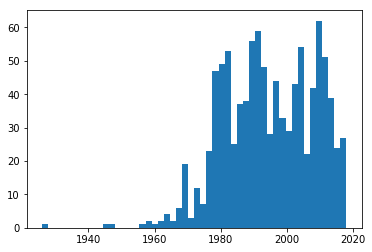

In [141]:
# Year information (All)
print('{} records have an associated year in the publication info (Plotted below)'.format(len(year_all_dict)))
plt.hist(year_all_dict.values(), bins=50)

793 records (excluding books) have an associated year in the publication info (Plotted below)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  2.,  4.,  2.,  6., 19.,  3., 12.,
         7., 22., 41., 46., 48., 22., 34., 32., 34., 46., 42., 25., 38.,
        23., 20., 35., 34., 16., 27., 48., 28., 26., 22., 23.]),
 array([1926.  , 1927.84, 1929.68, 1931.52, 1933.36, 1935.2 , 1937.04,
        1938.88, 1940.72, 1942.56, 1944.4 , 1946.24, 1948.08, 1949.92,
        1951.76, 1953.6 , 1955.44, 1957.28, 1959.12, 1960.96, 1962.8 ,
        1964.64, 1966.48, 1968.32, 1970.16, 1972.  , 1973.84, 1975.68,
        1977.52, 1979.36, 1981.2 , 1983.04, 1984.88, 1986.72, 1988.56,
        1990.4 , 1992.24, 1994.08, 1995.92, 1997.76, 1999.6 , 2001.44,
        2003.28, 2005.12, 2006.96, 2008.8 , 2010.64, 2012.48, 2014.32,
        2016.16, 2018.  ]),
 <a list of 50 Patch objects>)

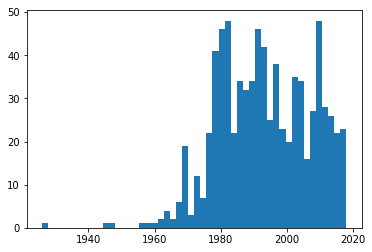

In [142]:
# Year information (No books)
print('{} records (excluding books) have an associated year in the publication info (Plotted below)'.format(len(year_nobook_dict)))
plt.hist(year_nobook_dict.values(), bins=50)

In [143]:
journal_df = pd.DataFrame(journal_list)
unique_journals = journal_df[0].value_counts()
print('{} records have a journal title, of which there are {} unique journals. Of which journals which appear the most are:'.format(len(journal_list), len(unique_journals)))
unique_journals[:20]

911 records have a journal title, of which there are 134 unique journals. Of which journals which appear the most are:


Nucl.Phys.A                                211
Phys.Lett.B                                 93
Astrophys.J.                                37
Phys.Rev.D                                  34
Lect.Notes Phys.                            33
Phys.Rev.Lett.                              28
Nuovo Cim.A                                 27
Nucl.Phys.B                                 24
Nucl.Phys.B Proc.Suppl.                     21
Phys.Rept.                                  20
Eur.Phys.J.C                                20
Int.J.Mod.Phys.A                            16
Nucl.Instrum.Meth.A                         15
Camb.Monogr.Part.Phys.Nucl.Phys.Cosmol.     13
PoS                                         12
Front.Phys.                                 11
Eur.Phys.J.A                                10
Riv.Nuovo Cim.                              10
Adv.Ser.Direct.High Energy Phys.            10
Springer Tracts Mod.Phys.                    9
Name: 0, dtype: int64

# Please ignore after this

### Investiagte non-existent "cited" articles

In [26]:
non_overlapping = np.setdiff1d(np.union1d(records.oldRef.unique(), legacy.recID.unique()), np.intersect1d(records.oldRef.unique(), legacy.recID.unique()))
non_overlapping = non_overlapping[1:] # Remove entry for Zero

In [27]:
print('List from Legacy machine and from ES queries has {} non-overlapping records'.format(len(non_overlapping)))

List from Legacy machine and from ES queries has 5289 non-overlapping records


In [50]:
cited_in_dump_but_not_bibrank = []
cited_in_bibrank_but_not_dump = []
for article in non_overlapping:
    if len(records[records.oldRef == article]) != 0:
        cited_in_dump_but_not_bibrank.append(article)
    if len(legacy[legacy.recID == article]) != 0:
        cited_in_bibrank_but_not_dump.append(article)

In [100]:
cited_in_bibrank = legacy_indexed.loc[cited_in_bibrank_but_not_dump]

In [101]:
cited_in_dump = pd.DataFrame(records.oldRef.value_counts()[cited_in_dump_but_not_bibrank])
cited_in_dump.columns = ['Citation_Difference']

## Miscellaneous Stuff

##### Top 200 Citeable

In [144]:
g = citeable_articles_with_loss_ext.reindex(exist_list)
g = g[~g.Citation_Difference.isna()]

In [145]:
d = citeable_articles_with_loss_ext.Citation_Difference.value_counts()
sum(d[-6:])

2293

In [146]:
top_200_lost_citeable= g.iloc[:200].index

In [147]:
# PLEASE ONLY RUN ONCE
if 'top_200_citeable_df' in locals():
    del top_200_citeable_df

for rid in top_200_lost_citeable:
    one_of_the_200 = records[(records.oldRef == rid) | (records.newRef == rid)]
    
    if 'top_200_citeable_df' in locals():
        top_200_citeable_df = top_200_citeable_df.append(one_of_the_200)
    else:
        top_200_citeable_df = one_of_the_200

In [148]:
top_200_citeable_df.to_csv('top_200_citeable_lost_citation_records-NEWAUG2018-curated_corrected.csv')

In [149]:
g.iloc[0:200].to_csv('top_200_citeable_lost_citations_recids-NEWAUG2018-curated_corrected.csv')

In [150]:
g.iloc[:200]

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
50008,-1098.0,1611.0,513.0
299778,-1033.0,1478.0,445.0
181166,-921.0,1728.0,807.0
1390184,-855.0,866.0,11.0
87997,-771.0,967.0,196.0
794379,-445.0,508.0,63.0
279039,-384.0,821.0,437.0
640063,-350.0,412.0,62.0
744400,-342.0,342.0,0.0


In [151]:
top_200_lost_citeable

Int64Index([  50008,  299778,  181166, 1390184,   87997,  794379,  279039,
             640063,  744400,  618647,
            ...
             807023,  805478,  809176,  809177,  809186,  808479,  809235,
             809187,  809212,  809213],
           dtype='int64', name='recID', length=200)

##### Top 200 Core

In [152]:
f = core_articles_with_loss_ext.reindex(exist_list)
f = f[~f.Citation_Difference.isna()]

In [153]:
c = core_articles_with_loss_ext.Citation_Difference.value_counts()
sum(c[-6:])

1952

In [154]:
top_200_lost_core= f.iloc[:200].index

In [155]:
# PLEASE ONLY RUN ONCE
if 'top_200_df' in locals():
    del top_200_df

for rid in top_200_lost_core:
    one_of_the_200 = records[(records.oldRef == rid) | (records.newRef == rid)]
    
    if 'top_200_df' in locals():
        top_200_df = top_200_df.append(one_of_the_200)
    else:
        top_200_df = one_of_the_200

In [156]:
top_200_df.to_csv('top_200_core_lost_citation_records-NEWAUG2018-curated_corrected.csv')

In [157]:
f.iloc[0:200].to_csv('top_200_core_lost_citations_recids-NEWAUG2018-curated_corrected.csv')

In [158]:
f.iloc[:200]

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
299778,-1033.0,1478.0,445.0
181166,-921.0,1728.0,807.0
794379,-445.0,508.0,63.0
279039,-384.0,821.0,437.0
640063,-350.0,412.0,62.0
744400,-342.0,342.0,0.0
706151,-322.0,338.0,16.0
618647,-310.0,330.0,20.0
345963,-304.0,316.0,12.0


In [159]:
top_200_lost_core

Int64Index([299778, 181166, 794379, 279039, 640063, 744400, 706151, 618647,
            345963, 656250,
            ...
            809213, 809214, 809215, 809217, 809218, 809219, 809238, 809221,
            809222, 809223],
           dtype='int64', name='recID', length=200)

##### Difference List

In [160]:
len(np.intersect1d(f[0:200].index, g[0:200].index))

174

In [161]:
different_between_core200_and_citeable200 = np.setxor1d(f[0:200].index, g[0:200].index)

In [162]:
diff_top_200 = lost_citations_ext.reindex(different_between_core200_and_citeable200)
diff_top_200 = diff_top_200[~diff_top_200.Citation_Difference.isna()]
diff_top_200.sort_values('Citation_Difference')

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
50008,-1098.0,1611.0,513.0
1390184,-855.0,866.0,11.0
87997,-771.0,967.0,196.0
706151,-322.0,338.0,16.0
656250,-302.0,484.0,182.0
391003,-284.0,310.0,26.0
61163,-254.0,259.0,5.0
619666,-210.0,336.0,126.0
52528,-206.0,208.0,2.0


##### Top 200 Core and CIteable

In [163]:
top_200_core_and_citeable = np.intersect1d(f.index, g.index)

In [164]:
top_200 = lost_citations_ext.reindex(top_200_core_and_citeable)
top_200 = top_200[~top_200.Citation_Difference.isna()]
top_200 = top_200.sort_values('Citation_Difference')

In [165]:
top_200 = top_200[0:200]

In [166]:
top_200_lost = top_200.index

In [167]:
# PLEASE ONLY RUN ONCE
if 'top_200_all_df' in locals():
    del top_200_all_df

for rid in top_200_lost:
    one_of_the_200 = records[(records.oldRef == rid) | (records.newRef == rid)]
    
    if 'top_200_all_df' in locals():
        top_200_all_df = top_200_all_df.append(one_of_the_200)
    else:
        top_200_all_df = one_of_the_200

In [168]:
top_200_all_df.to_csv('top_200_core_citeable_lost_citation_records-NEWAUG2018-curated_corrected.csv')

In [169]:
top_200.to_csv('top_200_core_citeable_lost_citations_recids-NEWAUG2018-curated_corrected.csv')

In [170]:
top_200

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
299778,-1033.0,1478.0,445.0
181166,-921.0,1728.0,807.0
794379,-445.0,508.0,63.0
279039,-384.0,821.0,437.0
640063,-350.0,412.0,62.0
744400,-342.0,342.0,0.0
618647,-310.0,330.0,20.0
345963,-304.0,316.0,12.0
338625,-299.0,299.0,0.0


In [171]:
top_200_all_df

,recID,oldRef,newRef,metaData
580716,413402,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '23', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['New York']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
638861,407131,299778,299778,"{'legacy_curated': True, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': True}"
1038102,486892,299778,299778,"{'legacy_curated': True, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': True}"
1039087,486744,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '1', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['Redwood City, CA,)']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1146764,498550,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'misc': ['The early universe Publishing Company']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1188663,554327,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '26', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['Frontiers in Physics, Vol. 69 Redwood']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1193971,543013,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '3', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['Reading, MA']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1218232,541767,299778,0,"{'reference': {'authors': [{'full_name': 'Kolb, E.'}, {'full_name': 'Turner, M.'}], 'misc': ['(Adison-Wesley, New York)'], 'title': {'title': 'The Early universe'}, 'label': '11', 'publication_info': {'year': 1990}}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1376988,573966,299778,0,"{'reference': {'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.'}], 'label': '97', 'misc': ['The Early Universe (Perseus book 1994)']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1394926,576374,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'label': '5', 'misc': ['1990, The Early Universe (Reading ) p 38, p84']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"


### Take out curated relations

In [250]:
from ast import literal_eval as le

In [251]:
unmatched_records = records[records.oldRef != records.newRef]
df = pd.DataFrame()

In [252]:
%%time

for i in range(len(unmatched_records)):
    record = unmatched_records[i:i+1]
    if le(record.metaData[record.index[0]]).get('curated_relation') is True:
        record.newRef = le(record.metaData[record.index[0]])['recid']
    df = df.append(record)

print()

/home/salman/python3venv/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



CPU times: user 1h 15min 50s, sys: 0 ns, total: 1h 15min 50s
Wall time: 1h 15min 53s


In [278]:
# Get the updated references
df[df.oldRef == df.newRef]

,recID,oldRef,newRef,metaData
4849,437543,430946,430946,"{'legacy_curated': True, 'recid': 430946, 'record': {'$ref': 'http://localhost:5000/api/literature/430946'}, 'curated_relation': True}"
4850,437543,431289,431289,"{'reference': {'label': '4'}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/431289'}, 'recid': 431289, 'curated_relation': True}"
4911,437723,236472,236472,"{'reference': {'misc': ['Snowmass, Proc. SSC Summer Study,, p. 384'], 'authors': [{'full_name': 'Peck, S.'}], 'label': '8', 'publication_info': {'year': 1984}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/236472'}, 'recid': 236472, 'curated_relation': True}"
23939,433632,369463,369463,"{'reference': {'label': '143'}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/369463'}, 'recid': 369463, 'curated_relation': True}"
25646,434070,369240,369240,"{'reference': {'authors': [{'full_name': 'Lutz, P.'}], 'title': {'title': 'SUSY with DELPHI'}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/369240'}, 'recid': 369240, 'curated_relation': True}"
25647,434070,369242,369242,"{'reference': {'authors': [{'full_name': 'Brown, R.'}], 'title': {'title': 'Searches for New Paricles in OPAL'}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/369242'}, 'recid': 369242, 'curated_relation': True}"
27278,434775,197970,197970,"{'legacy_curated': True, 'recid': 197970, 'record': {'$ref': 'http://localhost:5000/api/literature/197970'}, 'curated_relation': True}"
41540,393962,430946,430946,"{'legacy_curated': True, 'recid': 430946, 'record': {'$ref': 'http://localhost:5000/api/literature/430946'}, 'curated_relation': True}"
44467,399336,382504,382504,"{'legacy_curated': True, 'recid': 382504, 'record': {'$ref': 'http://localhost:5000/api/literature/382504'}, 'curated_relation': True}"
53404,410648,408588,408588,"{'reference': {'authors': [{'full_name': 'T.K.Gaisser'}, {'full_name': 'M.Honda'}, {'full_name': 'K.Kasahara'}, {'full_name': 'H.Lee'}, {'full_name': 'S.Midorikawa'}, {'full_name': 'V.Naumov'}], 'misc': ['and Todor Stanev Proceedings of the 24th lCRC. vol. 1. 702'], 'title': {'title': 'Comparison of Neutrino Flux calculations'}, 'label': '19', 'publication_info': {'year': 1995}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/408588'}, 'recid': 408588, 'curated_relation': True}"


In [283]:
records.iloc[df.index] = df

In [285]:
records.to_csv('new-citations-NEWAUG2018-corrected_for_curated-references.tsv', sep='\t')

In [288]:
c = records.newRef.value_counts()

In [292]:
c = c[1:]

In [295]:
c = c.sort_index()

In [296]:
c.to_csv('new-citation-counts-NEWAUG2018-corrected_for_curated_references.tsv', sep='\t')

In [175]:
lost_citations_ext.loc[652597]

Citation_Difference    -277.0
Legacy_Count           1619.0
Labs_Count             1342.0
Name: 652597, dtype: float64

In [173]:
gained_citations_ext

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
712925,283.0,9571.0,9854.0
796887,273.0,5433.0,5706.0
779080,209.0,5375.0,5584.0
568636,190.0,6.0,196.0
1420611,181.0,2.0,183.0
593382,173.0,9373.0,9546.0
1671602,130.0,0.0,130.0
925379,129.0,1187.0,1316.0
746087,125.0,1021.0,1146.0


In [174]:
abs_diff_ext

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
50008,1098.0,1611,513
299778,1033.0,1478,445
181166,921.0,1728,807
1390184,855.0,866,11
87997,771.0,967,196
794379,445.0,508,63
279039,384.0,821,437
673262,368.0,429,61
640063,350.0,412,62


In [46]:
records[(records.newRef == records.oldRef) & (records.newRef == 2724)]

,recID,oldRef,newRef,metaData
5507,417092,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '974', 'page_start': '974', 'journal_volume': '13'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"
5508,417092,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '1277', 'page_start': '1277', 'journal_volume': '19'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"
14029,415119,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '1277', 'page_start': '1277', 'journal_volume': '19'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"
23923,433632,2724,2724,"{'recid': 2724, 'legacy_curated': True, 'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '974', 'page_start': '974', 'journal_volume': '13'}}, 'curated_relation': False, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}}"
23924,433632,2724,2724,"{'recid': 2724, 'legacy_curated': True, 'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '1277', 'page_start': '1277', 'journal_volume': '19'}}, 'curated_relation': False, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}}"
24542,432996,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'authors': [{'full_name': 'Weinberg, S.'}], 'label': '1', 'publication_info': {'year': 1979, 'journal_title': 'Phys.Rev.D', 'artid': '1277', 'page_start': '1277', 'journal_volume': '19'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"
28534,371796,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'authors': [{'full_name': 'Weinberg, S.'}], 'label': '13', 'publication_info': {'year': 1979, 'journal_title': 'Phys.Rev.D', 'artid': '1277', 'page_start': '1277', 'journal_volume': '19'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"
30236,371736,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '1277', 'page_start': '1277', 'journal_volume': '19'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"
32222,375562,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '1277', 'page_start': '1277', 'journal_volume': '19'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"
32366,375777,2724,2724,"{'matched_record': 'https://labs.inspirehep.net/api/literature/2724', 'reference': {'publication_info': {'journal_title': 'Phys.Rev.D', 'artid': '974', 'page_start': '974', 'journal_volume': '13'}}, 'recid': 2724, 'record': {'$ref': 'http://localhost:5000/api/literature/2724'}, 'curated_relation': False}"


In [82]:
c = pd.pivot_table(records, values='recID', index='newRef', aggfunc=lambda x: len(x.unique()))

In [87]:
c[1:].to_csv('new-citation-counts-NEWAUG2018-corrected_for_curated_references.tsv', sep='\t')

In [89]:
records

,recID,oldRef,newRef,metaData
0,430932,319652,319652,"{'matched_record': 'https://labs.inspirehep.net/api/literature/319652', 'reference': {'authors': [{'full_name': 'Adinolfi, M.'}], 'label': '1', 'publication_info': {'year': 1992, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '177', 'page_start': '177', 'journal_volume': '315'}}, 'recid': 319652, 'record': {'$ref': 'http://localhost:5000/api/literature/319652'}, 'curated_relation': False}"
1,430932,304350,304350,"{'matched_record': 'https://labs.inspirehep.net/api/literature/304350', 'reference': {'authors': [{'full_name': 'Golovkin, S.'}], 'label': '2', 'publication_info': {'year': 1991, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '385', 'page_start': '385', 'journal_volume': '305'}}, 'recid': 304350, 'record': {'$ref': 'http://localhost:5000/api/literature/304350'}, 'curated_relation': False}"
2,430932,355171,355171,"{'matched_record': 'https://labs.inspirehep.net/api/literature/355171', 'reference': {'authors': [{'full_name': 'Autiero, D.'}], 'label': '3', 'publication_info': {'year': 1993, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '521', 'page_start': '521', 'journal_volume': '336'}}, 'recid': 355171, 'record': {'$ref': 'http://localhost:5000/api/literature/355171'}, 'curated_relation': False}"
3,430932,322171,322171,"{'matched_record': 'https://labs.inspirehep.net/api/literature/322171', 'reference': {'authors': [{'full_name': 'Atac, M.'}], 'label': '4', 'publication_info': {'year': 1991, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '56', 'page_start': '56', 'journal_volume': '314'}}, 'recid': 322171, 'record': {'$ref': 'http://localhost:5000/api/literature/322171'}, 'curated_relation': False}"
4,430932,298028,298028,"{'matched_record': 'https://labs.inspirehep.net/api/literature/298028', 'reference': {'authors': [{'full_name': 'Kuroda, K.'}], 'label': '5', 'publication_info': {'year': 1991, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '259', 'page_start': '259', 'journal_volume': '300'}}, 'recid': 298028, 'record': {'$ref': 'http://localhost:5000/api/literature/298028'}, 'curated_relation': False}"
5,430932,345933,345933,"{'matched_record': 'https://labs.inspirehep.net/api/literature/345933', 'reference': {'authors': [{'full_name': 'Majewski, S.'}], 'label': '6', 'publication_info': {'year': 1992, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '489', 'page_start': '489', 'journal_volume': '323'}}, 'recid': 345933, 'record': {'$ref': 'http://localhost:5000/api/literature/345933'}, 'curated_relation': False}"
6,430932,335543,335543,"{'matched_record': 'https://labs.inspirehep.net/api/literature/335543', 'reference': {'authors': [{'full_name': 'Bähr, J.'}], 'label': '7', 'publication_info': {'year': 1993, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '145', 'page_start': '145', 'journal_volume': '324'}}, 'recid': 335543, 'record': {'$ref': 'http://localhost:5000/api/literature/335543'}, 'curated_relation': False}"
7,430932,0,0,"{'reference': {'authors': [{'full_name': 'Cardini, A.'}], 'label': '8', 'misc': ['Preprint INFN PI/AE 94/08']}}"
8,430932,336159,336159,"{'matched_record': 'https://labs.inspirehep.net/api/literature/336159', 'reference': {'authors': [{'full_name': 'Abbott, B.'}], 'label': '9', 'publication_info': {'year': 1993, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '319', 'page_start': '319', 'journal_volume': '327'}}, 'recid': 336159, 'record': {'$ref': 'http://localhost:5000/api/literature/336159'}, 'curated_relation': False}"
9,430932,364169,364169,"{'matched_record': 'https://labs.inspirehep.net/api/literature/364169', 'reference': {'authors': [{'full_name': 'Cardini, A.'}], 'label': '10', 'publication_info': {'year': 1994, 'journal_title': 'Nucl.Instrum.Meth.A', 'artid': '163', 'page_start': '163', 'journal_volume': '346'}}, 'recid': 364169, 'record': {'$ref': 'http://localhost:5000/api/literature/364169'}, 'curated_relation': False}"


In [180]:
records[(records.oldRef == 652597) & (records.oldRef != records.newRef)]

,recID,oldRef,newRef,metaData
1749824,1520874,652597,0,"{'reference': {'misc': ['131'], 'publication_info': {'year': 2005, 'journal_title': 'Eur.Phys.J.C', 'artid': '1', 'page_start': '1', 'journal_volume': '41'}, 'authors': [{'full_name': 'Charles, J.'}], 'label': '12', 'urls': [{'value': 'http://ckmfitter.in2p3.fr'}]}, 'recid': 652597, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'curated_relation': False}"
1791560,1605109,652597,0,"{'reference': {'misc': ['Andreas Hocker, H. Lacker, S. Laplace, F. R. Le Diberder, J. Malcles, J. Ocariz, M Pivk, and L. Roos. CP violation and the CKM matrix: Assessing the impact of the asymmetric B factories'], 'authors': [{'full_name': 'Charles, J.'}], 'label': '3', 'publication_info': {'year': 2005, 'page_end': '131', 'journal_title': 'Eur.Phys.J.C', 'page_start': '1', 'journal_volume': '41'}}, 'recid': 652597, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'curated_relation': False}"
1796191,1605660,652597,0,"{'reference': {'misc': ['CKMfitter CP Violation and the CKM Matrix: Assessing the Impact of the89 Asymmetric B Factories updated results and plots available at:90'], 'publication_info': {'year': 2005, 'journal_title': 'Eur.Phys.J.C', 'artid': '1', 'page_start': '1', 'journal_volume': '41'}, 'authors': [{'full_name': 'Group, J.C.'}], 'label': '1', 'urls': [{'value': 'http://ckmfitter.in2p3.fr.91'}]}, 'recid': 652597, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'curated_relation': False}"
1811613,1608702,652597,0,"{'reference': {'misc': ['(CKMfitter group)'], 'authors': [{'full_name': 'Charles, J.'}], 'label': '3', 'publication_info': {'year': 2005, 'journal_title': 'Eur.Phys.J.C', 'artid': '1', 'page_start': '1', 'journal_volume': '41'}}, 'recid': 652597, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'curated_relation': False}"
2553434,1621728,652597,0,"{'reference': {'misc': ['Andreas Hocker, H. Lacker, S. Laplace, F. R. Le Diberder, J. Malcles, J. Ocariz, M Pivk, and L. Roos. CP violation and the CKM matrix: Assessing the impact of the asymmetric B factories'], 'authors': [{'full_name': 'Charles, J.'}], 'label': '26', 'publication_info': {'year': 2005, 'page_end': '131', 'journal_title': 'Eur.Phys.J.C', 'page_start': '1', 'journal_volume': '41'}}, 'recid': 652597, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'curated_relation': False}"
2763481,1651725,652597,0,"{'reference': {'misc': ['CKM Fitter Charles et al updated results and plots available at:'], 'publication_info': {'year': 2005, 'journal_title': 'Eur.Phys.J.C', 'artid': '1', 'page_start': '1', 'journal_volume': '41'}, 'authors': [{'full_name': 'Group, J.'}], 'label': '7', 'urls': [{'value': 'http://ckmfitter.in2p3.fr'}]}, 'recid': 652597, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'curated_relation': False}"
2857898,706850,652597,0,"{'reference': {'publication_info': {'journal_title': 'Eur.Phys.J.C', 'artid': '1', 'page_start': '1', 'journal_volume': '41'}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'recid': 652597, 'curated_relation': False}"
2968425,751290,652597,0,"{'reference': {'publication_info': {'journal_title': 'Eur.Phys.J.C', 'artid': '1', 'page_start': '1', 'journal_volume': '41'}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'recid': 652597, 'curated_relation': False}"
2973454,756158,652597,0,"{'reference': {'misc': ['BIBLIOGRAPHY 337'], 'authors': [{'full_name': 'Charles'}], 'label': '30', 'publication_info': {'year': 2005, 'journal_title': 'Eur.Phys.J.C', 'artid': '1', 'page_start': '1', 'journal_volume': '41'}}, 'recid': 652597, 'record': {'$ref': 'http://localhost:5000/api/literature/652597'}, 'curated_relation': False}"
3062500,724945,652597,0,"{'reference': {'authors': [{'full_name': 'Charles, J.'}], 'label': '9', 'publication_info': {'year': 2005, 'journal_title': 'Eur.Phys.J.C', 'art